### Nonlinear interaction of energetic electrons with large amplitude chorus
Bortnik, Thorne and Inan 2008


In [1]:
import numpy as np
import os
import sys
import inspect
import matplotlib.pyplot as plt


#Define WPIT package location
current_dir =  os.path.abspath(os.path.dirname('__file__'))
fpath = os.path.abspath(current_dir + "/..")
sys.path.append(fpath)


import WPIT.Environment_mod as env
import WPIT.WaveProperties_mod as wave
import WPIT.WPI_mod.whistler_electron_mod as wpi



### 1. Define simulation parameters

Here we define all the initial parameters of the simulation in respect with the particle and the wave

In [2]:
ne_0=10**7 #equatorial electron density in m^-3
L_shell=5  #L-shell of the simulation 
By_wave=1*10**(-12)   # By component of the wave in Tesla
aeq0_deg=68   #initial equatorial pitch angle in deg
aeq0=np.deg2rad(aeq0_deg) #convert pitch angle to rad
Ekev0=168.3 #initial energy in keV
lamda0_deg=-9  # starting electron latitude in deg
lamda0=np.deg2rad(lamda0_deg) #convert latitude to rad
theta0_deg=0.0001# initial wave normal angle in deg
theta0=np.deg2rad(theta0_deg) #convert wave normal angle to rad
f_wave=2000 # wave frequency in Hz
w_wave=2*np.pi*f_wave #wave angular frequency in rad/s
m_res=1 #WPI resonance number (0=Landau resonance)
eta0_deg=np.linspace(0,361,12) #initial electron-wave phases in deg
eta0=np.deg2rad(eta0_deg) #convert initial electron-wave phases to rad

t=0.1 #simulation duration (s)
h=0.00001  #simulation stepsize
Nsteps=int(t/h) #number of simulation steps
print(eta0)

[0.         0.57278533 1.14557065 1.71835598 2.29114131 2.86392664
 3.43671196 4.00949729 4.58228262 5.15506795 5.72785327 6.3006386 ]


### 2. Find initial electron's local pitch angle 

In [3]:

alpha0=env.aeq2alpha(L_shell,lamda0,aeq0)

print('\u03B1:',np.rad2deg(alpha0))
# print('\N{GREEK SMALL LETTER alpha}')

α: 78.37445795337882


### 3. Find initial momentum, velocity and lorentz factor

In [4]:
upar0,uper0,ppar0,pper0,gamma0=env.initial_velocity(Ekev0,alpha0,env.const.me)

print('upar0:',upar0,'m/s')
print('uper0:',uper0,'m/s')
print('ppar0:',ppar0,'Ns')
print('pper0:',pper0,'Ns')
print('gamma0:',gamma0)

upar0: 39805013.39163095 m/s
uper0: 193476979.55557317 m/s
ppar0: 4.820203623516892e-23 Ns
pper0: 2.3429170309410255e-22 Ns
gamma0: 1.3293478962221865


### 5. Calculate all the initial parameters

In [5]:

Bmag0=env.Bmag_dipole(L_shell,lamda0)
ne0=env.density_FL_denton(ne_0,lamda0)

#assuming 94%H+, 5.4%He+, 0.6%O+
nH0=0.77*ne0
nHe0=0.2*ne0
nO0=0.03*ne0    

S0,D0,P0,R0,L0=wave.stix_parameters(w_wave, ne0, nH0, nHe0, nO0, Bmag0)

eta_sq_plus0,eta_sq_minus0,mu0,kappa0,kappaz0,kappax0=wave.refr_index_full(theta0,w_wave,S0,P0,R0,L0)

wce0=env.omega_cyclotron(Bmag0,env.const.qe,env.const.me)


Bxw0, Byw0, Bzw0, Exw0, Eyw0, Ezw0=wave.wave_amplitudes_bell(mu0,P0,D0,S0,By_wave,theta0)
dwceds0=env.dwc_ds(wce0,lamda0,L_shell)

gamma0,w10,w20,wtau_sq0,R10,R20,beta0=wpi.wpi_params(m_res,ppar0,pper0,Bxw0, Byw0,Exw0,Eyw0,Ezw0,kappaz0,kappax0,wce0)
v_para_res0, v_per_res0, v_tot_res0, E_res0,gamma_res0=wave.resonant_velocity(m_res,w_wave,kappaz0,wce0,alpha0,env.const.me)

wcH0=env.omega_cyclotron(Bmag0,env.const.qe,env.const.mH)
wcHe0=env.omega_cyclotron(Bmag0,env.const.qe,env.const.mHe)
wcO0=env.omega_cyclotron(Bmag0,env.const.qe,env.const.mO)

wpe0=env.omega_plasma(ne0,env.const.qe,env.const.me)
wpH0=env.omega_plasma(nH0,env.const.qi,env.const.mH)
wpHe0=env.omega_plasma(nHe0,env.const.qi,env.const.mHe)
wpO0=env.omega_plasma(nO0,env.const.qi,env.const.mO)
wuhr0=env.omega_uhr(wce0,wpe0)
wlhr0=env.omega_lhr(wce0, wpe0, wcH0, wpH0)

dwcHds0=env.dwc_ds(wcH0,lamda0,L_shell)
dwcHeds0=env.dwc_ds(wcHe0,lamda0,L_shell)
dwcOds0=env.dwc_ds(wcO0,lamda0,L_shell)



### 4. Allocate outputs


In [6]:
pper=np.zeros((len(eta0),Nsteps+1))
ppar=np.zeros((len(eta0),Nsteps+1))
eta=np.zeros((len(eta0),Nsteps+1))
lamda=np.zeros((len(eta0),Nsteps+1))
time=np.zeros((len(eta0),Nsteps+1))
uper=np.zeros((len(eta0),Nsteps+1))
upar=np.zeros((len(eta0),Nsteps+1))
zeta=np.zeros((len(eta0),Nsteps+1))
alpha=np.zeros((len(eta0),Nsteps+1))
alpha2=np.zeros((len(eta0),Nsteps+1))
aeq=np.zeros((len(eta0),Nsteps+1))
aeq2=np.zeros((len(eta0),Nsteps+1))
Exw_out=np.zeros((len(eta0),Nsteps+1))
Eyw_out=np.zeros((len(eta0),Nsteps+1))
Ezw_out=np.zeros((len(eta0),Nsteps+1))
Bxw_out=np.zeros((len(eta0),Nsteps+1))
Byw_out=np.zeros((len(eta0),Nsteps+1))
Bzw_out=np.zeros((len(eta0),Nsteps+1))
Bw_out=np.zeros((len(eta0),Nsteps+1))
Ew_out=np.zeros((len(eta0),Nsteps+1))
vresz_o=np.zeros((len(eta0),Nsteps+1))
Eres_o=np.zeros((len(eta0),Nsteps+1))

mu_out=np.zeros((len(eta0),Nsteps+1))
deta_dt=np.zeros((len(eta0),Nsteps+1))
S_stix=np.zeros((len(eta0),Nsteps+1))
D_stix=np.zeros((len(eta0),Nsteps+1))
P_stix=np.zeros((len(eta0),Nsteps+1))
R_stix=np.zeros((len(eta0),Nsteps+1))
L_stix=np.zeros((len(eta0),Nsteps+1))
kx_out=np.zeros((len(eta0),Nsteps+1))
kz_out=np.zeros((len(eta0),Nsteps+1))
wh_out=np.zeros((len(eta0),Nsteps+1))
dwh_dt_out=np.zeros((len(eta0),Nsteps+1))
gamma_out=np.zeros((len(eta0),Nsteps+1))
Phi_out=np.zeros((len(eta0),Nsteps+1))
E_kin=np.zeros((len(eta0),Nsteps+1))
v_res_out=np.zeros((len(eta0),Nsteps+1))
E_res_out=np.zeros((len(eta0),Nsteps+1))

Bxw_out=np.zeros((len(eta0),Nsteps+1))
Byw_out=np.zeros((len(eta0),Nsteps+1))
Bzw_out=np.zeros((len(eta0),Nsteps+1))
Exw_out=np.zeros((len(eta0),Nsteps+1))
Eyw_out=np.zeros((len(eta0),Nsteps+1))
Ezw_out=np.zeros((len(eta0),Nsteps+1))
S_out=np.zeros((len(eta0),Nsteps+1))
wtrsq_out=np.zeros((len(eta0),Nsteps+1))
C0_out=np.zeros((len(eta0),Nsteps+1))
C1p_out=np.zeros((len(eta0),Nsteps+1))
C1m_out=np.zeros((len(eta0),Nsteps+1))
kappa_out=np.zeros((len(eta0),Nsteps+1))

ne_out=np.zeros((len(eta0),Nsteps+1))
nH_out=np.zeros((len(eta0),Nsteps+1))
nHe_out=np.zeros((len(eta0),Nsteps+1))
nO_out=np.zeros((len(eta0),Nsteps+1))

wce_out=np.zeros((len(eta0),Nsteps+1))
wcH_out=np.zeros((len(eta0),Nsteps+1))
wcHe_out=np.zeros((len(eta0),Nsteps+1))
wcO_out=np.zeros((len(eta0),Nsteps+1))
wpe_out=np.zeros((len(eta0),Nsteps+1))
wpHe_out=np.zeros((len(eta0),Nsteps+1))
wpH_out=np.zeros((len(eta0),Nsteps+1))
wpO_out=np.zeros((len(eta0),Nsteps+1))
wlhr_out=np.zeros((len(eta0),Nsteps+1))
wuhr_out=np.zeros((len(eta0),Nsteps+1))
dwceds_out=np.zeros((len(eta0),Nsteps+1))
dwcHds_out=np.zeros((len(eta0),Nsteps+1))
dwcHeds_out=np.zeros((len(eta0),Nsteps+1))
dwcOds_out=np.zeros((len(eta0),Nsteps+1))

Bmag_out=np.zeros((len(eta0),Nsteps+1))

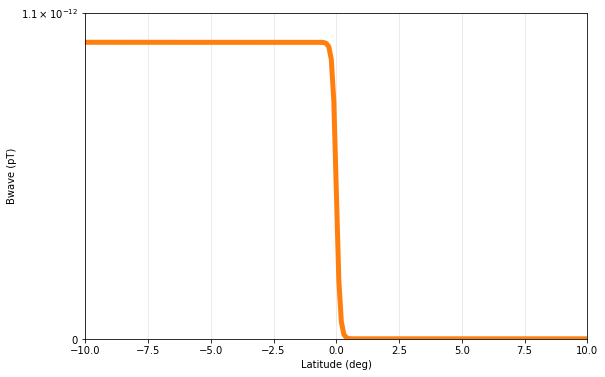

In [7]:

lamda_packet2=np.arange(-10,10,0.1)
lamda_packet_rad2=np.deg2rad(lamda_packet2)

Byw0_packet2=1*10**(-12)
shape=7
direction='south'
location=0
Bw_packet2=[]

for i in range(0,len(lamda_packet2)):

    Bytmp=wave.wave_packet_one_sided(Byw0_packet2,lamda_packet_rad2[i],shape,location,direction)

#     print(Bytmp)
    Bw_packet2.append(Bytmp)

    
fig, ax = plt.subplots(figsize=(9,6))
s=5
ax.plot(lamda_packet2,Bw_packet2,c='tab:orange',linewidth=s)
ax.grid(alpha=.3)
ax.set_xlim(-10,10)
ax.set_yscale('symlog')
ax.set_xlabel('Latitude (deg)')
ax.set_ylabel('Bwave (pT)')

ax.set_ylim(0,1.1*10**(-12))
# ticks=np.arange(0,2*np.pi,1)
# cbar=fig.colorbar(cmap, ticks=ticks)
# cbar.set_label('gyro-phase (rad)', rotation=270,labelpad=15)
#     ax.axvline(x=-5,color="black", linestyle="--")
plt.show()


/home/tourgaidis/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: AutoMinorLocator does not work with logarithmic scale
/home/tourgaidis/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: AutoMinorLocator does not work with logarithmic scale
/home/tourgaidis/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


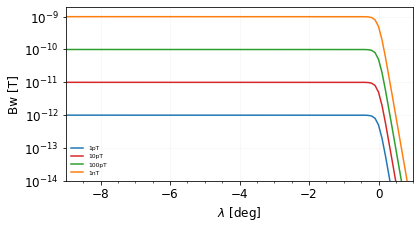

In [132]:

lamda_packet2=np.arange(-10,10,0.1)
lamda_packet_rad2=np.deg2rad(lamda_packet2)

Byw1pT=1*10**(-12)
Byw10pT=10*10**(-12)
Byw100pT=100*10**(-12)
Byw1nT=1000*10**(-12)
shape=7
direction='south'
location=0
Bw_1pT=[]
Bw_10pT=[]
Bw_100pT=[]
Bw_1nT=[]

for i in range(0,len(lamda_packet2)):

    Bytmp1pT=wave.wave_packet_one_sided(Byw1pT,lamda_packet_rad2[i],shape,location,direction)
    Bytmp10pT=wave.wave_packet_one_sided(Byw10pT,lamda_packet_rad2[i],shape,location,direction)
    Bytmp100pT=wave.wave_packet_one_sided(Byw100pT,lamda_packet_rad2[i],shape,location,direction)
    Bytmp1nT=wave.wave_packet_one_sided(Byw1nT,lamda_packet_rad2[i],shape,location,direction)

    Bw_1pT.append(Bytmp1pT)
    Bw_10pT.append(Bytmp10pT)
    Bw_100pT.append(Bytmp100pT)
    Bw_1nT.append(Bytmp1nT)



###################################################################
fig, ax = plt.subplots(figsize=(6,85*inch_to_mm))
s=0.1

# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.plot(lamda_packet2,Bw_1pT,c='tab:blue',label='1pT')
ax.plot(lamda_packet2,Bw_10pT,c='tab:red',label='10pT')
ax.plot(lamda_packet2,Bw_100pT,c='tab:green',label='100pT')
ax.plot(lamda_packet2,Bw_1nT,c='tab:orange',label='1nT')
ax.grid(alpha=.1)
ax.set_xlim(-9,1)
ax.set_xlabel(r'$\lambda$ [deg]')
ax.set_ylabel(r'Bw [T]')

ax.set_yscale('log')
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.set_ylim(10**(-14),2*10**(-9))
ax.legend(frameon=False,loc=0, prop={'size': 6})
# ax.axvline(x=-5,color="black", linestyle="--")
plt.tight_layout()
plt.savefig('wave_fields_aeq0_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()



### Runge-Kutta

In [8]:
for k in range(0,len(eta0)):
    i=0
    time[k,0]=0
    pper[k,0]=pper0
    ppar[k,0]=ppar0
    eta[k,0]=eta0[k]
    lamda[k,0]=lamda0
    zeta[k,0]=0
    upar[k,0]=upar0
    uper[k,0]=uper0
    alpha[k,0]=alpha0
    alpha2[k,0]=alpha0
    aeq[k,0]=aeq0
    aeq2[k,0]=aeq0
    mu_out[k,0]=mu0
    deta_dt[k,0]=0
    S_stix[k,0]=S0
    D_stix[k,0]=D0
    P_stix[k,0]=P0
    R_stix[k,0]=R0
    L_stix[k,0]=L0
    kappa_out[k,0]=kappa0
    kx_out[k,0]=kappax0
    kz_out[k,0]=kappaz0
    dwh_dt_out[k,0]=dwceds0
    gamma_out[k,0]=gamma0
    E_kin[k,0]=1.602176487E-16*Ekev0 #from keV to ergs
    v_res_out[k,0]=v_para_res0
    E_res_out[k,0]=E_res0
    Bxw_out[k,0]=Bxw0
    Byw_out[k,0]=Byw0
    Bzw_out[k,0]=Bzw0
    Exw_out[k,0]=Exw0
    Eyw_out[k,0]=Eyw0
    Ezw_out[k,0]=Ezw0
    wce_out[k,0]=wce0
    wcH_out[k,0]=wcH0
    wcHe_out[k,0]=wcHe0
    wcO_out[k,0]=wcO0
    wpe_out[k,0]=wpe0
    wpHe_out[k,0]=wpHe0
    wpH_out[k,0]=wpH0
    wpO_out[k,0]=wpO0
    wlhr_out[k,0]=wlhr0
    wuhr_out[k,0]=wuhr0

    ne_out[k,0]=ne0
    nH_out[k,0]=nH0
    nHe_out[k,0]=nHe0
    nO_out[k,0]=nO0
    dwceds_out[k,0]=dwceds0
    dwcHds_out[k,0]=dwcHds0
    dwcHeds_out[k,0]=dwcHeds0
    dwcOds_out[k,0]=dwcOds0
    Bmag_out[k,0]=Bmag0
#     print(np.rad2deg(eta[k,0]))
    while i<Nsteps:
    ######################################################################################################
    #First step of Runge Kutta
    ######################################################################################################

        Bmag=env.Bmag_dipole(L_shell,lamda[k,i])
        ne=env.density_FL_denton(ne_0,lamda[k,i])

        #assuming 94%H+, 5.4%He+, 0.6%O+
        nH=0.94*ne
        nHe=0.054*ne
        nO=0.006*ne    

        S,D,P,R,L=wave.stix_parameters(w_wave, ne, nH, nHe, nO, Bmag)

        eta_sq_plus,eta_sq_minus,mu,kappa,kz,kx=wave.refr_index_full(theta0,w_wave,S,P,R,L)

        wce=env.omega_cyclotron(Bmag,env.const.qe,env.const.me)
        By_packet=wave.wave_packet_one_sided(By_wave,lamda[k,i],shape,location,direction)

        Bxw, Byw, Bzw, Exw, Eyw, Ezw=wave.wave_amplitudes_bell(mu,P,D,S,By_packet,theta0)
        dwceds=env.dwc_ds(wce,lamda[k,i],L_shell)

        gamma,w1,w2,wtau_sq,R1,R2,beta=wpi.wpi_params(m_res,ppar[k,i],pper[k,i],Bxw, Byw,Exw,Eyw,Ezw,kz,kx,wce)
        v_para_res, v_per_res, v_tot_res, E_res,gamma_res=wave.resonant_velocity(m_res,w_wave,kz,wce,alpha[k,i],env.const.me)
        
        
        k1=wpi.dzdt(ppar[k,i],gamma,env.const.me)
        l1=wpi.dppardt(pper[k,i],eta[k,i],wtau_sq,kz,gamma,wce,dwceds)
        m1=wpi.dpperdt(ppar[k,i],pper[k,i],eta[k,i],w1,w2,beta,gamma,R1,R2,m_res,wce,dwceds)
        n1=wpi.detadt(ppar[k,i],m_res,wce,w_wave,gamma,kz)
        o1=wpi.dlamdadt(ppar[k,i],lamda[k,i],gamma,L_shell)
        p1=wpi.dalphadt(pper[k,i],ppar[k,i],eta[k,i],w1,w2,R1,R2,wtau_sq,kz,beta,m_res,gamma,wce,dwceds)
        q1=wpi.daeqdt(ppar[k,i],pper[k,i],alpha[k,i],aeq[k,i],eta[k,i],w1,R1,w2,R2,gamma,beta,wtau_sq,kz,m_res)
        r1=wpi.dgammadt(pper[k,i],ppar[k,i],eta[k,i],m_res,Exw,Eyw,Ezw,beta,gamma)
        s1=wpi.dEkdt(pper[k,i],ppar[k,i],eta[k,i],m_res,Exw,Eyw,Ezw,beta,gamma)
        

#     ######################################################################################################
#     #Second step of Runge Kutta
#     ######################################################################################################

        Bmag=env.Bmag_dipole(L_shell,lamda[k,i]+0.5*h*o1)
        ne=env.density_FL_denton(ne_0,lamda[k,i]+0.5*h*o1)

        #assuming 94%H+, 5.4%He+, 0.6%O+
        nH=0.77*ne
        nHe=0.2*ne
        nO=0.03*ne    

        S,D,P,R,L=wave.stix_parameters(w_wave, ne, nH, nHe, nO, Bmag)

        eta_sq_plus,eta_sq_minus,mu,kappa,kz,kx=wave.refr_index_full(theta0,w_wave,S,P,R,L)

        wce=env.omega_cyclotron(Bmag,env.const.qe,env.const.me)
        By_packet=wave.wave_packet_one_sided(By_wave,lamda[k,i]+0.5*h*o1,shape,location,direction)

        Bxw, Byw, Bzw, Exw, Eyw, Ezw=wave.wave_amplitudes_bell(mu,P,D,S,By_packet,theta0)
        dwceds=env.dwc_ds(wce,lamda[k,i]+0.5*h*o1,L_shell)

        gamma,w1,w2,wtau_sq,R1,R2,beta=wpi.wpi_params(m_res,ppar[k,i]+0.5*h*l1,pper[k,i]+0.5*h*m1,Bxw, Byw,Exw,Eyw,Ezw,kz,kx,wce)
        v_para_res, v_per_res, v_tot_res, E_res,gamma_res=wave.resonant_velocity(m_res,w_wave,kz,wce,alpha[k,i]+0.5*h*p1,env.const.me)
        
        
        k2=wpi.dzdt(ppar[k,i]+0.5*h*l1,gamma,env.const.me)
        l2=wpi.dppardt(pper[k,i]+0.5*h*m1,eta[k,i]+0.5*h*n1,wtau_sq,kz,gamma,wce,dwceds)
        m2=wpi.dpperdt(ppar[k,i]+0.5*h*l1,pper[k,i]+0.5*h*m1,eta[k,i]+0.5*h*n1,w1,w2,beta,gamma,R1,R2,m_res,wce,dwceds)
        n2=wpi.detadt(ppar[k,i]+0.5*h*l1,m_res,wce,w_wave,gamma,kz)
        o2=wpi.dlamdadt(ppar[k,i]+0.5*h*l1,lamda[k,i]+0.5*h*o1,gamma,L_shell)
        p2=wpi.dalphadt(pper[k,i]+0.5*h*m1,ppar[k,i]+0.5*h*l1,eta[k,i]+0.5*h*n1,w1,w2,R1,R2,wtau_sq,kz,beta,m_res,gamma,wce,dwceds)
        q2=wpi.daeqdt(ppar[k,i]+0.5*h*l1,pper[k,i]+0.5*h*m1,alpha[k,i]+0.5*h*p1,aeq[k,i]+0.5*h*q1,eta[k,i]+0.5*h*n1,w1,R1,w2,R2,gamma,beta,wtau_sq,kz,m_res)
        r2=wpi.dgammadt(pper[k,i]+0.5*h*m1,ppar[k,i]+0.5*h*l1,eta[k,i]+0.5*h*n1,m_res,Exw,Eyw,Ezw,beta,gamma)
        s2=wpi.dEkdt(pper[k,i]+0.5*h*m1,ppar[k,i]+0.5*h*l1,eta[k,i]+0.5*h*n1,m_res,Exw,Eyw,Ezw,beta,gamma)
        
#     ######################################################################################################
#     #Third step of Runge Kutta
#     ######################################################################################################

        Bmag=env.Bmag_dipole(L_shell,lamda[k,i]+0.5*h*o2)
        ne=env.density_FL_denton(ne_0,lamda[k,i]+0.5*h*o2)

        #assuming 94%H+, 5.4%He+, 0.6%O+
        nH=0.77*ne
        nHe=0.2*ne
        nO=0.03*ne   

        S,D,P,R,L=wave.stix_parameters(w_wave, ne, nH, nHe, nO, Bmag)

        eta_sq_plus,eta_sq_minus,mu,kappa,kz,kx=wave.refr_index_full(theta0,w_wave,S,P,R,L)


        wce=env.omega_cyclotron(Bmag,env.const.qe,env.const.me)

        By_packet=wave.wave_packet_one_sided(By_wave,lamda[k,i]+0.5*h*o2,shape,location,direction)
        Bxw, Byw, Bzw, Exw, Eyw, Ezw=wave.wave_amplitudes_bell(mu,P,D,S,By_packet,theta0)
        dwceds=env.dwc_ds(wce,lamda[k,i]+0.5*h*o2,L_shell)

        gamma,w1,w2,wtau_sq,R1,R2,beta=wpi.wpi_params(m_res,ppar[k,i]+0.5*h*l2,pper[k,i]+0.5*h*m2,Bxw, Byw,Exw,Eyw,Ezw,kz,kx,wce)
        v_para_res, v_per_res, v_tot_res, E_res,gamma_res=wave.resonant_velocity(m_res,w_wave,kz,wce,alpha[k,i]+0.5*h*p2,env.const.me)
        
        
        k3=wpi.dzdt(ppar[k,i]+0.5*h*l2,gamma,env.const.me)
        l3=wpi.dppardt(pper[k,i]+0.5*h*m2,eta[k,i]+0.5*h*n2,wtau_sq,kz,gamma,wce,dwceds)
        m3=wpi.dpperdt(ppar[k,i]+0.5*h*l2,pper[k,i]+0.5*h*m2,eta[k,i]+0.5*h*n2,w1,w2,beta,gamma,R1,R2,m_res,wce,dwceds)
        n3=wpi.detadt(ppar[k,i]+0.5*h*l2,m_res,wce,w_wave,gamma,kz)
        o3=wpi.dlamdadt(ppar[k,i]+0.5*h*l2,lamda[k,i]+0.5*h*o2,gamma,L_shell)
        p3=wpi.dalphadt(pper[k,i]+0.5*h*m2,ppar[k,i]+0.5*h*l2,eta[k,i]+0.5*h*n2,w1,w2,R1,R2,wtau_sq,kz,beta,m_res,gamma,wce,dwceds)
        q3=wpi.daeqdt(ppar[k,i]+0.5*h*l2,pper[k,i]+0.5*h*m2,alpha[k,i]+0.5*h*p2,aeq[k,i]+0.5*h*q2,eta[k,i]+0.5*h*n2,w1,R1,w2,R2,gamma,beta,wtau_sq,kz,m_res)
        r3=wpi.dgammadt(pper[k,i]+0.5*h*m2,ppar[k,i]+0.5*h*l2,eta[k,i]+0.5*h*n2,m_res,Exw,Eyw,Ezw,beta,gamma)
        s3=wpi.dEkdt(pper[k,i]+0.5*h*m2,ppar[k,i]+0.5*h*l2,eta[k,i]+0.5*h*n2,m_res,Exw,Eyw,Ezw,beta,gamma)
#     ######################################################################################################
#     #Fourth step of Runge Kutta
#     ######################################################################################################

        Bmag=env.Bmag_dipole(L_shell,lamda[k,i]+h*o3)
        ne=env.density_FL_denton(ne_0,lamda[k,i]+h*o3)

        #assuming 94%H+, 5.4%He+, 0.6%O+
        nH=0.77*ne
        nHe=0.2*ne
        nO=0.03*ne     

        S,D,P,R,L=wave.stix_parameters(w_wave, ne, nH, nHe, nO, Bmag)

        eta_sq_plus,eta_sq_minus,mu,kappa,kz,kx=wave.refr_index_full(theta0,w_wave,S,P,R,L)


        wce=env.omega_cyclotron(Bmag,env.const.qe,env.const.me)

        By_packet=wave.wave_packet_one_sided(By_wave,lamda[k,i]+h*o3,shape,location,direction)
        Bxw, Byw, Bzw, Exw, Eyw, Ezw=wave.wave_amplitudes_bell(mu,P,D,S,By_packet,theta0)
        dwceds=env.dwc_ds(wce,lamda[k,i]+h*o3,L_shell)

        gamma,w1,w2,wtau_sq,R1,R2,beta=wpi.wpi_params(m_res,ppar[k,i]+h*l3,pper[k,i]+h*m3,Bxw, Byw,Exw,Eyw,Ezw,kz,kx,wce)
        v_para_res, v_per_res, v_tot_res, E_res,gamma_res=wave.resonant_velocity(m_res,w_wave,kz,wce,alpha[k,i]+h*p3,env.const.me)
        
        
        k4=wpi.dzdt(ppar[k,i]+h*l3,gamma,env.const.me)
        l4=wpi.dppardt(pper[k,i]+h*m3,eta[k,i]+h*n3,wtau_sq,kz,gamma,wce,dwceds)
        m4=wpi.dpperdt(ppar[k,i]+h*l3,pper[k,i]+h*m3,eta[k,i]+h*n3,w1,w2,beta,gamma,R1,R2,m_res,wce,dwceds)
        n4=wpi.detadt(ppar[k,i]+h*l3,m_res,wce,w_wave,gamma,kz)
        o4=wpi.dlamdadt(ppar[k,i]+h*l3,lamda[k,i]+h*o3,gamma,L_shell)
        p4=wpi.dalphadt(pper[k,i]+h*m3,ppar[k,i]+h*l3,eta[k,i]+h*n3,w1,w2,R1,R2,wtau_sq,kz,beta,m_res,gamma,wce,dwceds)
        q4=wpi.daeqdt(ppar[k,i]+h*l3,pper[k,i]+h*m3,alpha[k,i]+h*p3,aeq[k,i]+h*q3,eta[k,i]+h*n3,w1,R1,w2,R2,gamma,beta,wtau_sq,kz,m_res)
        r4=wpi.dgammadt(pper[k,i]+h*m3,ppar[k,i]+h*l3,eta[k,i]+h*n3,m_res,Exw,Eyw,Ezw,beta,gamma)
        s4=wpi.dEkdt(pper[k,i]+h*m3,ppar[k,i]+h*l3,eta[k,i]+h*n3,m_res,Exw,Eyw,Ezw,beta,gamma)
        
        ####################################################################################################
        #calculate the final parameters 
        zeta[k,i+1]=zeta[k,i]+(h/6)*(k1+2*k2+2*k3+k4)
        ppar[k,i+1]=ppar[k,i]+(h/6)*(l1+2*l2+2*l3+l4)
        pper[k,i+1]=pper[k,i]+(h/6)*(m1+2*m2+2*m3+m4)
        eta[k,i+1]=(eta[k,i]+(h/6)*(n1+2*n2+2*n3+n4))
        lamda[k,i+1]=lamda[k,i]+(h/6)*(o1+2*o2+2*o3+o4)
        alpha[k,i+1]=alpha[k,i]+(h/6)*(p1+2*p2+2*p3+p4)
        aeq[k,i+1]=aeq[k,i]+(h/6)*(q1+2*q2+2*q3+q4)
        deta_dt[k,i+1]=(1/6)*(n1+2*n2+2*n3+n4)
        gamma_out[k,i+1]=gamma_out[k,i]+(h/6)*(r1+2*r2+2*r3+r4)
        E_kin[k,i+1]=E_kin[k,i]+(h/6)*(s1+2*s2+2*s3+s4)

        upar[k,i+1]=ppar[k,i+1]/(env.const.me*gamma)
        uper[k,i+1]=pper[k,i+1]/(env.const.me*gamma)
        u_mag=np.sqrt(upar[k,i+1]+uper[k,i+1]**2)

#         #############################################################################################
#         Calculate parameters at final step

        Bmag=env.Bmag_dipole(L_shell,lamda[k,i+1])
        ne=env.density_FL_denton(ne_0,lamda[k,i+1])
        #assuming 94%H+, 5.4%He+, 0.6%O+
        nH=0.77*ne
        nHe=0.2*ne
        nO=0.03*ne     
        S,D,P,R,L=wave.stix_parameters(w_wave, ne, nH, nHe, nO, Bmag)
        eta_sq_plus,eta_sq_minus,mu,kappa,kz,kx=wave.refr_index_full(theta0,w_wave,S,P,R,L)
        wce=env.omega_cyclotron(Bmag,env.const.qe,env.const.me)
        By_packet=wave.wave_packet_one_sided(By_wave,lamda[k,i+1],shape,location,direction)
        Bxw, Byw, Bzw, Exw, Eyw, Ezw=wave.wave_amplitudes_bell(mu,P,D,S,By_packet,theta0)
        dwceds=env.dwc_ds(wce,lamda[k,i+1],L_shell)
        gamma,w1,w2,wtau_sq,R1,R2,beta=wpi.wpi_params(m_res,ppar[k,i+1],pper[k,i+1],Bxw, Byw,Exw,Eyw,Ezw,kz,kx,wce)
        v_para_res, v_per_res, v_tot_res, E_res,gamma_res=wave.resonant_velocity(m_res,w_wave,kz,wce,alpha[k,i+1],env.const.me)
        
        wcHf=env.omega_cyclotron(Bmag,env.const.qe,env.const.mH)
        wcHef=env.omega_cyclotron(Bmag,env.const.qe,env.const.mHe)
        wcOf=env.omega_cyclotron(Bmag,env.const.qe,env.const.mO)

        wpef=env.omega_plasma(ne,env.const.qe,env.const.me)
        wpHf=env.omega_plasma(nH,env.const.qi,env.const.mH)
        wpHef=env.omega_plasma(nHe,env.const.qi,env.const.mHe)
        wpOf=env.omega_plasma(nO,env.const.qi,env.const.mO)
        wuhrf=env.omega_uhr(wce,wpef)
        wlhrf=env.omega_lhr(wce, wpef, wcHf, wpHf)
        dwcHds=env.dwc_ds(wcHf,lamda[k,i+1],L_shell)
        dwcHeds=env.dwc_ds(wcHef,lamda[k,i+1],L_shell)
        dwcOds=env.dwc_ds(wcOf,lamda[k,i+1],L_shell)
        

        wce_out[k,i+1]=wce
        wcH_out[k,i+1]=wcHf
        wcHe_out[k,i+1]=wcHef
        wcO_out[k,i+1]=wcOf
        wpe_out[k,i+1]=wpef
        wpHe_out[k,i+1]=wpHef
        wpH_out[k,i+1]=wpHf
        wpO_out[k,i+1]=wpOf
        wlhr_out[k,i+1]=wlhrf
        wuhr_out[k,i+1]=wuhrf
        dwceds_out[k,i+1]=dwceds   
        dwcHds_out[k,i+1]=dwcHds 
        dwcHeds_out[k,i+1]=dwcHeds 
        dwcOds_out[k,i+1]=dwcOds 
        
        
        ne_out[k,i+1]=ne
        nH_out[k,i+1]=nH
        nHe_out[k,i+1]=nHe
        nO_out[k,i+1]=nO
        
        mu_out[k,i+1]=mu
        S_stix[k,i+1]=S
        D_stix[k,i+1]=D
        P_stix[k,i+1]=P
        R_stix[k,i+1]=R
        L_stix[k,i+1]=L
        kx_out[k,i+1]=kx
        kz_out[k,i+1]=kz
        dwh_dt_out[k,i+1]=dwceds
        kappa_out[k,i+1]=kappa
        
        Bxw_out[k,i+1]=Bxw
        Byw_out[k,i+1]=Byw
        Bzw_out[k,i+1]=Bzw
        Exw_out[k,i+1]=Exw
        Eyw_out[k,i+1]=Eyw
        Ezw_out[k,i+1]=Ezw
        Bmag_out[k,i+1]=Bmag

        v_res_out[k,i+1]=v_para_res
        E_res_out[k,i+1]=E_res
        
        ##############
        
        C0_rk=wpi.nonlinear_C0(ppar[k,i+1],m_res,wce,kz,gamma,Ezw)
        C1p_rk=wpi.nonlinear_C1p(pper[k,i+1],ppar[k,i+1],w2,Exw,Eyw,m_res,wce,kz,gamma)
        C1m_rk=wpi.nonlinear_C1m(pper[k,i+1],ppar[k,i+1],w1,Exw,Eyw,m_res,wce,kz,gamma)
        
        th_rk,wtr_rk=wpi.nonlinear_theta(C0_rk,C1p_rk,C1m_rk,m_res,beta)
        
        dkpar_dt=(kappa_out[k,i]-kappa_out[k,i-1])/h

        H_rk=wpi.nonlinear_H(pper[k,i+1],ppar[k,i+1],kz,gamma,m_res,env.const.me,wce,dkpar_dt,dwceds,0)
        
        S_rk=wpi.nonlinear_S(H_rk,wtr_rk)
        
        S_out[k,i+1]=S_rk
        wtrsq_out[k,i+1]=wtr_rk
        C0_out[k,i+1]=C0_rk
        C1p_out[k,i+1]=C1p_rk
        C1m_out[k,i+1]=C1m_rk
        ##############
        
        i=i+1
        time[k,i]=time[k,i-1]+h

        print(time[k,i])
        


1e-05
2e-05
3.0000000000000004e-05
4e-05
5e-05
6e-05
7.000000000000001e-05
8e-05
9e-05
0.0001
0.00011
0.00012
0.00013000000000000002
0.00014000000000000001
0.00015000000000000001
0.00016
0.00017
0.00018
0.00019
0.0002
0.00021
0.00022
0.00023
0.00024
0.00025
0.00026000000000000003
0.00027000000000000006
0.0002800000000000001
0.0002900000000000001
0.00030000000000000014
0.00031000000000000016
0.0003200000000000002
0.0003300000000000002
0.00034000000000000024
0.00035000000000000027
0.0003600000000000003
0.0003700000000000003
0.00038000000000000035
0.00039000000000000037
0.0004000000000000004
0.0004100000000000004
0.00042000000000000045
0.0004300000000000005
0.0004400000000000005
0.00045000000000000053
0.00046000000000000056
0.0004700000000000006
0.0004800000000000006
0.0004900000000000006
0.0005000000000000007
0.0005100000000000007
0.0005200000000000007
0.0005300000000000007
0.0005400000000000008
0.0005500000000000008
0.0005600000000000008
0.0005700000000000008
0.0005800000000000009
0.000

0.0069399999999998855
0.006949999999999885
0.006959999999999885
0.006969999999999884
0.006979999999999884
0.0069899999999998835
0.006999999999999883
0.007009999999999883
0.007019999999999882
0.007029999999999882
0.007039999999999881
0.007049999999999881
0.007059999999999881
0.00706999999999988
0.00707999999999988
0.007089999999999879
0.007099999999999879
0.007109999999999879
0.007119999999999878
0.007129999999999878
0.007139999999999877
0.007149999999999877
0.0071599999999998765
0.007169999999999876
0.007179999999999876
0.007189999999999875
0.007199999999999875
0.0072099999999998745
0.007219999999999874
0.007229999999999874
0.007239999999999873
0.007249999999999873
0.0072599999999998725
0.007269999999999872
0.007279999999999872
0.007289999999999871
0.007299999999999871
0.00730999999999987
0.00731999999999987
0.00732999999999987
0.007339999999999869
0.007349999999999869
0.007359999999999868
0.007369999999999868
0.007379999999999868
0.007389999999999867
0.007399999999999867
0.00740999999

0.014259999999999587
0.014269999999999587
0.014279999999999586
0.014289999999999586
0.014299999999999586
0.014309999999999585
0.014319999999999585
0.014329999999999584
0.014339999999999584
0.014349999999999584
0.014359999999999583
0.014369999999999583
0.014379999999999582
0.014389999999999582
0.014399999999999582
0.014409999999999581
0.01441999999999958
0.01442999999999958
0.01443999999999958
0.01444999999999958
0.014459999999999579
0.014469999999999579
0.014479999999999578
0.014489999999999578
0.014499999999999577
0.014509999999999577
0.014519999999999577
0.014529999999999576
0.014539999999999576
0.014549999999999575
0.014559999999999575
0.014569999999999575
0.014579999999999574
0.014589999999999574
0.014599999999999573
0.014609999999999573
0.014619999999999573
0.014629999999999572
0.014639999999999572
0.014649999999999571
0.014659999999999571
0.01466999999999957
0.01467999999999957
0.01468999999999957
0.01469999999999957
0.014709999999999569
0.014719999999999568
0.014729999999999568


0.018469999999999417
0.018479999999999417
0.018489999999999417
0.018499999999999416
0.018509999999999416
0.018519999999999415
0.018529999999999415
0.018539999999999415
0.018549999999999414
0.018559999999999414
0.018569999999999413
0.018579999999999413
0.018589999999999413
0.018599999999999412
0.018609999999999412
0.01861999999999941
0.01862999999999941
0.01863999999999941
0.01864999999999941
0.01865999999999941
0.01866999999999941
0.01867999999999941
0.01868999999999941
0.018699999999999408
0.018709999999999408
0.018719999999999407
0.018729999999999407
0.018739999999999406
0.018749999999999406
0.018759999999999406
0.018769999999999405
0.018779999999999405
0.018789999999999404
0.018799999999999404
0.018809999999999404
0.018819999999999403
0.018829999999999403
0.018839999999999402
0.018849999999999402
0.0188599999999994
0.0188699999999994
0.0188799999999994
0.0188899999999994
0.0188999999999994
0.0189099999999994
0.0189199999999994
0.0189299999999994
0.0189399999999994
0.0189499999999993

0.024249999999999182
0.02425999999999918
0.02426999999999918
0.02427999999999918
0.02428999999999918
0.02429999999999918
0.02430999999999918
0.02431999999999918
0.02432999999999918
0.024339999999999178
0.024349999999999178
0.024359999999999177
0.024369999999999177
0.024379999999999177
0.024389999999999176
0.024399999999999176
0.024409999999999175
0.024419999999999175
0.024429999999999175
0.024439999999999174
0.024449999999999174
0.024459999999999173
0.024469999999999173
0.024479999999999173
0.024489999999999172
0.024499999999999172
0.02450999999999917
0.02451999999999917
0.02452999999999917
0.02453999999999917
0.02454999999999917
0.02455999999999917
0.02456999999999917
0.02457999999999917
0.024589999999999168
0.024599999999999168
0.024609999999999167
0.024619999999999167
0.024629999999999166
0.024639999999999166
0.024649999999999166
0.024659999999999165
0.024669999999999165
0.024679999999999164
0.024689999999999164
0.024699999999999164
0.024709999999999163
0.024719999999999163
0.024729

0.02893999999999899
0.02894999999999899
0.02895999999999899
0.02896999999999899
0.02897999999999899
0.02898999999999899
0.02899999999999899
0.029009999999998988
0.029019999999998988
0.029029999999998987
0.029039999999998987
0.029049999999998986
0.029059999999998986
0.029069999999998986
0.029079999999998985
0.029089999999998985
0.029099999999998984
0.029109999999998984
0.029119999999998984
0.029129999999998983
0.029139999999998983
0.029149999999998982
0.029159999999998982
0.02916999999999898
0.02917999999999898
0.02918999999999898
0.02919999999999898
0.02920999999999898
0.02921999999999898
0.02922999999999898
0.02923999999999898
0.029249999999998978
0.029259999999998978
0.029269999999998977
0.029279999999998977
0.029289999999998977
0.029299999999998976
0.029309999999998976
0.029319999999998975
0.029329999999998975
0.029339999999998975
0.029349999999998974
0.029359999999998974
0.029369999999998973
0.029379999999998973
0.029389999999998973
0.029399999999998972
0.02940999999999897
0.029419

0.035160000000000094
0.0351700000000001
0.0351800000000001
0.0351900000000001
0.035200000000000106
0.03521000000000011
0.03522000000000011
0.035230000000000115
0.03524000000000012
0.03525000000000012
0.035260000000000125
0.03527000000000013
0.03528000000000013
0.035290000000000134
0.03530000000000014
0.03531000000000014
0.03532000000000014
0.035330000000000146
0.03534000000000015
0.03535000000000015
0.035360000000000155
0.03537000000000016
0.03538000000000016
0.035390000000000164
0.03540000000000017
0.03541000000000017
0.035420000000000174
0.03543000000000018
0.03544000000000018
0.03545000000000018
0.035460000000000186
0.03547000000000019
0.03548000000000019
0.035490000000000195
0.0355000000000002
0.0355100000000002
0.035520000000000204
0.03553000000000021
0.03554000000000021
0.03555000000000021
0.035560000000000216
0.03557000000000022
0.03558000000000022
0.035590000000000226
0.03560000000000023
0.03561000000000023
0.035620000000000235
0.03563000000000024
0.03564000000000024
0.03565000

0.04133000000000198
0.041340000000001986
0.04135000000000199
0.04136000000000199
0.041370000000001995
0.041380000000002
0.041390000000002
0.041400000000002005
0.04141000000000201
0.04142000000000201
0.041430000000002014
0.04144000000000202
0.04145000000000202
0.04146000000000202
0.041470000000002026
0.04148000000000203
0.04149000000000203
0.041500000000002035
0.04151000000000204
0.04152000000000204
0.041530000000002044
0.04154000000000205
0.04155000000000205
0.041560000000002054
0.04157000000000206
0.04158000000000206
0.04159000000000206
0.041600000000002066
0.04161000000000207
0.04162000000000207
0.041630000000002075
0.04164000000000208
0.04165000000000208
0.041660000000002084
0.04167000000000209
0.04168000000000209
0.04169000000000209
0.041700000000002097
0.0417100000000021
0.0417200000000021
0.041730000000002106
0.04174000000000211
0.04175000000000211
0.041760000000002115
0.04177000000000212
0.04178000000000212
0.041790000000002124
0.04180000000000213
0.04181000000000213
0.041820000

0.0492300000000044
0.049240000000004405
0.04925000000000441
0.04926000000000441
0.049270000000004414
0.04928000000000442
0.04929000000000442
0.049300000000004424
0.04931000000000443
0.04932000000000443
0.04933000000000443
0.049340000000004436
0.04935000000000444
0.04936000000000444
0.049370000000004445
0.04938000000000445
0.04939000000000445
0.049400000000004454
0.04941000000000446
0.04942000000000446
0.04943000000000446
0.049440000000004466
0.04945000000000447
0.04946000000000447
0.049470000000004476
0.04948000000000448
0.04949000000000448
0.049500000000004485
0.04951000000000449
0.04952000000000449
0.049530000000004494
0.0495400000000045
0.0495500000000045
0.0495600000000045
0.049570000000004506
0.04958000000000451
0.04959000000000451
0.049600000000004515
0.04961000000000452
0.04962000000000452
0.049630000000004525
0.04964000000000453
0.04965000000000453
0.049660000000004534
0.04967000000000454
0.04968000000000454
0.04969000000000454
0.049700000000004546
0.04971000000000455
0.0497200

0.05422000000000593
0.05423000000000593
0.054240000000005936
0.05425000000000594
0.05426000000000594
0.054270000000005945
0.05428000000000595
0.05429000000000595
0.054300000000005955
0.05431000000000596
0.05432000000000596
0.054330000000005964
0.05434000000000597
0.05435000000000597
0.05436000000000597
0.054370000000005976
0.05438000000000598
0.05439000000000598
0.054400000000005985
0.05441000000000599
0.05442000000000599
0.054430000000005994
0.054440000000006
0.054450000000006
0.054460000000006004
0.05447000000000601
0.05448000000000601
0.05449000000000601
0.054500000000006016
0.05451000000000602
0.05452000000000602
0.054530000000006025
0.05454000000000603
0.05455000000000603
0.054560000000006034
0.05457000000000604
0.05458000000000604
0.05459000000000604
0.054600000000006046
0.05461000000000605
0.05462000000000605
0.054630000000006056
0.05464000000000606
0.05465000000000606
0.054660000000006065
0.05467000000000607
0.05468000000000607
0.054690000000006074
0.05470000000000608
0.0547100

0.06151000000000816
0.061520000000008165
0.06153000000000817
0.06154000000000817
0.061550000000008175
0.06156000000000818
0.06157000000000818
0.061580000000008184
0.06159000000000819
0.06160000000000819
0.06161000000000819
0.061620000000008196
0.0616300000000082
0.0616400000000082
0.061650000000008205
0.06166000000000821
0.06167000000000821
0.061680000000008214
0.06169000000000822
0.06170000000000822
0.061710000000008224
0.06172000000000823
0.06173000000000823
0.06174000000000823
0.061750000000008236
0.06176000000000824
0.06177000000000824
0.061780000000008245
0.06179000000000825
0.06180000000000825
0.061810000000008254
0.06182000000000826
0.06183000000000826
0.06184000000000826
0.061850000000008266
0.06186000000000827
0.06187000000000827
0.061880000000008276
0.06189000000000828
0.06190000000000828
0.061910000000008285
0.06192000000000829
0.06193000000000829
0.061940000000008294
0.0619500000000083
0.0619600000000083
0.0619700000000083
0.061980000000008306
0.06199000000000831
0.06200000

0.0667900000000068
0.0668000000000068
0.0668100000000068
0.06682000000000679
0.06683000000000679
0.06684000000000678
0.06685000000000678
0.06686000000000678
0.06687000000000677
0.06688000000000677
0.06689000000000676
0.06690000000000676
0.06691000000000676
0.06692000000000675
0.06693000000000675
0.06694000000000674
0.06695000000000674
0.06696000000000674
0.06697000000000673
0.06698000000000673
0.06699000000000672
0.06700000000000672
0.06701000000000672
0.06702000000000671
0.06703000000000671
0.0670400000000067
0.0670500000000067
0.0670600000000067
0.0670700000000067
0.06708000000000669
0.06709000000000669
0.06710000000000668
0.06711000000000668
0.06712000000000667
0.06713000000000667
0.06714000000000667
0.06715000000000666
0.06716000000000666
0.06717000000000665
0.06718000000000665
0.06719000000000665
0.06720000000000664
0.06721000000000664
0.06722000000000664
0.06723000000000663
0.06724000000000663
0.06725000000000662
0.06726000000000662
0.06727000000000662
0.06728000000000661
0.06729

0.07293000000000442
0.07294000000000442
0.07295000000000441
0.07296000000000441
0.0729700000000044
0.0729800000000044
0.0729900000000044
0.0730000000000044
0.07301000000000439
0.07302000000000439
0.07303000000000438
0.07304000000000438
0.07305000000000438
0.07306000000000437
0.07307000000000437
0.07308000000000436
0.07309000000000436
0.07310000000000436
0.07311000000000435
0.07312000000000435
0.07313000000000434
0.07314000000000434
0.07315000000000434
0.07316000000000433
0.07317000000000433
0.07318000000000432
0.07319000000000432
0.07320000000000432
0.07321000000000431
0.07322000000000431
0.0732300000000043
0.0732400000000043
0.0732500000000043
0.0732600000000043
0.07327000000000429
0.07328000000000429
0.07329000000000428
0.07330000000000428
0.07331000000000427
0.07332000000000427
0.07333000000000427
0.07334000000000426
0.07335000000000426
0.07336000000000426
0.07337000000000425
0.07338000000000425
0.07339000000000424
0.07340000000000424
0.07341000000000424
0.07342000000000423
0.073430

0.079190000000002
0.07920000000000199
0.07921000000000199
0.07922000000000198
0.07923000000000198
0.07924000000000198
0.07925000000000197
0.07926000000000197
0.07927000000000196
0.07928000000000196
0.07929000000000196
0.07930000000000195
0.07931000000000195
0.07932000000000194
0.07933000000000194
0.07934000000000194
0.07935000000000193
0.07936000000000193
0.07937000000000193
0.07938000000000192
0.07939000000000192
0.07940000000000191
0.07941000000000191
0.0794200000000019
0.0794300000000019
0.0794400000000019
0.0794500000000019
0.07946000000000189
0.07947000000000189
0.07948000000000188
0.07949000000000188
0.07950000000000187
0.07951000000000187
0.07952000000000187
0.07953000000000186
0.07954000000000186
0.07955000000000186
0.07956000000000185
0.07957000000000185
0.07958000000000184
0.07959000000000184
0.07960000000000184
0.07961000000000183
0.07962000000000183
0.07963000000000182
0.07964000000000182
0.07965000000000182
0.07966000000000181
0.07967000000000181
0.0796800000000018
0.07969

0.08815999999999852
0.08816999999999851
0.08817999999999851
0.0881899999999985
0.0881999999999985
0.0882099999999985
0.0882199999999985
0.08822999999999849
0.08823999999999849
0.08824999999999848
0.08825999999999848
0.08826999999999847
0.08827999999999847
0.08828999999999847
0.08829999999999846
0.08830999999999846
0.08831999999999846
0.08832999999999845
0.08833999999999845
0.08834999999999844
0.08835999999999844
0.08836999999999844
0.08837999999999843
0.08838999999999843
0.08839999999999842
0.08840999999999842
0.08841999999999842
0.08842999999999841
0.08843999999999841
0.0884499999999984
0.0884599999999984
0.0884699999999984
0.0884799999999984
0.08848999999999839
0.08849999999999839
0.08850999999999838
0.08851999999999838
0.08852999999999837
0.08853999999999837
0.08854999999999837
0.08855999999999836
0.08856999999999836
0.08857999999999835
0.08858999999999835
0.08859999999999835
0.08860999999999834
0.08861999999999834
0.08862999999999834
0.08863999999999833
0.08864999999999833
0.088659

0.09916999999999425
0.09917999999999424
0.09918999999999424
0.09919999999999424
0.09920999999999423
0.09921999999999423
0.09922999999999423
0.09923999999999422
0.09924999999999422
0.09925999999999421
0.09926999999999421
0.0992799999999942
0.0992899999999942
0.0992999999999942
0.0993099999999942
0.09931999999999419
0.09932999999999419
0.09933999999999418
0.09934999999999418
0.09935999999999418
0.09936999999999417
0.09937999999999417
0.09938999999999416
0.09939999999999416
0.09940999999999416
0.09941999999999415
0.09942999999999415
0.09943999999999414
0.09944999999999414
0.09945999999999414
0.09946999999999413
0.09947999999999413
0.09948999999999412
0.09949999999999412
0.09950999999999412
0.09951999999999411
0.09952999999999411
0.0995399999999941
0.0995499999999941
0.0995599999999941
0.0995699999999941
0.09957999999999409
0.09958999999999409
0.09959999999999408
0.09960999999999408
0.09961999999999407
0.09962999999999407
0.09963999999999407
0.09964999999999406
0.09965999999999406
0.099669

0.003790000000000009
0.003800000000000009
0.003810000000000009
0.003820000000000009
0.003830000000000009
0.003840000000000009
0.0038500000000000092
0.0038600000000000093
0.0038700000000000093
0.0038800000000000093
0.0038900000000000093
0.0039000000000000094
0.003910000000000009
0.0039200000000000085
0.003930000000000008
0.003940000000000008
0.003950000000000007
0.003960000000000007
0.0039700000000000065
0.003980000000000006
0.003990000000000006
0.004000000000000005
0.004010000000000005
0.0040200000000000045
0.004030000000000004
0.004040000000000004
0.004050000000000003
0.004060000000000003
0.0040700000000000024
0.004080000000000002
0.004090000000000002
0.004100000000000001
0.004110000000000001
0.00412
0.00413
0.00414
0.004149999999999999
0.004159999999999999
0.004169999999999998
0.004179999999999998
0.0041899999999999975
0.004199999999999997
0.004209999999999997
0.004219999999999996
0.004229999999999996
0.0042399999999999955
0.004249999999999995
0.004259999999999995
0.00426999999999999

0.009069999999999799
0.009079999999999798
0.009089999999999798
0.009099999999999797
0.009109999999999797
0.009119999999999797
0.009129999999999796
0.009139999999999796
0.009149999999999795
0.009159999999999795
0.009169999999999795
0.009179999999999794
0.009189999999999794
0.009199999999999793
0.009209999999999793
0.009219999999999793
0.009229999999999792
0.009239999999999792
0.009249999999999791
0.009259999999999791
0.00926999999999979
0.00927999999999979
0.00928999999999979
0.00929999999999979
0.009309999999999789
0.009319999999999789
0.009329999999999788
0.009339999999999788
0.009349999999999787
0.009359999999999787
0.009369999999999786
0.009379999999999786
0.009389999999999786
0.009399999999999785
0.009409999999999785
0.009419999999999784
0.009429999999999784
0.009439999999999784
0.009449999999999783
0.009459999999999783
0.009469999999999782
0.009479999999999782
0.009489999999999782
0.009499999999999781
0.00950999999999978
0.00951999999999978
0.00952999999999978
0.00953999999999978


0.014159999999999591
0.014169999999999591
0.01417999999999959
0.01418999999999959
0.01419999999999959
0.01420999999999959
0.014219999999999589
0.014229999999999588
0.014239999999999588
0.014249999999999588
0.014259999999999587
0.014269999999999587
0.014279999999999586
0.014289999999999586
0.014299999999999586
0.014309999999999585
0.014319999999999585
0.014329999999999584
0.014339999999999584
0.014349999999999584
0.014359999999999583
0.014369999999999583
0.014379999999999582
0.014389999999999582
0.014399999999999582
0.014409999999999581
0.01441999999999958
0.01442999999999958
0.01443999999999958
0.01444999999999958
0.014459999999999579
0.014469999999999579
0.014479999999999578
0.014489999999999578
0.014499999999999577
0.014509999999999577
0.014519999999999577
0.014529999999999576
0.014539999999999576
0.014549999999999575
0.014559999999999575
0.014569999999999575
0.014579999999999574
0.014589999999999574
0.014599999999999573
0.014609999999999573
0.014619999999999573
0.014629999999999572


0.02112999999999931
0.02113999999999931
0.021149999999999308
0.021159999999999308
0.021169999999999307
0.021179999999999307
0.021189999999999307
0.021199999999999306
0.021209999999999306
0.021219999999999305
0.021229999999999305
0.021239999999999305
0.021249999999999304
0.021259999999999304
0.021269999999999303
0.021279999999999303
0.021289999999999303
0.021299999999999302
0.0213099999999993
0.0213199999999993
0.0213299999999993
0.0213399999999993
0.0213499999999993
0.0213599999999993
0.0213699999999993
0.0213799999999993
0.0213899999999993
0.021399999999999298
0.021409999999999298
0.021419999999999297
0.021429999999999297
0.021439999999999296
0.021449999999999296
0.021459999999999296
0.021469999999999295
0.021479999999999295
0.021489999999999294
0.021499999999999294
0.021509999999999294
0.021519999999999293
0.021529999999999293
0.021539999999999292
0.021549999999999292
0.02155999999999929
0.02156999999999929
0.02157999999999929
0.02158999999999929
0.02159999999999929
0.021609999999999

0.02552999999999913
0.02553999999999913
0.02554999999999913
0.02555999999999913
0.025569999999999128
0.025579999999999128
0.025589999999999127
0.025599999999999127
0.025609999999999127
0.025619999999999126
0.025629999999999126
0.025639999999999125
0.025649999999999125
0.025659999999999124
0.025669999999999124
0.025679999999999124
0.025689999999999123
0.025699999999999123
0.025709999999999122
0.025719999999999122
0.02572999999999912
0.02573999999999912
0.02574999999999912
0.02575999999999912
0.02576999999999912
0.02577999999999912
0.02578999999999912
0.02579999999999912
0.02580999999999912
0.025819999999999118
0.025829999999999118
0.025839999999999117
0.025849999999999117
0.025859999999999116
0.025869999999999116
0.025879999999999116
0.025889999999999115
0.025899999999999115
0.025909999999999114
0.025919999999999114
0.025929999999999113
0.025939999999999113
0.025949999999999113
0.025959999999999112
0.025969999999999112
0.02597999999999911
0.02598999999999911
0.02599999999999911
0.026009

0.03164999999999902
0.03165999999999902
0.031669999999999025
0.03167999999999903
0.03168999999999903
0.031699999999999035
0.03170999999999904
0.03171999999999904
0.031729999999999044
0.03173999999999905
0.03174999999999905
0.03175999999999905
0.031769999999999056
0.03177999999999906
0.03178999999999906
0.031799999999999065
0.03180999999999907
0.03181999999999907
0.031829999999999074
0.03183999999999908
0.03184999999999908
0.031859999999999083
0.03186999999999909
0.03187999999999909
0.03188999999999909
0.031899999999999096
0.0319099999999991
0.0319199999999991
0.031929999999999105
0.03193999999999911
0.03194999999999911
0.031959999999999114
0.03196999999999912
0.03197999999999912
0.03198999999999912
0.031999999999999126
0.03200999999999913
0.03201999999999913
0.032029999999999136
0.03203999999999914
0.03204999999999914
0.032059999999999145
0.03206999999999915
0.03207999999999915
0.032089999999999154
0.03209999999999916
0.03210999999999916
0.03211999999999916
0.032129999999999166
0.03213

0.03913000000000131
0.03914000000000131
0.039150000000001316
0.03916000000000132
0.03917000000000132
0.039180000000001325
0.03919000000000133
0.03920000000000133
0.039210000000001334
0.03922000000000134
0.03923000000000134
0.03924000000000134
0.039250000000001346
0.03926000000000135
0.03927000000000135
0.039280000000001355
0.03929000000000136
0.03930000000000136
0.039310000000001365
0.03932000000000137
0.03933000000000137
0.039340000000001374
0.03935000000000138
0.03936000000000138
0.03937000000000138
0.039380000000001386
0.03939000000000139
0.03940000000000139
0.039410000000001395
0.0394200000000014
0.0394300000000014
0.039440000000001404
0.03945000000000141
0.03946000000000141
0.039470000000001414
0.03948000000000142
0.03949000000000142
0.03950000000000142
0.039510000000001426
0.03952000000000143
0.03953000000000143
0.039540000000001435
0.03955000000000144
0.03956000000000144
0.039570000000001444
0.03958000000000145
0.03959000000000145
0.039600000000001453
0.03961000000000146
0.03962

0.04912000000000437
0.04913000000000437
0.049140000000004375
0.04915000000000438
0.04916000000000438
0.049170000000004384
0.04918000000000439
0.04919000000000439
0.04920000000000439
0.049210000000004396
0.0492200000000044
0.0492300000000044
0.049240000000004405
0.04925000000000441
0.04926000000000441
0.049270000000004414
0.04928000000000442
0.04929000000000442
0.049300000000004424
0.04931000000000443
0.04932000000000443
0.04933000000000443
0.049340000000004436
0.04935000000000444
0.04936000000000444
0.049370000000004445
0.04938000000000445
0.04939000000000445
0.049400000000004454
0.04941000000000446
0.04942000000000446
0.04943000000000446
0.049440000000004466
0.04945000000000447
0.04946000000000447
0.049470000000004476
0.04948000000000448
0.04949000000000448
0.049500000000004485
0.04951000000000449
0.04952000000000449
0.049530000000004494
0.0495400000000045
0.0495500000000045
0.0495600000000045
0.049570000000004506
0.04958000000000451
0.04959000000000451
0.049600000000004515
0.04961000

0.05318000000000561
0.053190000000005615
0.05320000000000562
0.05321000000000562
0.053220000000005624
0.05323000000000563
0.05324000000000563
0.05325000000000563
0.053260000000005636
0.05327000000000564
0.05328000000000564
0.053290000000005645
0.05330000000000565
0.05331000000000565
0.053320000000005655
0.05333000000000566
0.05334000000000566
0.053350000000005664
0.05336000000000567
0.05337000000000567
0.05338000000000567
0.053390000000005676
0.05340000000000568
0.05341000000000568
0.053420000000005685
0.05343000000000569
0.05344000000000569
0.053450000000005694
0.0534600000000057
0.0534700000000057
0.053480000000005704
0.05349000000000571
0.05350000000000571
0.05351000000000571
0.053520000000005716
0.05353000000000572
0.05354000000000572
0.053550000000005725
0.05356000000000573
0.05357000000000573
0.053580000000005734
0.05359000000000574
0.05360000000000574
0.05361000000000574
0.053620000000005746
0.05363000000000575
0.05364000000000575
0.053650000000005756
0.05366000000000576
0.05367

0.05911000000000743
0.05912000000000743
0.059130000000007434
0.05914000000000744
0.05915000000000744
0.05916000000000744
0.059170000000007446
0.05918000000000745
0.05919000000000745
0.059200000000007455
0.05921000000000746
0.05922000000000746
0.059230000000007464
0.05924000000000747
0.05925000000000747
0.05926000000000747
0.059270000000007476
0.05928000000000748
0.05929000000000748
0.059300000000007486
0.05931000000000749
0.05932000000000749
0.059330000000007495
0.0593400000000075
0.0593500000000075
0.059360000000007504
0.05937000000000751
0.05938000000000751
0.05939000000000751
0.059400000000007516
0.05941000000000752
0.05942000000000752
0.059430000000007525
0.05944000000000753
0.05945000000000753
0.059460000000007535
0.05947000000000754
0.05948000000000754
0.059490000000007544
0.05950000000000755
0.05951000000000755
0.05952000000000755
0.059530000000007556
0.05954000000000756
0.05955000000000756
0.059560000000007565
0.05957000000000757
0.05958000000000757
0.059590000000007574
0.05960

0.0691000000000059
0.0691100000000059
0.0691200000000059
0.0691300000000059
0.06914000000000589
0.06915000000000589
0.06916000000000588
0.06917000000000588
0.06918000000000588
0.06919000000000587
0.06920000000000587
0.06921000000000586
0.06922000000000586
0.06923000000000586
0.06924000000000585
0.06925000000000585
0.06926000000000584
0.06927000000000584
0.06928000000000584
0.06929000000000583
0.06930000000000583
0.06931000000000583
0.06932000000000582
0.06933000000000582
0.06934000000000581
0.06935000000000581
0.0693600000000058
0.0693700000000058
0.0693800000000058
0.0693900000000058
0.06940000000000579
0.06941000000000579
0.06942000000000578
0.06943000000000578
0.06944000000000577
0.06945000000000577
0.06946000000000577
0.06947000000000576
0.06948000000000576
0.06949000000000576
0.06950000000000575
0.06951000000000575
0.06952000000000574
0.06953000000000574
0.06954000000000574
0.06955000000000573
0.06956000000000573
0.06957000000000572
0.06958000000000572
0.06959000000000572
0.069600

0.07410000000000397
0.07411000000000396
0.07412000000000396
0.07413000000000396
0.07414000000000395
0.07415000000000395
0.07416000000000394
0.07417000000000394
0.07418000000000394
0.07419000000000393
0.07420000000000393
0.07421000000000393
0.07422000000000392
0.07423000000000392
0.07424000000000391
0.07425000000000391
0.0742600000000039
0.0742700000000039
0.0742800000000039
0.0742900000000039
0.07430000000000389
0.07431000000000389
0.07432000000000388
0.07433000000000388
0.07434000000000388
0.07435000000000387
0.07436000000000387
0.07437000000000386
0.07438000000000386
0.07439000000000386
0.07440000000000385
0.07441000000000385
0.07442000000000384
0.07443000000000384
0.07444000000000384
0.07445000000000383
0.07446000000000383
0.07447000000000382
0.07448000000000382
0.07449000000000382
0.07450000000000381
0.07451000000000381
0.0745200000000038
0.0745300000000038
0.0745400000000038
0.0745500000000038
0.07456000000000379
0.07457000000000379
0.07458000000000378
0.07459000000000378
0.074600

0.08110000000000125
0.08111000000000125
0.08112000000000125
0.08113000000000124
0.08114000000000124
0.08115000000000124
0.08116000000000123
0.08117000000000123
0.08118000000000122
0.08119000000000122
0.08120000000000122
0.08121000000000121
0.08122000000000121
0.0812300000000012
0.0812400000000012
0.0812500000000012
0.08126000000000119
0.08127000000000119
0.08128000000000118
0.08129000000000118
0.08130000000000118
0.08131000000000117
0.08132000000000117
0.08133000000000117
0.08134000000000116
0.08135000000000116
0.08136000000000115
0.08137000000000115
0.08138000000000115
0.08139000000000114
0.08140000000000114
0.08141000000000113
0.08142000000000113
0.08143000000000113
0.08144000000000112
0.08145000000000112
0.08146000000000111
0.08147000000000111
0.08148000000000111
0.0814900000000011
0.0815000000000011
0.0815100000000011
0.08152000000000109
0.08153000000000109
0.08154000000000108
0.08155000000000108
0.08156000000000108
0.08157000000000107
0.08158000000000107
0.08159000000000106
0.0816

0.08907999999999816
0.08908999999999816
0.08909999999999815
0.08910999999999815
0.08911999999999815
0.08912999999999814
0.08913999999999814
0.08914999999999813
0.08915999999999813
0.08916999999999813
0.08917999999999812
0.08918999999999812
0.08919999999999811
0.08920999999999811
0.0892199999999981
0.0892299999999981
0.0892399999999981
0.0892499999999981
0.08925999999999809
0.08926999999999809
0.08927999999999808
0.08928999999999808
0.08929999999999808
0.08930999999999807
0.08931999999999807
0.08932999999999806
0.08933999999999806
0.08934999999999806
0.08935999999999805
0.08936999999999805
0.08937999999999804
0.08938999999999804
0.08939999999999804
0.08940999999999803
0.08941999999999803
0.08942999999999802
0.08943999999999802
0.08944999999999802
0.08945999999999801
0.08946999999999801
0.089479999999998
0.089489999999998
0.089499999999998
0.089509999999998
0.08951999999999799
0.08952999999999799
0.08953999999999798
0.08954999999999798
0.08955999999999797
0.08956999999999797
0.0895799999

0.09400999999999625
0.09401999999999625
0.09402999999999624
0.09403999999999624
0.09404999999999623
0.09405999999999623
0.09406999999999623
0.09407999999999622
0.09408999999999622
0.09409999999999621
0.09410999999999621
0.0941199999999962
0.0941299999999962
0.0941399999999962
0.0941499999999962
0.09415999999999619
0.09416999999999619
0.09417999999999618
0.09418999999999618
0.09419999999999618
0.09420999999999617
0.09421999999999617
0.09422999999999616
0.09423999999999616
0.09424999999999616
0.09425999999999615
0.09426999999999615
0.09427999999999614
0.09428999999999614
0.09429999999999614
0.09430999999999613
0.09431999999999613
0.09432999999999613
0.09433999999999612
0.09434999999999612
0.09435999999999611
0.09436999999999611
0.0943799999999961
0.0943899999999961
0.0943999999999961
0.0944099999999961
0.09441999999999609
0.09442999999999609
0.09443999999999608
0.09444999999999608
0.09445999999999607
0.09446999999999607
0.09447999999999607
0.09448999999999606
0.09449999999999606
0.094509

0.004060000000000003
0.0040700000000000024
0.004080000000000002
0.004090000000000002
0.004100000000000001
0.004110000000000001
0.00412
0.00413
0.00414
0.004149999999999999
0.004159999999999999
0.004169999999999998
0.004179999999999998
0.0041899999999999975
0.004199999999999997
0.004209999999999997
0.004219999999999996
0.004229999999999996
0.0042399999999999955
0.004249999999999995
0.004259999999999995
0.004269999999999994
0.004279999999999994
0.0042899999999999935
0.004299999999999993
0.004309999999999993
0.004319999999999992
0.004329999999999992
0.0043399999999999914
0.004349999999999991
0.004359999999999991
0.00436999999999999
0.00437999999999999
0.004389999999999989
0.004399999999999989
0.004409999999999989
0.004419999999999988
0.004429999999999988
0.004439999999999987
0.004449999999999987
0.0044599999999999865
0.004469999999999986
0.004479999999999986
0.004489999999999985
0.004499999999999985
0.0045099999999999845
0.004519999999999984
0.004529999999999984
0.004539999999999983
0.004

0.009059999999999799
0.009069999999999799
0.009079999999999798
0.009089999999999798
0.009099999999999797
0.009109999999999797
0.009119999999999797
0.009129999999999796
0.009139999999999796
0.009149999999999795
0.009159999999999795
0.009169999999999795
0.009179999999999794
0.009189999999999794
0.009199999999999793
0.009209999999999793
0.009219999999999793
0.009229999999999792
0.009239999999999792
0.009249999999999791
0.009259999999999791
0.00926999999999979
0.00927999999999979
0.00928999999999979
0.00929999999999979
0.009309999999999789
0.009319999999999789
0.009329999999999788
0.009339999999999788
0.009349999999999787
0.009359999999999787
0.009369999999999786
0.009379999999999786
0.009389999999999786
0.009399999999999785
0.009409999999999785
0.009419999999999784
0.009429999999999784
0.009439999999999784
0.009449999999999783
0.009459999999999783
0.009469999999999782
0.009479999999999782
0.009489999999999782
0.009499999999999781
0.00950999999999978
0.00951999999999978
0.00952999999999978

0.014049999999999596
0.014059999999999595
0.014069999999999595
0.014079999999999595
0.014089999999999594
0.014099999999999594
0.014109999999999593
0.014119999999999593
0.014129999999999593
0.014139999999999592
0.014149999999999592
0.014159999999999591
0.014169999999999591
0.01417999999999959
0.01418999999999959
0.01419999999999959
0.01420999999999959
0.014219999999999589
0.014229999999999588
0.014239999999999588
0.014249999999999588
0.014259999999999587
0.014269999999999587
0.014279999999999586
0.014289999999999586
0.014299999999999586
0.014309999999999585
0.014319999999999585
0.014329999999999584
0.014339999999999584
0.014349999999999584
0.014359999999999583
0.014369999999999583
0.014379999999999582
0.014389999999999582
0.014399999999999582
0.014409999999999581
0.01441999999999958
0.01442999999999958
0.01443999999999958
0.01444999999999958
0.014459999999999579
0.014469999999999579
0.014479999999999578
0.014489999999999578
0.014499999999999577
0.014509999999999577
0.014519999999999577


0.019049999999999394
0.019059999999999393
0.019069999999999393
0.019079999999999393
0.019089999999999392
0.019099999999999392
0.01910999999999939
0.01911999999999939
0.01912999999999939
0.01913999999999939
0.01914999999999939
0.01915999999999939
0.01916999999999939
0.01917999999999939
0.019189999999999388
0.019199999999999388
0.019209999999999387
0.019219999999999387
0.019229999999999386
0.019239999999999386
0.019249999999999386
0.019259999999999385
0.019269999999999385
0.019279999999999384
0.019289999999999384
0.019299999999999384
0.019309999999999383
0.019319999999999383
0.019329999999999382
0.019339999999999382
0.01934999999999938
0.01935999999999938
0.01936999999999938
0.01937999999999938
0.01938999999999938
0.01939999999999938
0.01940999999999938
0.01941999999999938
0.01942999999999938
0.019439999999999378
0.019449999999999378
0.019459999999999377
0.019469999999999377
0.019479999999999376
0.019489999999999376
0.019499999999999375
0.019509999999999375
0.019519999999999375
0.0195299

0.029039999999998987
0.029049999999998986
0.029059999999998986
0.029069999999998986
0.029079999999998985
0.029089999999998985
0.029099999999998984
0.029109999999998984
0.029119999999998984
0.029129999999998983
0.029139999999998983
0.029149999999998982
0.029159999999998982
0.02916999999999898
0.02917999999999898
0.02918999999999898
0.02919999999999898
0.02920999999999898
0.02921999999999898
0.02922999999999898
0.02923999999999898
0.029249999999998978
0.029259999999998978
0.029269999999998977
0.029279999999998977
0.029289999999998977
0.029299999999998976
0.029309999999998976
0.029319999999998975
0.029329999999998975
0.029339999999998975
0.029349999999998974
0.029359999999998974
0.029369999999998973
0.029379999999998973
0.029389999999998973
0.029399999999998972
0.02940999999999897
0.02941999999999897
0.02942999999999897
0.02943999999999897
0.02944999999999897
0.02945999999999897
0.02946999999999897
0.02947999999999897
0.02948999999999897
0.029499999999998968
0.029509999999998968
0.0295199

0.034539999999999904
0.03454999999999991
0.03455999999999991
0.03456999999999991
0.034579999999999916
0.03458999999999992
0.03459999999999992
0.034609999999999926
0.03461999999999993
0.03462999999999993
0.034639999999999935
0.03464999999999994
0.03465999999999994
0.034669999999999944
0.03467999999999995
0.03468999999999995
0.03469999999999995
0.034709999999999956
0.03471999999999996
0.03472999999999996
0.034739999999999965
0.03474999999999997
0.03475999999999997
0.034769999999999975
0.03477999999999998
0.03478999999999998
0.034799999999999984
0.03480999999999999
0.03481999999999999
0.03482999999999999
0.034839999999999996
0.03485
0.03486
0.034870000000000005
0.03488000000000001
0.03489000000000001
0.034900000000000014
0.03491000000000002
0.03492000000000002
0.034930000000000024
0.03494000000000003
0.03495000000000003
0.03496000000000003
0.034970000000000036
0.03498000000000004
0.03499000000000004
0.035000000000000045
0.03501000000000005
0.03502000000000005
0.035030000000000054
0.035040

0.04402000000000281
0.04403000000000281
0.04404000000000281
0.044050000000002816
0.04406000000000282
0.04407000000000282
0.044080000000002825
0.04409000000000283
0.04410000000000283
0.044110000000002834
0.04412000000000284
0.04413000000000284
0.044140000000002844
0.04415000000000285
0.04416000000000285
0.04417000000000285
0.044180000000002856
0.04419000000000286
0.04420000000000286
0.044210000000002865
0.04422000000000287
0.04423000000000287
0.044240000000002874
0.04425000000000288
0.04426000000000288
0.04427000000000288
0.044280000000002886
0.04429000000000289
0.04430000000000289
0.044310000000002896
0.0443200000000029
0.0443300000000029
0.044340000000002905
0.04435000000000291
0.04436000000000291
0.044370000000002914
0.04438000000000292
0.04439000000000292
0.04440000000000292
0.044410000000002926
0.04442000000000293
0.04443000000000293
0.044440000000002935
0.04445000000000294
0.04446000000000294
0.044470000000002945
0.04448000000000295
0.04449000000000295
0.044500000000002954
0.04451

0.054010000000005866
0.05402000000000587
0.05403000000000587
0.054040000000005875
0.05405000000000588
0.05406000000000588
0.054070000000005884
0.05408000000000589
0.05409000000000589
0.05410000000000589
0.054110000000005896
0.0541200000000059
0.0541300000000059
0.054140000000005906
0.05415000000000591
0.05416000000000591
0.054170000000005915
0.05418000000000592
0.05419000000000592
0.054200000000005924
0.05421000000000593
0.05422000000000593
0.05423000000000593
0.054240000000005936
0.05425000000000594
0.05426000000000594
0.054270000000005945
0.05428000000000595
0.05429000000000595
0.054300000000005955
0.05431000000000596
0.05432000000000596
0.054330000000005964
0.05434000000000597
0.05435000000000597
0.05436000000000597
0.054370000000005976
0.05438000000000598
0.05439000000000598
0.054400000000005985
0.05441000000000599
0.05442000000000599
0.054430000000005994
0.054440000000006
0.054450000000006
0.054460000000006004
0.05447000000000601
0.05448000000000601
0.05449000000000601
0.054500000

0.0590100000000074
0.0590200000000074
0.0590300000000074
0.059040000000007406
0.05905000000000741
0.05906000000000741
0.059070000000007415
0.05908000000000742
0.05909000000000742
0.059100000000007424
0.05911000000000743
0.05912000000000743
0.059130000000007434
0.05914000000000744
0.05915000000000744
0.05916000000000744
0.059170000000007446
0.05918000000000745
0.05919000000000745
0.059200000000007455
0.05921000000000746
0.05922000000000746
0.059230000000007464
0.05924000000000747
0.05925000000000747
0.05926000000000747
0.059270000000007476
0.05928000000000748
0.05929000000000748
0.059300000000007486
0.05931000000000749
0.05932000000000749
0.059330000000007495
0.0593400000000075
0.0593500000000075
0.059360000000007504
0.05937000000000751
0.05938000000000751
0.05939000000000751
0.059400000000007516
0.05941000000000752
0.05942000000000752
0.059430000000007525
0.05944000000000753
0.05945000000000753
0.059460000000007535
0.05947000000000754
0.05948000000000754
0.059490000000007544
0.05950000

0.06400000000000788
0.06401000000000788
0.06402000000000788
0.06403000000000787
0.06404000000000787
0.06405000000000786
0.06406000000000786
0.06407000000000786
0.06408000000000785
0.06409000000000785
0.06410000000000785
0.06411000000000784
0.06412000000000784
0.06413000000000783
0.06414000000000783
0.06415000000000783
0.06416000000000782
0.06417000000000782
0.06418000000000781
0.06419000000000781
0.0642000000000078
0.0642100000000078
0.0642200000000078
0.0642300000000078
0.06424000000000779
0.06425000000000779
0.06426000000000778
0.06427000000000778
0.06428000000000778
0.06429000000000777
0.06430000000000777
0.06431000000000776
0.06432000000000776
0.06433000000000776
0.06434000000000775
0.06435000000000775
0.06436000000000774
0.06437000000000774
0.06438000000000774
0.06439000000000773
0.06440000000000773
0.06441000000000772
0.06442000000000772
0.06443000000000772
0.06444000000000771
0.06445000000000771
0.0644600000000077
0.0644700000000077
0.0644800000000077
0.0644900000000077
0.064500

0.06900000000000595
0.06901000000000594
0.06902000000000594
0.06903000000000593
0.06904000000000593
0.06905000000000593
0.06906000000000592
0.06907000000000592
0.06908000000000591
0.06909000000000591
0.0691000000000059
0.0691100000000059
0.0691200000000059
0.0691300000000059
0.06914000000000589
0.06915000000000589
0.06916000000000588
0.06917000000000588
0.06918000000000588
0.06919000000000587
0.06920000000000587
0.06921000000000586
0.06922000000000586
0.06923000000000586
0.06924000000000585
0.06925000000000585
0.06926000000000584
0.06927000000000584
0.06928000000000584
0.06929000000000583
0.06930000000000583
0.06931000000000583
0.06932000000000582
0.06933000000000582
0.06934000000000581
0.06935000000000581
0.0693600000000058
0.0693700000000058
0.0693800000000058
0.0693900000000058
0.06940000000000579
0.06941000000000579
0.06942000000000578
0.06943000000000578
0.06944000000000577
0.06945000000000577
0.06946000000000577
0.06947000000000576
0.06948000000000576
0.06949000000000576
0.069500

0.07899000000000207
0.07900000000000207
0.07901000000000206
0.07902000000000206
0.07903000000000206
0.07904000000000205
0.07905000000000205
0.07906000000000205
0.07907000000000204
0.07908000000000204
0.07909000000000203
0.07910000000000203
0.07911000000000203
0.07912000000000202
0.07913000000000202
0.07914000000000201
0.07915000000000201
0.079160000000002
0.079170000000002
0.079180000000002
0.079190000000002
0.07920000000000199
0.07921000000000199
0.07922000000000198
0.07923000000000198
0.07924000000000198
0.07925000000000197
0.07926000000000197
0.07927000000000196
0.07928000000000196
0.07929000000000196
0.07930000000000195
0.07931000000000195
0.07932000000000194
0.07933000000000194
0.07934000000000194
0.07935000000000193
0.07936000000000193
0.07937000000000193
0.07938000000000192
0.07939000000000192
0.07940000000000191
0.07941000000000191
0.0794200000000019
0.0794300000000019
0.0794400000000019
0.0794500000000019
0.07946000000000189
0.07947000000000189
0.07948000000000188
0.0794900000

0.08734999999999883
0.08735999999999883
0.08736999999999882
0.08737999999999882
0.08738999999999882
0.08739999999999881
0.08740999999999881
0.0874199999999988
0.0874299999999988
0.0874399999999988
0.08744999999999879
0.08745999999999879
0.08746999999999878
0.08747999999999878
0.08748999999999878
0.08749999999999877
0.08750999999999877
0.08751999999999877
0.08752999999999876
0.08753999999999876
0.08754999999999875
0.08755999999999875
0.08756999999999875
0.08757999999999874
0.08758999999999874
0.08759999999999873
0.08760999999999873
0.08761999999999873
0.08762999999999872
0.08763999999999872
0.08764999999999872
0.08765999999999871
0.08766999999999871
0.0876799999999987
0.0876899999999987
0.0876999999999987
0.08770999999999869
0.08771999999999869
0.08772999999999868
0.08773999999999868
0.08774999999999868
0.08775999999999867
0.08776999999999867
0.08777999999999866
0.08778999999999866
0.08779999999999866
0.08780999999999865
0.08781999999999865
0.08782999999999865
0.08783999999999864
0.0878

0.09397999999999626
0.09398999999999626
0.09399999999999625
0.09400999999999625
0.09401999999999625
0.09402999999999624
0.09403999999999624
0.09404999999999623
0.09405999999999623
0.09406999999999623
0.09407999999999622
0.09408999999999622
0.09409999999999621
0.09410999999999621
0.0941199999999962
0.0941299999999962
0.0941399999999962
0.0941499999999962
0.09415999999999619
0.09416999999999619
0.09417999999999618
0.09418999999999618
0.09419999999999618
0.09420999999999617
0.09421999999999617
0.09422999999999616
0.09423999999999616
0.09424999999999616
0.09425999999999615
0.09426999999999615
0.09427999999999614
0.09428999999999614
0.09429999999999614
0.09430999999999613
0.09431999999999613
0.09432999999999613
0.09433999999999612
0.09434999999999612
0.09435999999999611
0.09436999999999611
0.0943799999999961
0.0943899999999961
0.0943999999999961
0.0944099999999961
0.09441999999999609
0.09442999999999609
0.09443999999999608
0.09444999999999608
0.09445999999999607
0.09446999999999607
0.094479

0.09897999999999432
0.09898999999999432
0.09899999999999431
0.09900999999999431
0.09901999999999431
0.0990299999999943
0.0990399999999943
0.0990499999999943
0.09905999999999429
0.09906999999999429
0.09907999999999428
0.09908999999999428
0.09909999999999428
0.09910999999999427
0.09911999999999427
0.09912999999999426
0.09913999999999426
0.09914999999999426
0.09915999999999425
0.09916999999999425
0.09917999999999424
0.09918999999999424
0.09919999999999424
0.09920999999999423
0.09921999999999423
0.09922999999999423
0.09923999999999422
0.09924999999999422
0.09925999999999421
0.09926999999999421
0.0992799999999942
0.0992899999999942
0.0992999999999942
0.0993099999999942
0.09931999999999419
0.09932999999999419
0.09933999999999418
0.09934999999999418
0.09935999999999418
0.09936999999999417
0.09937999999999417
0.09938999999999416
0.09939999999999416
0.09940999999999416
0.09941999999999415
0.09942999999999415
0.09943999999999414
0.09944999999999414
0.09945999999999414
0.09946999999999413
0.09947

0.0032400000000000076
0.0032500000000000077
0.0032600000000000077
0.0032700000000000077
0.0032800000000000077
0.0032900000000000078
0.003300000000000008
0.003310000000000008
0.003320000000000008
0.003330000000000008
0.003340000000000008
0.003350000000000008
0.003360000000000008
0.003370000000000008
0.003380000000000008
0.003390000000000008
0.003400000000000008
0.003410000000000008
0.003420000000000008
0.003430000000000008
0.003440000000000008
0.003450000000000008
0.003460000000000008
0.0034700000000000082
0.0034800000000000083
0.0034900000000000083
0.0035000000000000083
0.0035100000000000083
0.0035200000000000084
0.0035300000000000084
0.0035400000000000084
0.0035500000000000084
0.0035600000000000085
0.0035700000000000085
0.0035800000000000085
0.0035900000000000085
0.0036000000000000086
0.0036100000000000086
0.0036200000000000086
0.0036300000000000087
0.0036400000000000087
0.0036500000000000087
0.0036600000000000087
0.0036700000000000088
0.003680000000000009
0.003690000000000009
0.00370

0.013619999999999613
0.013629999999999613
0.013639999999999613
0.013649999999999612
0.013659999999999612
0.013669999999999611
0.013679999999999611
0.01368999999999961
0.01369999999999961
0.01370999999999961
0.01371999999999961
0.013729999999999609
0.013739999999999608
0.013749999999999608
0.013759999999999608
0.013769999999999607
0.013779999999999607
0.013789999999999606
0.013799999999999606
0.013809999999999606
0.013819999999999605
0.013829999999999605
0.013839999999999604
0.013849999999999604
0.013859999999999604
0.013869999999999603
0.013879999999999603
0.013889999999999602
0.013899999999999602
0.013909999999999602
0.013919999999999601
0.0139299999999996
0.0139399999999996
0.0139499999999996
0.0139599999999996
0.013969999999999599
0.013979999999999599
0.013989999999999598
0.013999999999999598
0.014009999999999597
0.014019999999999597
0.014029999999999597
0.014039999999999596
0.014049999999999596
0.014059999999999595
0.014069999999999595
0.014079999999999595
0.014089999999999594
0.01

0.018959999999999397
0.018969999999999397
0.018979999999999397
0.018989999999999396
0.018999999999999396
0.019009999999999395
0.019019999999999395
0.019029999999999395
0.019039999999999394
0.019049999999999394
0.019059999999999393
0.019069999999999393
0.019079999999999393
0.019089999999999392
0.019099999999999392
0.01910999999999939
0.01911999999999939
0.01912999999999939
0.01913999999999939
0.01914999999999939
0.01915999999999939
0.01916999999999939
0.01917999999999939
0.019189999999999388
0.019199999999999388
0.019209999999999387
0.019219999999999387
0.019229999999999386
0.019239999999999386
0.019249999999999386
0.019259999999999385
0.019269999999999385
0.019279999999999384
0.019289999999999384
0.019299999999999384
0.019309999999999383
0.019319999999999383
0.019329999999999382
0.019339999999999382
0.01934999999999938
0.01935999999999938
0.01936999999999938
0.01937999999999938
0.01938999999999938
0.01939999999999938
0.01940999999999938
0.01941999999999938
0.01942999999999938
0.0194399

0.023949999999999194
0.023959999999999194
0.023969999999999193
0.023979999999999193
0.023989999999999193
0.023999999999999192
0.02400999999999919
0.02401999999999919
0.02402999999999919
0.02403999999999919
0.02404999999999919
0.02405999999999919
0.02406999999999919
0.02407999999999919
0.02408999999999919
0.024099999999999188
0.024109999999999188
0.024119999999999187
0.024129999999999187
0.024139999999999186
0.024149999999999186
0.024159999999999186
0.024169999999999185
0.024179999999999185
0.024189999999999184
0.024199999999999184
0.024209999999999184
0.024219999999999183
0.024229999999999183
0.024239999999999182
0.024249999999999182
0.02425999999999918
0.02426999999999918
0.02427999999999918
0.02428999999999918
0.02429999999999918
0.02430999999999918
0.02431999999999918
0.02432999999999918
0.024339999999999178
0.024349999999999178
0.024359999999999177
0.024369999999999177
0.024379999999999177
0.024389999999999176
0.024399999999999176
0.024409999999999175
0.024419999999999175
0.0244299

0.02894999999999899
0.02895999999999899
0.02896999999999899
0.02897999999999899
0.02898999999999899
0.02899999999999899
0.029009999999998988
0.029019999999998988
0.029029999999998987
0.029039999999998987
0.029049999999998986
0.029059999999998986
0.029069999999998986
0.029079999999998985
0.029089999999998985
0.029099999999998984
0.029109999999998984
0.029119999999998984
0.029129999999998983
0.029139999999998983
0.029149999999998982
0.029159999999998982
0.02916999999999898
0.02917999999999898
0.02918999999999898
0.02919999999999898
0.02920999999999898
0.02921999999999898
0.02922999999999898
0.02923999999999898
0.029249999999998978
0.029259999999998978
0.029269999999998977
0.029279999999998977
0.029289999999998977
0.029299999999998976
0.029309999999998976
0.029319999999998975
0.029329999999998975
0.029339999999998975
0.029349999999998974
0.029359999999998974
0.029369999999998973
0.029379999999998973
0.029389999999998973
0.029399999999998972
0.02940999999999897
0.02941999999999897
0.029429

0.03393999999999972
0.03394999999999972
0.033959999999999727
0.03396999999999973
0.03397999999999973
0.033989999999999736
0.03399999999999974
0.03400999999999974
0.034019999999999745
0.03402999999999975
0.03403999999999975
0.034049999999999754
0.03405999999999976
0.03406999999999976
0.03407999999999976
0.034089999999999766
0.03409999999999977
0.03410999999999977
0.034119999999999776
0.03412999999999978
0.03413999999999978
0.034149999999999785
0.03415999999999979
0.03416999999999979
0.034179999999999794
0.0341899999999998
0.0341999999999998
0.0342099999999998
0.034219999999999806
0.03422999999999981
0.03423999999999981
0.034249999999999815
0.03425999999999982
0.03426999999999982
0.034279999999999825
0.03428999999999983
0.03429999999999983
0.034309999999999834
0.03431999999999984
0.03432999999999984
0.03433999999999984
0.034349999999999846
0.03435999999999985
0.03436999999999985
0.034379999999999855
0.03438999999999986
0.03439999999999986
0.034409999999999864
0.03441999999999987
0.034429

0.03894000000000125
0.038950000000001254
0.03896000000000126
0.03897000000000126
0.038980000000001264
0.03899000000000127
0.03900000000000127
0.03901000000000127
0.039020000000001276
0.03903000000000128
0.03904000000000128
0.039050000000001285
0.03906000000000129
0.03907000000000129
0.039080000000001294
0.0390900000000013
0.0391000000000013
0.0391100000000013
0.039120000000001307
0.03913000000000131
0.03914000000000131
0.039150000000001316
0.03916000000000132
0.03917000000000132
0.039180000000001325
0.03919000000000133
0.03920000000000133
0.039210000000001334
0.03922000000000134
0.03923000000000134
0.03924000000000134
0.039250000000001346
0.03926000000000135
0.03927000000000135
0.039280000000001355
0.03929000000000136
0.03930000000000136
0.039310000000001365
0.03932000000000137
0.03933000000000137
0.039340000000001374
0.03935000000000138
0.03936000000000138
0.03937000000000138
0.039380000000001386
0.03939000000000139
0.03940000000000139
0.039410000000001395
0.0394200000000014
0.0394300

0.04393000000000278
0.04394000000000278
0.043950000000002785
0.04396000000000279
0.04397000000000279
0.043980000000002795
0.0439900000000028
0.0440000000000028
0.044010000000002804
0.04402000000000281
0.04403000000000281
0.04404000000000281
0.044050000000002816
0.04406000000000282
0.04407000000000282
0.044080000000002825
0.04409000000000283
0.04410000000000283
0.044110000000002834
0.04412000000000284
0.04413000000000284
0.044140000000002844
0.04415000000000285
0.04416000000000285
0.04417000000000285
0.044180000000002856
0.04419000000000286
0.04420000000000286
0.044210000000002865
0.04422000000000287
0.04423000000000287
0.044240000000002874
0.04425000000000288
0.04426000000000288
0.04427000000000288
0.044280000000002886
0.04429000000000289
0.04430000000000289
0.044310000000002896
0.0443200000000029
0.0443300000000029
0.044340000000002905
0.04435000000000291
0.04436000000000291
0.044370000000002914
0.04438000000000292
0.04439000000000292
0.04440000000000292
0.044410000000002926
0.0444200

0.04893000000000431
0.04894000000000431
0.048950000000004316
0.04896000000000432
0.04897000000000432
0.048980000000004326
0.04899000000000433
0.04900000000000433
0.049010000000004335
0.04902000000000434
0.04903000000000434
0.049040000000004344
0.04905000000000435
0.04906000000000435
0.04907000000000435
0.049080000000004356
0.04909000000000436
0.04910000000000436
0.049110000000004365
0.04912000000000437
0.04913000000000437
0.049140000000004375
0.04915000000000438
0.04916000000000438
0.049170000000004384
0.04918000000000439
0.04919000000000439
0.04920000000000439
0.049210000000004396
0.0492200000000044
0.0492300000000044
0.049240000000004405
0.04925000000000441
0.04926000000000441
0.049270000000004414
0.04928000000000442
0.04929000000000442
0.049300000000004424
0.04931000000000443
0.04932000000000443
0.04933000000000443
0.049340000000004436
0.04935000000000444
0.04936000000000444
0.049370000000004445
0.04938000000000445
0.04939000000000445
0.049400000000004454
0.04941000000000446
0.04942

0.057570000000006956
0.05758000000000696
0.05759000000000696
0.057600000000006965
0.05761000000000697
0.05762000000000697
0.057630000000006974
0.05764000000000698
0.05765000000000698
0.05766000000000698
0.057670000000006987
0.05768000000000699
0.05769000000000699
0.057700000000006996
0.057710000000007
0.057720000000007
0.057730000000007005
0.05774000000000701
0.05775000000000701
0.057760000000007014
0.05777000000000702
0.05778000000000702
0.05779000000000702
0.057800000000007026
0.05781000000000703
0.05782000000000703
0.057830000000007035
0.05784000000000704
0.05785000000000704
0.057860000000007045
0.05787000000000705
0.05788000000000705
0.057890000000007054
0.05790000000000706
0.05791000000000706
0.05792000000000706
0.057930000000007066
0.05794000000000707
0.05795000000000707
0.057960000000007075
0.05797000000000708
0.05798000000000708
0.057990000000007084
0.05800000000000709
0.05801000000000709
0.058020000000007094
0.0580300000000071
0.0580400000000071
0.0580500000000071
0.0580600000

0.06379000000000797
0.06380000000000796
0.06381000000000796
0.06382000000000795
0.06383000000000795
0.06384000000000795
0.06385000000000794
0.06386000000000794
0.06387000000000793
0.06388000000000793
0.06389000000000793
0.06390000000000792
0.06391000000000792
0.06392000000000791
0.06393000000000791
0.06394000000000791
0.0639500000000079
0.0639600000000079
0.0639700000000079
0.06398000000000789
0.06399000000000789
0.06400000000000788
0.06401000000000788
0.06402000000000788
0.06403000000000787
0.06404000000000787
0.06405000000000786
0.06406000000000786
0.06407000000000786
0.06408000000000785
0.06409000000000785
0.06410000000000785
0.06411000000000784
0.06412000000000784
0.06413000000000783
0.06414000000000783
0.06415000000000783
0.06416000000000782
0.06417000000000782
0.06418000000000781
0.06419000000000781
0.0642000000000078
0.0642100000000078
0.0642200000000078
0.0642300000000078
0.06424000000000779
0.06425000000000779
0.06426000000000778
0.06427000000000778
0.06428000000000778
0.06429

0.06891000000000598
0.06892000000000598
0.06893000000000597
0.06894000000000597
0.06895000000000596
0.06896000000000596
0.06897000000000596
0.06898000000000595
0.06899000000000595
0.06900000000000595
0.06901000000000594
0.06902000000000594
0.06903000000000593
0.06904000000000593
0.06905000000000593
0.06906000000000592
0.06907000000000592
0.06908000000000591
0.06909000000000591
0.0691000000000059
0.0691100000000059
0.0691200000000059
0.0691300000000059
0.06914000000000589
0.06915000000000589
0.06916000000000588
0.06917000000000588
0.06918000000000588
0.06919000000000587
0.06920000000000587
0.06921000000000586
0.06922000000000586
0.06923000000000586
0.06924000000000585
0.06925000000000585
0.06926000000000584
0.06927000000000584
0.06928000000000584
0.06929000000000583
0.06930000000000583
0.06931000000000583
0.06932000000000582
0.06933000000000582
0.06934000000000581
0.06935000000000581
0.0693600000000058
0.0693700000000058
0.0693800000000058
0.0693900000000058
0.06940000000000579
0.069410

0.07390000000000405
0.07391000000000404
0.07392000000000404
0.07393000000000403
0.07394000000000403
0.07395000000000403
0.07396000000000402
0.07397000000000402
0.07398000000000401
0.07399000000000401
0.07400000000000401
0.074010000000004
0.074020000000004
0.074030000000004
0.07404000000000399
0.07405000000000399
0.07406000000000398
0.07407000000000398
0.07408000000000398
0.07409000000000397
0.07410000000000397
0.07411000000000396
0.07412000000000396
0.07413000000000396
0.07414000000000395
0.07415000000000395
0.07416000000000394
0.07417000000000394
0.07418000000000394
0.07419000000000393
0.07420000000000393
0.07421000000000393
0.07422000000000392
0.07423000000000392
0.07424000000000391
0.07425000000000391
0.0742600000000039
0.0742700000000039
0.0742800000000039
0.0742900000000039
0.07430000000000389
0.07431000000000389
0.07432000000000388
0.07433000000000388
0.07434000000000388
0.07435000000000387
0.07436000000000387
0.07437000000000386
0.07438000000000386
0.07439000000000386
0.07440000

0.07890000000000211
0.0789100000000021
0.0789200000000021
0.0789300000000021
0.07894000000000209
0.07895000000000209
0.07896000000000208
0.07897000000000208
0.07898000000000208
0.07899000000000207
0.07900000000000207
0.07901000000000206
0.07902000000000206
0.07903000000000206
0.07904000000000205
0.07905000000000205
0.07906000000000205
0.07907000000000204
0.07908000000000204
0.07909000000000203
0.07910000000000203
0.07911000000000203
0.07912000000000202
0.07913000000000202
0.07914000000000201
0.07915000000000201
0.079160000000002
0.079170000000002
0.079180000000002
0.079190000000002
0.07920000000000199
0.07921000000000199
0.07922000000000198
0.07923000000000198
0.07924000000000198
0.07925000000000197
0.07926000000000197
0.07927000000000196
0.07928000000000196
0.07929000000000196
0.07930000000000195
0.07931000000000195
0.07932000000000194
0.07933000000000194
0.07934000000000194
0.07935000000000193
0.07936000000000193
0.07937000000000193
0.07938000000000192
0.07939000000000192
0.079400000

0.08389000000000017
0.08390000000000017
0.08391000000000017
0.08392000000000016
0.08393000000000016
0.08394000000000015
0.08395000000000015
0.08396000000000015
0.08397000000000014
0.08398000000000014
0.08399000000000013
0.08400000000000013
0.08401000000000013
0.08402000000000012
0.08403000000000012
0.08404000000000011
0.08405000000000011
0.0840600000000001
0.0840700000000001
0.0840800000000001
0.0840900000000001
0.08410000000000009
0.08411000000000009
0.08412000000000008
0.08413000000000008
0.08414000000000008
0.08415000000000007
0.08416000000000007
0.08417000000000006
0.08418000000000006
0.08419000000000006
0.08420000000000005
0.08421000000000005
0.08422000000000004
0.08423000000000004
0.08424000000000004
0.08425000000000003
0.08426000000000003
0.08427000000000003
0.08428000000000002
0.08429000000000002
0.08430000000000001
0.08431000000000001
0.08432
0.08433
0.08434
0.08435
0.08435999999999999
0.08436999999999999
0.08437999999999998
0.08438999999999998
0.08439999999999998
0.0844099999

0.08888999999999823
0.08889999999999823
0.08890999999999823
0.08891999999999822
0.08892999999999822
0.08893999999999821
0.08894999999999821
0.08895999999999821
0.0889699999999982
0.0889799999999982
0.0889899999999982
0.08899999999999819
0.08900999999999819
0.08901999999999818
0.08902999999999818
0.08903999999999818
0.08904999999999817
0.08905999999999817
0.08906999999999816
0.08907999999999816
0.08908999999999816
0.08909999999999815
0.08910999999999815
0.08911999999999815
0.08912999999999814
0.08913999999999814
0.08914999999999813
0.08915999999999813
0.08916999999999813
0.08917999999999812
0.08918999999999812
0.08919999999999811
0.08920999999999811
0.0892199999999981
0.0892299999999981
0.0892399999999981
0.0892499999999981
0.08925999999999809
0.08926999999999809
0.08927999999999808
0.08928999999999808
0.08929999999999808
0.08930999999999807
0.08931999999999807
0.08932999999999806
0.08933999999999806
0.08934999999999806
0.08935999999999805
0.08936999999999805
0.08937999999999804
0.08938

0.09757999999999487
0.09758999999999486
0.09759999999999486
0.09760999999999485
0.09761999999999485
0.09762999999999485
0.09763999999999484
0.09764999999999484
0.09765999999999483
0.09766999999999483
0.09767999999999483
0.09768999999999482
0.09769999999999482
0.09770999999999481
0.09771999999999481
0.09772999999999481
0.0977399999999948
0.0977499999999948
0.0977599999999948
0.09776999999999479
0.09777999999999479
0.09778999999999478
0.09779999999999478
0.09780999999999478
0.09781999999999477
0.09782999999999477
0.09783999999999476
0.09784999999999476
0.09785999999999476
0.09786999999999475
0.09787999999999475
0.09788999999999475
0.09789999999999474
0.09790999999999474
0.09791999999999473
0.09792999999999473
0.09793999999999473
0.09794999999999472
0.09795999999999472
0.09796999999999471
0.09797999999999471
0.0979899999999947
0.0979999999999947
0.0980099999999947
0.0980199999999947
0.09802999999999469
0.09803999999999469
0.09804999999999468
0.09805999999999468
0.09806999999999468
0.09807

0.0038800000000000093
0.0038900000000000093
0.0039000000000000094
0.003910000000000009
0.0039200000000000085
0.003930000000000008
0.003940000000000008
0.003950000000000007
0.003960000000000007
0.0039700000000000065
0.003980000000000006
0.003990000000000006
0.004000000000000005
0.004010000000000005
0.0040200000000000045
0.004030000000000004
0.004040000000000004
0.004050000000000003
0.004060000000000003
0.0040700000000000024
0.004080000000000002
0.004090000000000002
0.004100000000000001
0.004110000000000001
0.00412
0.00413
0.00414
0.004149999999999999
0.004159999999999999
0.004169999999999998
0.004179999999999998
0.0041899999999999975
0.004199999999999997
0.004209999999999997
0.004219999999999996
0.004229999999999996
0.0042399999999999955
0.004249999999999995
0.004259999999999995
0.004269999999999994
0.004279999999999994
0.0042899999999999935
0.004299999999999993
0.004309999999999993
0.004319999999999992
0.004329999999999992
0.0043399999999999914
0.004349999999999991
0.004359999999999991

0.013869999999999603
0.013879999999999603
0.013889999999999602
0.013899999999999602
0.013909999999999602
0.013919999999999601
0.0139299999999996
0.0139399999999996
0.0139499999999996
0.0139599999999996
0.013969999999999599
0.013979999999999599
0.013989999999999598
0.013999999999999598
0.014009999999999597
0.014019999999999597
0.014029999999999597
0.014039999999999596
0.014049999999999596
0.014059999999999595
0.014069999999999595
0.014079999999999595
0.014089999999999594
0.014099999999999594
0.014109999999999593
0.014119999999999593
0.014129999999999593
0.014139999999999592
0.014149999999999592
0.014159999999999591
0.014169999999999591
0.01417999999999959
0.01418999999999959
0.01419999999999959
0.01420999999999959
0.014219999999999589
0.014229999999999588
0.014239999999999588
0.014249999999999588
0.014259999999999587
0.014269999999999587
0.014279999999999586
0.014289999999999586
0.014299999999999586
0.014309999999999585
0.014319999999999585
0.014329999999999584
0.014339999999999584
0.01

0.0188599999999994
0.0188699999999994
0.0188799999999994
0.0188899999999994
0.0188999999999994
0.0189099999999994
0.0189199999999994
0.0189299999999994
0.0189399999999994
0.018949999999999398
0.018959999999999397
0.018969999999999397
0.018979999999999397
0.018989999999999396
0.018999999999999396
0.019009999999999395
0.019019999999999395
0.019029999999999395
0.019039999999999394
0.019049999999999394
0.019059999999999393
0.019069999999999393
0.019079999999999393
0.019089999999999392
0.019099999999999392
0.01910999999999939
0.01911999999999939
0.01912999999999939
0.01913999999999939
0.01914999999999939
0.01915999999999939
0.01916999999999939
0.01917999999999939
0.019189999999999388
0.019199999999999388
0.019209999999999387
0.019219999999999387
0.019229999999999386
0.019239999999999386
0.019249999999999386
0.019259999999999385
0.019269999999999385
0.019279999999999384
0.019289999999999384
0.019299999999999384
0.019309999999999383
0.019319999999999383
0.019329999999999382
0.0193399999999993

0.023859999999999198
0.023869999999999197
0.023879999999999197
0.023889999999999197
0.023899999999999196
0.023909999999999196
0.023919999999999195
0.023929999999999195
0.023939999999999195
0.023949999999999194
0.023959999999999194
0.023969999999999193
0.023979999999999193
0.023989999999999193
0.023999999999999192
0.02400999999999919
0.02401999999999919
0.02402999999999919
0.02403999999999919
0.02404999999999919
0.02405999999999919
0.02406999999999919
0.02407999999999919
0.02408999999999919
0.024099999999999188
0.024109999999999188
0.024119999999999187
0.024129999999999187
0.024139999999999186
0.024149999999999186
0.024159999999999186
0.024169999999999185
0.024179999999999185
0.024189999999999184
0.024199999999999184
0.024209999999999184
0.024219999999999183
0.024229999999999183
0.024239999999999182
0.024249999999999182
0.02425999999999918
0.02426999999999918
0.02427999999999918
0.02428999999999918
0.02429999999999918
0.02430999999999918
0.02431999999999918
0.02432999999999918
0.0243399

0.028849999999998995
0.028859999999998994
0.028869999999998994
0.028879999999998993
0.028889999999998993
0.028899999999998992
0.028909999999998992
0.02891999999999899
0.02892999999999899
0.02893999999999899
0.02894999999999899
0.02895999999999899
0.02896999999999899
0.02897999999999899
0.02898999999999899
0.02899999999999899
0.029009999999998988
0.029019999999998988
0.029029999999998987
0.029039999999998987
0.029049999999998986
0.029059999999998986
0.029069999999998986
0.029079999999998985
0.029089999999998985
0.029099999999998984
0.029109999999998984
0.029119999999998984
0.029129999999998983
0.029139999999998983
0.029149999999998982
0.029159999999998982
0.02916999999999898
0.02917999999999898
0.02918999999999898
0.02919999999999898
0.02920999999999898
0.02921999999999898
0.02922999999999898
0.02923999999999898
0.029249999999998978
0.029259999999998978
0.029269999999998977
0.029279999999998977
0.029289999999998977
0.029299999999998976
0.029309999999998976
0.029319999999998975
0.0293299

0.03750000000000081
0.037510000000000814
0.03752000000000082
0.03753000000000082
0.03754000000000082
0.037550000000000826
0.03756000000000083
0.03757000000000083
0.037580000000000835
0.03759000000000084
0.03760000000000084
0.037610000000000844
0.03762000000000085
0.03763000000000085
0.03764000000000085
0.037650000000000856
0.03766000000000086
0.03767000000000086
0.037680000000000866
0.03769000000000087
0.03770000000000087
0.037710000000000875
0.03772000000000088
0.03773000000000088
0.037740000000000884
0.03775000000000089
0.03776000000000089
0.03777000000000089
0.037780000000000896
0.0377900000000009
0.0378000000000009
0.037810000000000905
0.03782000000000091
0.03783000000000091
0.037840000000000915
0.03785000000000092
0.03786000000000092
0.037870000000000924
0.03788000000000093
0.03789000000000093
0.03790000000000093
0.037910000000000936
0.03792000000000094
0.03793000000000094
0.037940000000000945
0.03795000000000095
0.03796000000000095
0.037970000000000954
0.03798000000000096
0.03799

0.04194000000000217
0.04195000000000217
0.041960000000002176
0.04197000000000218
0.04198000000000218
0.041990000000002185
0.04200000000000219
0.04201000000000219
0.042020000000002194
0.0420300000000022
0.0420400000000022
0.042050000000002204
0.04206000000000221
0.04207000000000221
0.04208000000000221
0.042090000000002216
0.04210000000000222
0.04211000000000222
0.042120000000002225
0.04213000000000223
0.04214000000000223
0.042150000000002234
0.04216000000000224
0.04217000000000224
0.042180000000002243
0.04219000000000225
0.04220000000000225
0.04221000000000225
0.042220000000002256
0.04223000000000226
0.04224000000000226
0.042250000000002265
0.04226000000000227
0.04227000000000227
0.042280000000002274
0.04229000000000228
0.04230000000000228
0.04231000000000228
0.042320000000002286
0.04233000000000229
0.04234000000000229
0.042350000000002296
0.0423600000000023
0.0423700000000023
0.042380000000002305
0.04239000000000231
0.04240000000000231
0.042410000000002314
0.04242000000000232
0.0424300

0.04618000000000347
0.04619000000000347
0.046200000000003474
0.04621000000000348
0.04622000000000348
0.046230000000003484
0.04624000000000349
0.04625000000000349
0.04626000000000349
0.046270000000003496
0.0462800000000035
0.0462900000000035
0.046300000000003505
0.04631000000000351
0.04632000000000351
0.046330000000003514
0.04634000000000352
0.04635000000000352
0.04636000000000352
0.046370000000003526
0.04638000000000353
0.04639000000000353
0.046400000000003536
0.04641000000000354
0.04642000000000354
0.046430000000003545
0.04644000000000355
0.04645000000000355
0.046460000000003554
0.04647000000000356
0.04648000000000356
0.04649000000000356
0.046500000000003566
0.04651000000000357
0.04652000000000357
0.046530000000003575
0.04654000000000358
0.04655000000000358
0.046560000000003585
0.04657000000000359
0.04658000000000359
0.046590000000003594
0.0466000000000036
0.0466100000000036
0.0466200000000036
0.046630000000003606
0.04664000000000361
0.04665000000000361
0.046660000000003615
0.04667000

0.05242000000000538
0.05243000000000538
0.052440000000005385
0.05245000000000539
0.05246000000000539
0.052470000000005394
0.0524800000000054
0.0524900000000054
0.0525000000000054
0.052510000000005407
0.05252000000000541
0.05253000000000541
0.052540000000005416
0.05255000000000542
0.05256000000000542
0.052570000000005425
0.05258000000000543
0.05259000000000543
0.052600000000005434
0.05261000000000544
0.05262000000000544
0.05263000000000544
0.052640000000005446
0.05265000000000545
0.05266000000000545
0.052670000000005456
0.05268000000000546
0.05269000000000546
0.052700000000005465
0.05271000000000547
0.05272000000000547
0.052730000000005474
0.05274000000000548
0.05275000000000548
0.05276000000000548
0.052770000000005486
0.05278000000000549
0.05279000000000549
0.052800000000005495
0.0528100000000055
0.0528200000000055
0.052830000000005505
0.05284000000000551
0.05285000000000551
0.052860000000005514
0.05287000000000552
0.05288000000000552
0.05289000000000552
0.052900000000005526
0.05291000

0.05647000000000662
0.05648000000000662
0.056490000000006625
0.05650000000000663
0.05651000000000663
0.056520000000006634
0.05653000000000664
0.05654000000000664
0.056550000000006644
0.05656000000000665
0.05657000000000665
0.05658000000000665
0.056590000000006656
0.05660000000000666
0.05661000000000666
0.056620000000006665
0.05663000000000667
0.05664000000000667
0.056650000000006674
0.05666000000000668
0.05667000000000668
0.05668000000000668
0.056690000000006686
0.05670000000000669
0.05671000000000669
0.056720000000006696
0.0567300000000067
0.0567400000000067
0.056750000000006705
0.05676000000000671
0.05677000000000671
0.056780000000006714
0.05679000000000672
0.05680000000000672
0.05681000000000672
0.056820000000006726
0.05683000000000673
0.05684000000000673
0.056850000000006735
0.05686000000000674
0.05687000000000674
0.056880000000006745
0.05689000000000675
0.05690000000000675
0.056910000000006754
0.05692000000000676
0.05693000000000676
0.05694000000000676
0.056950000000006766
0.05696

0.06256000000000844
0.06257000000000844
0.06258000000000843
0.06259000000000843
0.06260000000000843
0.06261000000000842
0.06262000000000842
0.06263000000000842
0.06264000000000841
0.06265000000000841
0.0626600000000084
0.0626700000000084
0.0626800000000084
0.06269000000000839
0.06270000000000839
0.06271000000000838
0.06272000000000838
0.06273000000000838
0.06274000000000837
0.06275000000000837
0.06276000000000836
0.06277000000000836
0.06278000000000836
0.06279000000000835
0.06280000000000835
0.06281000000000835
0.06282000000000834
0.06283000000000834
0.06284000000000833
0.06285000000000833
0.06286000000000833
0.06287000000000832
0.06288000000000832
0.06289000000000831
0.06290000000000831
0.0629100000000083
0.0629200000000083
0.0629300000000083
0.0629400000000083
0.06295000000000829
0.06296000000000829
0.06297000000000828
0.06298000000000828
0.06299000000000828
0.06300000000000827
0.06301000000000827
0.06302000000000826
0.06303000000000826
0.06304000000000826
0.06305000000000825
0.06306

0.06980000000000564
0.06981000000000563
0.06982000000000563
0.06983000000000562
0.06984000000000562
0.06985000000000562
0.06986000000000561
0.06987000000000561
0.0698800000000056
0.0698900000000056
0.0699000000000056
0.06991000000000559
0.06992000000000559
0.06993000000000558
0.06994000000000558
0.06995000000000558
0.06996000000000557
0.06997000000000557
0.06998000000000557
0.06999000000000556
0.07000000000000556
0.07001000000000555
0.07002000000000555
0.07003000000000555
0.07004000000000554
0.07005000000000554
0.07006000000000553
0.07007000000000553
0.07008000000000553
0.07009000000000552
0.07010000000000552
0.07011000000000552
0.07012000000000551
0.07013000000000551
0.0701400000000055
0.0701500000000055
0.0701600000000055
0.07017000000000549
0.07018000000000549
0.07019000000000548
0.07020000000000548
0.07021000000000548
0.07022000000000547
0.07023000000000547
0.07024000000000546
0.07025000000000546
0.07026000000000546
0.07027000000000545
0.07028000000000545
0.07029000000000545
0.0703

0.07810000000000242
0.07811000000000241
0.07812000000000241
0.0781300000000024
0.0781400000000024
0.0781500000000024
0.0781600000000024
0.07817000000000239
0.07818000000000239
0.07819000000000238
0.07820000000000238
0.07821000000000237
0.07822000000000237
0.07823000000000237
0.07824000000000236
0.07825000000000236
0.07826000000000236
0.07827000000000235
0.07828000000000235
0.07829000000000234
0.07830000000000234
0.07831000000000234
0.07832000000000233
0.07833000000000233
0.07834000000000232
0.07835000000000232
0.07836000000000232
0.07837000000000231
0.07838000000000231
0.0783900000000023
0.0784000000000023
0.0784100000000023
0.0784200000000023
0.07843000000000229
0.07844000000000229
0.07845000000000228
0.07846000000000228
0.07847000000000227
0.07848000000000227
0.07849000000000227
0.07850000000000226
0.07851000000000226
0.07852000000000225
0.07853000000000225
0.07854000000000225
0.07855000000000224
0.07856000000000224
0.07857000000000224
0.07858000000000223
0.07859000000000223
0.078600

0.08378000000000022
0.08379000000000021
0.08380000000000021
0.0838100000000002
0.0838200000000002
0.0838300000000002
0.08384000000000019
0.08385000000000019
0.08386000000000018
0.08387000000000018
0.08388000000000018
0.08389000000000017
0.08390000000000017
0.08391000000000017
0.08392000000000016
0.08393000000000016
0.08394000000000015
0.08395000000000015
0.08396000000000015
0.08397000000000014
0.08398000000000014
0.08399000000000013
0.08400000000000013
0.08401000000000013
0.08402000000000012
0.08403000000000012
0.08404000000000011
0.08405000000000011
0.0840600000000001
0.0840700000000001
0.0840800000000001
0.0840900000000001
0.08410000000000009
0.08411000000000009
0.08412000000000008
0.08413000000000008
0.08414000000000008
0.08415000000000007
0.08416000000000007
0.08417000000000006
0.08418000000000006
0.08419000000000006
0.08420000000000005
0.08421000000000005
0.08422000000000004
0.08423000000000004
0.08424000000000004
0.08425000000000003
0.08426000000000003
0.08427000000000003
0.08428

0.08983999999999787
0.08984999999999786
0.08985999999999786
0.08986999999999785
0.08987999999999785
0.08988999999999785
0.08989999999999784
0.08990999999999784
0.08991999999999783
0.08992999999999783
0.08993999999999783
0.08994999999999782
0.08995999999999782
0.08996999999999782
0.08997999999999781
0.08998999999999781
0.0899999999999978
0.0900099999999978
0.0900199999999978
0.09002999999999779
0.09003999999999779
0.09004999999999778
0.09005999999999778
0.09006999999999778
0.09007999999999777
0.09008999999999777
0.09009999999999777
0.09010999999999776
0.09011999999999776
0.09012999999999775
0.09013999999999775
0.09014999999999775
0.09015999999999774
0.09016999999999774
0.09017999999999773
0.09018999999999773
0.09019999999999773
0.09020999999999772
0.09021999999999772
0.09022999999999771
0.09023999999999771
0.09024999999999771
0.0902599999999977
0.0902699999999977
0.0902799999999977
0.09028999999999769
0.09029999999999769
0.09030999999999768
0.09031999999999768
0.09032999999999768
0.0903

0.09738999999999494
0.09739999999999494
0.09740999999999493
0.09741999999999493
0.09742999999999492
0.09743999999999492
0.09744999999999492
0.09745999999999491
0.09746999999999491
0.0974799999999949
0.0974899999999949
0.0974999999999949
0.09750999999999489
0.09751999999999489
0.09752999999999488
0.09753999999999488
0.09754999999999488
0.09755999999999487
0.09756999999999487
0.09757999999999487
0.09758999999999486
0.09759999999999486
0.09760999999999485
0.09761999999999485
0.09762999999999485
0.09763999999999484
0.09764999999999484
0.09765999999999483
0.09766999999999483
0.09767999999999483
0.09768999999999482
0.09769999999999482
0.09770999999999481
0.09771999999999481
0.09772999999999481
0.0977399999999948
0.0977499999999948
0.0977599999999948
0.09776999999999479
0.09777999999999479
0.09778999999999478
0.09779999999999478
0.09780999999999478
0.09781999999999477
0.09782999999999477
0.09783999999999476
0.09784999999999476
0.09785999999999476
0.09786999999999475
0.09787999999999475
0.0978

0.002980000000000007
0.002990000000000007
0.003000000000000007
0.003010000000000007
0.003020000000000007
0.003030000000000007
0.003040000000000007
0.003050000000000007
0.003060000000000007
0.003070000000000007
0.003080000000000007
0.0030900000000000072
0.0031000000000000073
0.0031100000000000073
0.0031200000000000073
0.0031300000000000073
0.0031400000000000074
0.0031500000000000074
0.0031600000000000074
0.0031700000000000074
0.0031800000000000075
0.0031900000000000075
0.0032000000000000075
0.0032100000000000076
0.0032200000000000076
0.0032300000000000076
0.0032400000000000076
0.0032500000000000077
0.0032600000000000077
0.0032700000000000077
0.0032800000000000077
0.0032900000000000078
0.003300000000000008
0.003310000000000008
0.003320000000000008
0.003330000000000008
0.003340000000000008
0.003350000000000008
0.003360000000000008
0.003370000000000008
0.003380000000000008
0.003390000000000008
0.003400000000000008
0.003410000000000008
0.003420000000000008
0.003430000000000008
0.00344000000

0.007459999999999864
0.007469999999999864
0.0074799999999998635
0.007489999999999863
0.007499999999999863
0.007509999999999862
0.007519999999999862
0.0075299999999998615
0.007539999999999861
0.007549999999999861
0.00755999999999986
0.00756999999999986
0.007579999999999859
0.007589999999999859
0.007599999999999859
0.007609999999999858
0.007619999999999858
0.007629999999999857
0.007639999999999857
0.007649999999999857
0.007659999999999856
0.007669999999999856
0.007679999999999855
0.007689999999999855
0.0076999999999998545
0.007709999999999854
0.007719999999999854
0.007729999999999853
0.007739999999999853
0.0077499999999998525
0.007759999999999852
0.007769999999999852
0.007779999999999851
0.007789999999999851
0.0077999999999998505
0.00780999999999985
0.00781999999999985
0.00782999999999985
0.007839999999999849
0.007849999999999848
0.007859999999999848
0.007869999999999848
0.007879999999999847
0.007889999999999847
0.007899999999999846
0.007909999999999846
0.007919999999999846
0.00792999999

0.01271999999999965
0.01272999999999965
0.01273999999999965
0.012749999999999649
0.012759999999999648
0.012769999999999648
0.012779999999999648
0.012789999999999647
0.012799999999999647
0.012809999999999646
0.012819999999999646
0.012829999999999646
0.012839999999999645
0.012849999999999645
0.012859999999999644
0.012869999999999644
0.012879999999999643
0.012889999999999643
0.012899999999999643
0.012909999999999642
0.012919999999999642
0.012929999999999641
0.012939999999999641
0.01294999999999964
0.01295999999999964
0.01296999999999964
0.01297999999999964
0.012989999999999639
0.012999999999999639
0.013009999999999638
0.013019999999999638
0.013029999999999637
0.013039999999999637
0.013049999999999637
0.013059999999999636
0.013069999999999636
0.013079999999999635
0.013089999999999635
0.013099999999999635
0.013109999999999634
0.013119999999999634
0.013129999999999633
0.013139999999999633
0.013149999999999632
0.013159999999999632
0.013169999999999632
0.013179999999999631
0.01318999999999963


0.018729999999999407
0.018739999999999406
0.018749999999999406
0.018759999999999406
0.018769999999999405
0.018779999999999405
0.018789999999999404
0.018799999999999404
0.018809999999999404
0.018819999999999403
0.018829999999999403
0.018839999999999402
0.018849999999999402
0.0188599999999994
0.0188699999999994
0.0188799999999994
0.0188899999999994
0.0188999999999994
0.0189099999999994
0.0189199999999994
0.0189299999999994
0.0189399999999994
0.018949999999999398
0.018959999999999397
0.018969999999999397
0.018979999999999397
0.018989999999999396
0.018999999999999396
0.019009999999999395
0.019019999999999395
0.019029999999999395
0.019039999999999394
0.019049999999999394
0.019059999999999393
0.019069999999999393
0.019079999999999393
0.019089999999999392
0.019099999999999392
0.01910999999999939
0.01911999999999939
0.01912999999999939
0.01913999999999939
0.01914999999999939
0.01915999999999939
0.01916999999999939
0.01917999999999939
0.019189999999999388
0.019199999999999388
0.0192099999999993

0.023729999999999203
0.023739999999999203
0.023749999999999202
0.023759999999999202
0.0237699999999992
0.0237799999999992
0.0237899999999992
0.0237999999999992
0.0238099999999992
0.0238199999999992
0.0238299999999992
0.0238399999999992
0.023849999999999198
0.023859999999999198
0.023869999999999197
0.023879999999999197
0.023889999999999197
0.023899999999999196
0.023909999999999196
0.023919999999999195
0.023929999999999195
0.023939999999999195
0.023949999999999194
0.023959999999999194
0.023969999999999193
0.023979999999999193
0.023989999999999193
0.023999999999999192
0.02400999999999919
0.02401999999999919
0.02402999999999919
0.02403999999999919
0.02404999999999919
0.02405999999999919
0.02406999999999919
0.02407999999999919
0.02408999999999919
0.024099999999999188
0.024109999999999188
0.024119999999999187
0.024129999999999187
0.024139999999999186
0.024149999999999186
0.024159999999999186
0.024169999999999185
0.024179999999999185
0.024189999999999184
0.024199999999999184
0.024209999999999

0.028719999999999
0.028729999999999
0.028739999999999
0.028749999999999
0.028759999999998998
0.028769999999998998
0.028779999999998997
0.028789999999998997
0.028799999999998997
0.028809999999998996
0.028819999999998996
0.028829999999998995
0.028839999999998995
0.028849999999998995
0.028859999999998994
0.028869999999998994
0.028879999999998993
0.028889999999998993
0.028899999999998992
0.028909999999998992
0.02891999999999899
0.02892999999999899
0.02893999999999899
0.02894999999999899
0.02895999999999899
0.02896999999999899
0.02897999999999899
0.02898999999999899
0.02899999999999899
0.029009999999998988
0.029019999999998988
0.029029999999998987
0.029039999999998987
0.029049999999998986
0.029059999999998986
0.029069999999998986
0.029079999999998985
0.029089999999998985
0.029099999999998984
0.029109999999998984
0.029119999999998984
0.029129999999998983
0.029139999999998983
0.029149999999998982
0.029159999999998982
0.02916999999999898
0.02917999999999898
0.02918999999999898
0.02919999999999

0.03371999999999965
0.033729999999999656
0.03373999999999966
0.03374999999999966
0.033759999999999665
0.03376999999999967
0.03377999999999967
0.033789999999999674
0.03379999999999968
0.03380999999999968
0.033819999999999684
0.03382999999999969
0.03383999999999969
0.03384999999999969
0.033859999999999696
0.0338699999999997
0.0338799999999997
0.033889999999999705
0.03389999999999971
0.03390999999999971
0.033919999999999714
0.03392999999999972
0.03393999999999972
0.03394999999999972
0.033959999999999727
0.03396999999999973
0.03397999999999973
0.033989999999999736
0.03399999999999974
0.03400999999999974
0.034019999999999745
0.03402999999999975
0.03403999999999975
0.034049999999999754
0.03405999999999976
0.03406999999999976
0.03407999999999976
0.034089999999999766
0.03409999999999977
0.03410999999999977
0.034119999999999776
0.03412999999999978
0.03413999999999978
0.034149999999999785
0.03415999999999979
0.03416999999999979
0.034179999999999794
0.0341899999999998
0.0341999999999998
0.0342099

0.03871000000000118
0.038720000000001184
0.03873000000000119
0.03874000000000119
0.03875000000000119
0.038760000000001196
0.0387700000000012
0.0387800000000012
0.038790000000001205
0.03880000000000121
0.03881000000000121
0.038820000000001215
0.03883000000000122
0.03884000000000122
0.038850000000001224
0.03886000000000123
0.03887000000000123
0.03888000000000123
0.038890000000001236
0.03890000000000124
0.03891000000000124
0.038920000000001245
0.03893000000000125
0.03894000000000125
0.038950000000001254
0.03896000000000126
0.03897000000000126
0.038980000000001264
0.03899000000000127
0.03900000000000127
0.03901000000000127
0.039020000000001276
0.03903000000000128
0.03904000000000128
0.039050000000001285
0.03906000000000129
0.03907000000000129
0.039080000000001294
0.0390900000000013
0.0391000000000013
0.0391100000000013
0.039120000000001307
0.03913000000000131
0.03914000000000131
0.039150000000001316
0.03916000000000132
0.03917000000000132
0.039180000000001325
0.03919000000000133
0.03920000

0.04371000000000271
0.043720000000002715
0.04373000000000272
0.04374000000000272
0.043750000000002724
0.04376000000000273
0.04377000000000273
0.04378000000000273
0.043790000000002736
0.04380000000000274
0.04381000000000274
0.043820000000002746
0.04383000000000275
0.04384000000000275
0.043850000000002755
0.04386000000000276
0.04387000000000276
0.043880000000002764
0.04389000000000277
0.04390000000000277
0.04391000000000277
0.043920000000002776
0.04393000000000278
0.04394000000000278
0.043950000000002785
0.04396000000000279
0.04397000000000279
0.043980000000002795
0.0439900000000028
0.0440000000000028
0.044010000000002804
0.04402000000000281
0.04403000000000281
0.04404000000000281
0.044050000000002816
0.04406000000000282
0.04407000000000282
0.044080000000002825
0.04409000000000283
0.04410000000000283
0.044110000000002834
0.04412000000000284
0.04413000000000284
0.044140000000002844
0.04415000000000285
0.04416000000000285
0.04417000000000285
0.044180000000002856
0.04419000000000286
0.04420

0.0515200000000051
0.051530000000005106
0.05154000000000511
0.05155000000000511
0.051560000000005116
0.05157000000000512
0.05158000000000512
0.051590000000005125
0.05160000000000513
0.05161000000000513
0.051620000000005134
0.05163000000000514
0.05164000000000514
0.05165000000000514
0.051660000000005146
0.05167000000000515
0.05168000000000515
0.051690000000005155
0.05170000000000516
0.05171000000000516
0.051720000000005165
0.05173000000000517
0.05174000000000517
0.051750000000005174
0.05176000000000518
0.05177000000000518
0.05178000000000518
0.051790000000005186
0.05180000000000519
0.05181000000000519
0.051820000000005195
0.0518300000000052
0.0518400000000052
0.051850000000005204
0.05186000000000521
0.05187000000000521
0.051880000000005214
0.05189000000000522
0.05190000000000522
0.05191000000000522
0.051920000000005226
0.05193000000000523
0.05194000000000523
0.051950000000005235
0.05196000000000524
0.05197000000000524
0.051980000000005244
0.05199000000000525
0.05200000000000525
0.052010

0.0587000000000073
0.058710000000007305
0.05872000000000731
0.05873000000000731
0.058740000000007314
0.05875000000000732
0.05876000000000732
0.05877000000000732
0.058780000000007326
0.05879000000000733
0.05880000000000733
0.058810000000007336
0.05882000000000734
0.05883000000000734
0.058840000000007345
0.05885000000000735
0.05886000000000735
0.058870000000007354
0.05888000000000736
0.05889000000000736
0.05890000000000736
0.058910000000007366
0.05892000000000737
0.05893000000000737
0.058940000000007375
0.05895000000000738
0.05896000000000738
0.058970000000007385
0.05898000000000739
0.05899000000000739
0.059000000000007394
0.0590100000000074
0.0590200000000074
0.0590300000000074
0.059040000000007406
0.05905000000000741
0.05906000000000741
0.059070000000007415
0.05908000000000742
0.05909000000000742
0.059100000000007424
0.05911000000000743
0.05912000000000743
0.059130000000007434
0.05914000000000744
0.05915000000000744
0.05916000000000744
0.059170000000007446
0.05918000000000745
0.0591900

0.063690000000008
0.063700000000008
0.063710000000008
0.06372000000000799
0.06373000000000799
0.06374000000000798
0.06375000000000798
0.06376000000000798
0.06377000000000797
0.06378000000000797
0.06379000000000797
0.06380000000000796
0.06381000000000796
0.06382000000000795
0.06383000000000795
0.06384000000000795
0.06385000000000794
0.06386000000000794
0.06387000000000793
0.06388000000000793
0.06389000000000793
0.06390000000000792
0.06391000000000792
0.06392000000000791
0.06393000000000791
0.06394000000000791
0.0639500000000079
0.0639600000000079
0.0639700000000079
0.06398000000000789
0.06399000000000789
0.06400000000000788
0.06401000000000788
0.06402000000000788
0.06403000000000787
0.06404000000000787
0.06405000000000786
0.06406000000000786
0.06407000000000786
0.06408000000000785
0.06409000000000785
0.06410000000000785
0.06411000000000784
0.06412000000000784
0.06413000000000783
0.06414000000000783
0.06415000000000783
0.06416000000000782
0.06417000000000782
0.06418000000000781
0.0641900

0.06869000000000607
0.06870000000000606
0.06871000000000606
0.06872000000000605
0.06873000000000605
0.06874000000000605
0.06875000000000604
0.06876000000000604
0.06877000000000603
0.06878000000000603
0.06879000000000603
0.06880000000000602
0.06881000000000602
0.06882000000000602
0.06883000000000601
0.06884000000000601
0.068850000000006
0.068860000000006
0.068870000000006
0.06888000000000599
0.06889000000000599
0.06890000000000598
0.06891000000000598
0.06892000000000598
0.06893000000000597
0.06894000000000597
0.06895000000000596
0.06896000000000596
0.06897000000000596
0.06898000000000595
0.06899000000000595
0.06900000000000595
0.06901000000000594
0.06902000000000594
0.06903000000000593
0.06904000000000593
0.06905000000000593
0.06906000000000592
0.06907000000000592
0.06908000000000591
0.06909000000000591
0.0691000000000059
0.0691100000000059
0.0691200000000059
0.0691300000000059
0.06914000000000589
0.06915000000000589
0.06916000000000588
0.06917000000000588
0.06918000000000588
0.06919000

0.07860000000000222
0.07861000000000222
0.07862000000000222
0.07863000000000221
0.07864000000000221
0.0786500000000022
0.0786600000000022
0.0786700000000022
0.07868000000000219
0.07869000000000219
0.07870000000000218
0.07871000000000218
0.07872000000000218
0.07873000000000217
0.07874000000000217
0.07875000000000217
0.07876000000000216
0.07877000000000216
0.07878000000000215
0.07879000000000215
0.07880000000000215
0.07881000000000214
0.07882000000000214
0.07883000000000213
0.07884000000000213
0.07885000000000213
0.07886000000000212
0.07887000000000212
0.07888000000000212
0.07889000000000211
0.07890000000000211
0.0789100000000021
0.0789200000000021
0.0789300000000021
0.07894000000000209
0.07895000000000209
0.07896000000000208
0.07897000000000208
0.07898000000000208
0.07899000000000207
0.07900000000000207
0.07901000000000206
0.07902000000000206
0.07903000000000206
0.07904000000000205
0.07905000000000205
0.07906000000000205
0.07907000000000204
0.07908000000000204
0.07909000000000203
0.0791

0.08866999999999832
0.08867999999999832
0.08868999999999831
0.08869999999999831
0.0887099999999983
0.0887199999999983
0.0887299999999983
0.08873999999999829
0.08874999999999829
0.08875999999999828
0.08876999999999828
0.08877999999999828
0.08878999999999827
0.08879999999999827
0.08880999999999827
0.08881999999999826
0.08882999999999826
0.08883999999999825
0.08884999999999825
0.08885999999999825
0.08886999999999824
0.08887999999999824
0.08888999999999823
0.08889999999999823
0.08890999999999823
0.08891999999999822
0.08892999999999822
0.08893999999999821
0.08894999999999821
0.08895999999999821
0.0889699999999982
0.0889799999999982
0.0889899999999982
0.08899999999999819
0.08900999999999819
0.08901999999999818
0.08902999999999818
0.08903999999999818
0.08904999999999817
0.08905999999999817
0.08906999999999816
0.08907999999999816
0.08908999999999816
0.08909999999999815
0.08910999999999815
0.08911999999999815
0.08912999999999814
0.08913999999999814
0.08914999999999813
0.08915999999999813
0.0891

0.09365999999999639
0.09366999999999638
0.09367999999999638
0.09368999999999637
0.09369999999999637
0.09370999999999637
0.09371999999999636
0.09372999999999636
0.09373999999999635
0.09374999999999635
0.09375999999999635
0.09376999999999634
0.09377999999999634
0.09378999999999633
0.09379999999999633
0.09380999999999633
0.09381999999999632
0.09382999999999632
0.09383999999999632
0.09384999999999631
0.09385999999999631
0.0938699999999963
0.0938799999999963
0.0938899999999963
0.09389999999999629
0.09390999999999629
0.09391999999999628
0.09392999999999628
0.09393999999999628
0.09394999999999627
0.09395999999999627
0.09396999999999626
0.09397999999999626
0.09398999999999626
0.09399999999999625
0.09400999999999625
0.09401999999999625
0.09402999999999624
0.09403999999999624
0.09404999999999623
0.09405999999999623
0.09406999999999623
0.09407999999999622
0.09408999999999622
0.09409999999999621
0.09410999999999621
0.0941199999999962
0.0941299999999962
0.0941399999999962
0.0941499999999962
0.09415

0.000990000000000002
0.001000000000000002
0.001010000000000002
0.001020000000000002
0.001030000000000002
0.001040000000000002
0.001050000000000002
0.0010600000000000021
0.0010700000000000022
0.0010800000000000022
0.0010900000000000022
0.0011000000000000022
0.0011100000000000023
0.0011200000000000023
0.0011300000000000023
0.0011400000000000023
0.0011500000000000024
0.0011600000000000024
0.0011700000000000024
0.0011800000000000024
0.0011900000000000025
0.0012000000000000025
0.0012100000000000025
0.0012200000000000025
0.0012300000000000026
0.0012400000000000026
0.0012500000000000026
0.0012600000000000027
0.0012700000000000027
0.0012800000000000027
0.0012900000000000027
0.0013000000000000028
0.0013100000000000028
0.0013200000000000028
0.0013300000000000028
0.0013400000000000029
0.0013500000000000029
0.001360000000000003
0.001370000000000003
0.001380000000000003
0.001390000000000003
0.001400000000000003
0.001410000000000003
0.001420000000000003
0.001430000000000003
0.0014400000000000031
0.0

0.008649999999999816
0.008659999999999815
0.008669999999999815
0.008679999999999815
0.008689999999999814
0.008699999999999814
0.008709999999999813
0.008719999999999813
0.008729999999999813
0.008739999999999812
0.008749999999999812
0.008759999999999811
0.008769999999999811
0.00877999999999981
0.00878999999999981
0.00879999999999981
0.00880999999999981
0.008819999999999809
0.008829999999999808
0.008839999999999808
0.008849999999999808
0.008859999999999807
0.008869999999999807
0.008879999999999806
0.008889999999999806
0.008899999999999806
0.008909999999999805
0.008919999999999805
0.008929999999999804
0.008939999999999804
0.008949999999999804
0.008959999999999803
0.008969999999999803
0.008979999999999802
0.008989999999999802
0.008999999999999802
0.009009999999999801
0.0090199999999998
0.0090299999999998
0.0090399999999998
0.0090499999999998
0.009059999999999799
0.009069999999999799
0.009079999999999798
0.009089999999999798
0.009099999999999797
0.009109999999999797
0.009119999999999797
0.00

0.016319999999999505
0.016329999999999505
0.016339999999999504
0.016349999999999504
0.016359999999999503
0.016369999999999503
0.016379999999999503
0.016389999999999502
0.016399999999999502
0.0164099999999995
0.0164199999999995
0.0164299999999995
0.0164399999999995
0.0164499999999995
0.0164599999999995
0.0164699999999995
0.0164799999999995
0.016489999999999498
0.016499999999999498
0.016509999999999497
0.016519999999999497
0.016529999999999496
0.016539999999999496
0.016549999999999496
0.016559999999999495
0.016569999999999495
0.016579999999999494
0.016589999999999494
0.016599999999999494
0.016609999999999493
0.016619999999999493
0.016629999999999492
0.016639999999999492
0.01664999999999949
0.01665999999999949
0.01666999999999949
0.01667999999999949
0.01668999999999949
0.01669999999999949
0.01670999999999949
0.01671999999999949
0.01672999999999949
0.016739999999999488
0.016749999999999488
0.016759999999999487
0.016769999999999487
0.016779999999999486
0.016789999999999486
0.016799999999999

0.022669999999999246
0.022679999999999246
0.022689999999999245
0.022699999999999245
0.022709999999999245
0.022719999999999244
0.022729999999999244
0.022739999999999243
0.022749999999999243
0.022759999999999243
0.022769999999999242
0.022779999999999242
0.02278999999999924
0.02279999999999924
0.02280999999999924
0.02281999999999924
0.02282999999999924
0.02283999999999924
0.02284999999999924
0.02285999999999924
0.022869999999999238
0.022879999999999238
0.022889999999999237
0.022899999999999237
0.022909999999999237
0.022919999999999236
0.022929999999999236
0.022939999999999235
0.022949999999999235
0.022959999999999234
0.022969999999999234
0.022979999999999234
0.022989999999999233
0.022999999999999233
0.023009999999999232
0.023019999999999232
0.02302999999999923
0.02303999999999923
0.02304999999999923
0.02305999999999923
0.02306999999999923
0.02307999999999923
0.02308999999999923
0.02309999999999923
0.02310999999999923
0.023119999999999228
0.023129999999999228
0.023139999999999227
0.0231499

0.03213999999999917
0.03214999999999917
0.032159999999999175
0.03216999999999918
0.03217999999999918
0.032189999999999185
0.03219999999999919
0.03220999999999919
0.032219999999999194
0.0322299999999992
0.0322399999999992
0.0322499999999992
0.032259999999999206
0.03226999999999921
0.03227999999999921
0.032289999999999215
0.03229999999999922
0.03230999999999922
0.032319999999999224
0.03232999999999923
0.03233999999999923
0.032349999999999234
0.03235999999999924
0.03236999999999924
0.03237999999999924
0.032389999999999246
0.03239999999999925
0.03240999999999925
0.032419999999999255
0.03242999999999926
0.03243999999999926
0.032449999999999264
0.03245999999999927
0.03246999999999927
0.03247999999999927
0.032489999999999276
0.03249999999999928
0.03250999999999928
0.032519999999999286
0.03252999999999929
0.03253999999999929
0.032549999999999295
0.0325599999999993
0.0325699999999993
0.032579999999999304
0.03258999999999931
0.03259999999999931
0.03260999999999931
0.032619999999999316
0.03262999

0.03829000000000105
0.038300000000001055
0.03831000000000106
0.03832000000000106
0.038330000000001065
0.03834000000000107
0.03835000000000107
0.038360000000001074
0.03837000000000108
0.03838000000000108
0.03839000000000108
0.038400000000001086
0.03841000000000109
0.03842000000000109
0.038430000000001095
0.0384400000000011
0.0384500000000011
0.038460000000001104
0.03847000000000111
0.03848000000000111
0.038490000000001114
0.03850000000000112
0.03851000000000112
0.03852000000000112
0.038530000000001126
0.03854000000000113
0.03855000000000113
0.038560000000001135
0.03857000000000114
0.03858000000000114
0.038590000000001144
0.03860000000000115
0.03861000000000115
0.03862000000000115
0.038630000000001156
0.03864000000000116
0.03865000000000116
0.038660000000001166
0.03867000000000117
0.03868000000000117
0.038690000000001175
0.03870000000000118
0.03871000000000118
0.038720000000001184
0.03873000000000119
0.03874000000000119
0.03875000000000119
0.038760000000001196
0.0387700000000012
0.038780

0.04361000000000268
0.043620000000002684
0.04363000000000269
0.04364000000000269
0.043650000000002694
0.0436600000000027
0.0436700000000027
0.0436800000000027
0.043690000000002706
0.04370000000000271
0.04371000000000271
0.043720000000002715
0.04373000000000272
0.04374000000000272
0.043750000000002724
0.04376000000000273
0.04377000000000273
0.04378000000000273
0.043790000000002736
0.04380000000000274
0.04381000000000274
0.043820000000002746
0.04383000000000275
0.04384000000000275
0.043850000000002755
0.04386000000000276
0.04387000000000276
0.043880000000002764
0.04389000000000277
0.04390000000000277
0.04391000000000277
0.043920000000002776
0.04393000000000278
0.04394000000000278
0.043950000000002785
0.04396000000000279
0.04397000000000279
0.043980000000002795
0.0439900000000028
0.0440000000000028
0.044010000000002804
0.04402000000000281
0.04403000000000281
0.04404000000000281
0.044050000000002816
0.04406000000000282
0.04407000000000282
0.044080000000002825
0.04409000000000283
0.04410000

0.04861000000000421
0.048620000000004215
0.04863000000000422
0.04864000000000422
0.048650000000004225
0.04866000000000423
0.04867000000000423
0.048680000000004234
0.04869000000000424
0.04870000000000424
0.04871000000000424
0.048720000000004246
0.04873000000000425
0.04874000000000425
0.048750000000004255
0.04876000000000426
0.04877000000000426
0.048780000000004264
0.04879000000000427
0.04880000000000427
0.048810000000004274
0.04882000000000428
0.04883000000000428
0.04884000000000428
0.048850000000004286
0.04886000000000429
0.04887000000000429
0.048880000000004295
0.0488900000000043
0.0489000000000043
0.048910000000004304
0.04892000000000431
0.04893000000000431
0.04894000000000431
0.048950000000004316
0.04896000000000432
0.04897000000000432
0.048980000000004326
0.04899000000000433
0.04900000000000433
0.049010000000004335
0.04902000000000434
0.04903000000000434
0.049040000000004344
0.04905000000000435
0.04906000000000435
0.04907000000000435
0.049080000000004356
0.04909000000000436
0.04910

0.05360000000000574
0.05361000000000574
0.053620000000005746
0.05363000000000575
0.05364000000000575
0.053650000000005756
0.05366000000000576
0.05367000000000576
0.053680000000005765
0.05369000000000577
0.05370000000000577
0.053710000000005774
0.05372000000000578
0.05373000000000578
0.05374000000000578
0.053750000000005786
0.05376000000000579
0.05377000000000579
0.053780000000005795
0.0537900000000058
0.0538000000000058
0.053810000000005805
0.05382000000000581
0.05383000000000581
0.053840000000005814
0.05385000000000582
0.05386000000000582
0.05387000000000582
0.053880000000005826
0.05389000000000583
0.05390000000000583
0.053910000000005835
0.05392000000000584
0.05393000000000584
0.053940000000005844
0.05395000000000585
0.05396000000000585
0.053970000000005854
0.05398000000000586
0.05399000000000586
0.05400000000000586
0.054010000000005866
0.05402000000000587
0.05403000000000587
0.054040000000005875
0.05405000000000588
0.05406000000000588
0.054070000000005884
0.05408000000000589
0.05409

0.06040000000000782
0.060410000000007825
0.06042000000000783
0.06043000000000783
0.060440000000007835
0.06045000000000784
0.06046000000000784
0.060470000000007844
0.06048000000000785
0.06049000000000785
0.06050000000000785
0.060510000000007856
0.06052000000000786
0.06053000000000786
0.060540000000007865
0.06055000000000787
0.06056000000000787
0.060570000000007874
0.06058000000000788
0.06059000000000788
0.060600000000007884
0.06061000000000789
0.06062000000000789
0.06063000000000789
0.060640000000007896
0.0606500000000079
0.0606600000000079
0.060670000000007905
0.06068000000000791
0.06069000000000791
0.060700000000007914
0.06071000000000792
0.06072000000000792
0.060730000000007923
0.06074000000000793
0.06075000000000793
0.06076000000000793
0.060770000000007936
0.06078000000000794
0.06079000000000794
0.060800000000007945
0.06081000000000795
0.06082000000000795
0.060830000000007954
0.06084000000000796
0.06085000000000796
0.06086000000000796
0.060870000000007966
0.06088000000000797
0.06089

0.0685900000000061
0.0686000000000061
0.0686100000000061
0.06862000000000609
0.06863000000000609
0.06864000000000609
0.06865000000000608
0.06866000000000608
0.06867000000000607
0.06868000000000607
0.06869000000000607
0.06870000000000606
0.06871000000000606
0.06872000000000605
0.06873000000000605
0.06874000000000605
0.06875000000000604
0.06876000000000604
0.06877000000000603
0.06878000000000603
0.06879000000000603
0.06880000000000602
0.06881000000000602
0.06882000000000602
0.06883000000000601
0.06884000000000601
0.068850000000006
0.068860000000006
0.068870000000006
0.06888000000000599
0.06889000000000599
0.06890000000000598
0.06891000000000598
0.06892000000000598
0.06893000000000597
0.06894000000000597
0.06895000000000596
0.06896000000000596
0.06897000000000596
0.06898000000000595
0.06899000000000595
0.06900000000000595
0.06901000000000594
0.06902000000000594
0.06903000000000593
0.06904000000000593
0.06905000000000593
0.06906000000000592
0.06907000000000592
0.06908000000000591
0.0690900

0.07858000000000223
0.07859000000000223
0.07860000000000222
0.07861000000000222
0.07862000000000222
0.07863000000000221
0.07864000000000221
0.0786500000000022
0.0786600000000022
0.0786700000000022
0.07868000000000219
0.07869000000000219
0.07870000000000218
0.07871000000000218
0.07872000000000218
0.07873000000000217
0.07874000000000217
0.07875000000000217
0.07876000000000216
0.07877000000000216
0.07878000000000215
0.07879000000000215
0.07880000000000215
0.07881000000000214
0.07882000000000214
0.07883000000000213
0.07884000000000213
0.07885000000000213
0.07886000000000212
0.07887000000000212
0.07888000000000212
0.07889000000000211
0.07890000000000211
0.0789100000000021
0.0789200000000021
0.0789300000000021
0.07894000000000209
0.07895000000000209
0.07896000000000208
0.07897000000000208
0.07898000000000208
0.07899000000000207
0.07900000000000207
0.07901000000000206
0.07902000000000206
0.07903000000000206
0.07904000000000205
0.07905000000000205
0.07906000000000205
0.07907000000000204
0.0790

0.08775999999999867
0.08776999999999867
0.08777999999999866
0.08778999999999866
0.08779999999999866
0.08780999999999865
0.08781999999999865
0.08782999999999865
0.08783999999999864
0.08784999999999864
0.08785999999999863
0.08786999999999863
0.08787999999999863
0.08788999999999862
0.08789999999999862
0.08790999999999861
0.08791999999999861
0.0879299999999986
0.0879399999999986
0.0879499999999986
0.0879599999999986
0.08796999999999859
0.08797999999999859
0.08798999999999858
0.08799999999999858
0.08800999999999858
0.08801999999999857
0.08802999999999857
0.08803999999999856
0.08804999999999856
0.08805999999999856
0.08806999999999855
0.08807999999999855
0.08808999999999854
0.08809999999999854
0.08810999999999854
0.08811999999999853
0.08812999999999853
0.08813999999999853
0.08814999999999852
0.08815999999999852
0.08816999999999851
0.08817999999999851
0.0881899999999985
0.0881999999999985
0.0882099999999985
0.0882199999999985
0.08822999999999849
0.08823999999999849
0.08824999999999848
0.088259

0.09356999999999642
0.09357999999999642
0.09358999999999641
0.09359999999999641
0.0936099999999964
0.0936199999999964
0.0936299999999964
0.09363999999999639
0.09364999999999639
0.09365999999999639
0.09366999999999638
0.09367999999999638
0.09368999999999637
0.09369999999999637
0.09370999999999637
0.09371999999999636
0.09372999999999636
0.09373999999999635
0.09374999999999635
0.09375999999999635
0.09376999999999634
0.09377999999999634
0.09378999999999633
0.09379999999999633
0.09380999999999633
0.09381999999999632
0.09382999999999632
0.09383999999999632
0.09384999999999631
0.09385999999999631
0.0938699999999963
0.0938799999999963
0.0938899999999963
0.09389999999999629
0.09390999999999629
0.09391999999999628
0.09392999999999628
0.09393999999999628
0.09394999999999627
0.09395999999999627
0.09396999999999626
0.09397999999999626
0.09398999999999626
0.09399999999999625
0.09400999999999625
0.09401999999999625
0.09402999999999624
0.09403999999999624
0.09404999999999623
0.09405999999999623
0.0940

0.09856999999999448
0.09857999999999448
0.09858999999999447
0.09859999999999447
0.09860999999999447
0.09861999999999446
0.09862999999999446
0.09863999999999445
0.09864999999999445
0.09865999999999445
0.09866999999999444
0.09867999999999444
0.09868999999999443
0.09869999999999443
0.09870999999999443
0.09871999999999442
0.09872999999999442
0.09873999999999442
0.09874999999999441
0.09875999999999441
0.0987699999999944
0.0987799999999944
0.0987899999999944
0.09879999999999439
0.09880999999999439
0.09881999999999438
0.09882999999999438
0.09883999999999438
0.09884999999999437
0.09885999999999437
0.09886999999999437
0.09887999999999436
0.09888999999999436
0.09889999999999435
0.09890999999999435
0.09891999999999435
0.09892999999999434
0.09893999999999434
0.09894999999999433
0.09895999999999433
0.09896999999999433
0.09897999999999432
0.09898999999999432
0.09899999999999431
0.09900999999999431
0.09901999999999431
0.0990299999999943
0.0990399999999943
0.0990499999999943
0.09905999999999429
0.0990

0.005379999999999949
0.005389999999999949
0.005399999999999948
0.005409999999999948
0.005419999999999947
0.005429999999999947
0.005439999999999947
0.005449999999999946
0.005459999999999946
0.005469999999999945
0.005479999999999945
0.005489999999999945
0.005499999999999944
0.005509999999999944
0.005519999999999943
0.005529999999999943
0.0055399999999999425
0.005549999999999942
0.005559999999999942
0.005569999999999941
0.005579999999999941
0.0055899999999999405
0.00559999999999994
0.00560999999999994
0.005619999999999939
0.005629999999999939
0.0056399999999999385
0.005649999999999938
0.005659999999999938
0.005669999999999937
0.005679999999999937
0.005689999999999936
0.005699999999999936
0.005709999999999936
0.005719999999999935
0.005729999999999935
0.005739999999999934
0.005749999999999934
0.005759999999999934
0.005769999999999933
0.005779999999999933
0.005789999999999932
0.005799999999999932
0.0058099999999999315
0.005819999999999931
0.005829999999999931
0.00583999999999993
0.0058499999

0.011689999999999692
0.011699999999999692
0.011709999999999691
0.01171999999999969
0.01172999999999969
0.01173999999999969
0.01174999999999969
0.011759999999999689
0.011769999999999689
0.011779999999999688
0.011789999999999688
0.011799999999999687
0.011809999999999687
0.011819999999999687
0.011829999999999686
0.011839999999999686
0.011849999999999685
0.011859999999999685
0.011869999999999685
0.011879999999999684
0.011889999999999684
0.011899999999999683
0.011909999999999683
0.011919999999999683
0.011929999999999682
0.011939999999999682
0.011949999999999681
0.011959999999999681
0.01196999999999968
0.01197999999999968
0.01198999999999968
0.01199999999999968
0.012009999999999679
0.012019999999999679
0.012029999999999678
0.012039999999999678
0.012049999999999677
0.012059999999999677
0.012069999999999676
0.012079999999999676
0.012089999999999676
0.012099999999999675
0.012109999999999675
0.012119999999999674
0.012129999999999674
0.012139999999999674
0.012149999999999673
0.012159999999999673


0.02353999999999921
0.02354999999999921
0.02355999999999921
0.02356999999999921
0.02357999999999921
0.02358999999999921
0.02359999999999921
0.023609999999999208
0.023619999999999208
0.023629999999999207
0.023639999999999207
0.023649999999999206
0.023659999999999206
0.023669999999999206
0.023679999999999205
0.023689999999999205
0.023699999999999204
0.023709999999999204
0.023719999999999204
0.023729999999999203
0.023739999999999203
0.023749999999999202
0.023759999999999202
0.0237699999999992
0.0237799999999992
0.0237899999999992
0.0237999999999992
0.0238099999999992
0.0238199999999992
0.0238299999999992
0.0238399999999992
0.023849999999999198
0.023859999999999198
0.023869999999999197
0.023879999999999197
0.023889999999999197
0.023899999999999196
0.023909999999999196
0.023919999999999195
0.023929999999999195
0.023939999999999195
0.023949999999999194
0.023959999999999194
0.023969999999999193
0.023979999999999193
0.023989999999999193
0.023999999999999192
0.02400999999999919
0.02401999999999

0.028539999999999007
0.028549999999999007
0.028559999999999006
0.028569999999999006
0.028579999999999006
0.028589999999999005
0.028599999999999005
0.028609999999999004
0.028619999999999004
0.028629999999999003
0.028639999999999003
0.028649999999999003
0.028659999999999002
0.028669999999999002
0.028679999999999
0.028689999999999
0.028699999999999
0.028709999999999
0.028719999999999
0.028729999999999
0.028739999999999
0.028749999999999
0.028759999999998998
0.028769999999998998
0.028779999999998997
0.028789999999998997
0.028799999999998997
0.028809999999998996
0.028819999999998996
0.028829999999998995
0.028839999999998995
0.028849999999998995
0.028859999999998994
0.028869999999998994
0.028879999999998993
0.028889999999998993
0.028899999999998992
0.028909999999998992
0.02891999999999899
0.02892999999999899
0.02893999999999899
0.02894999999999899
0.02895999999999899
0.02896999999999899
0.02897999999999899
0.02898999999999899
0.02899999999999899
0.029009999999998988
0.029019999999998988
0.02

0.03429999999999983
0.034309999999999834
0.03431999999999984
0.03432999999999984
0.03433999999999984
0.034349999999999846
0.03435999999999985
0.03436999999999985
0.034379999999999855
0.03438999999999986
0.03439999999999986
0.034409999999999864
0.03441999999999987
0.03442999999999987
0.034439999999999873
0.03444999999999988
0.03445999999999988
0.03446999999999988
0.034479999999999886
0.03448999999999989
0.03449999999999989
0.034509999999999895
0.0345199999999999
0.0345299999999999
0.034539999999999904
0.03454999999999991
0.03455999999999991
0.03456999999999991
0.034579999999999916
0.03458999999999992
0.03459999999999992
0.034609999999999926
0.03461999999999993
0.03462999999999993
0.034639999999999935
0.03464999999999994
0.03465999999999994
0.034669999999999944
0.03467999999999995
0.03468999999999995
0.03469999999999995
0.034709999999999956
0.03471999999999996
0.03472999999999996
0.034739999999999965
0.03474999999999997
0.03475999999999997
0.034769999999999975
0.03477999999999998
0.03478

0.04071000000000179
0.040720000000001796
0.0407300000000018
0.0407400000000018
0.040750000000001806
0.04076000000000181
0.04077000000000181
0.040780000000001815
0.04079000000000182
0.04080000000000182
0.040810000000001824
0.04082000000000183
0.04083000000000183
0.04084000000000183
0.040850000000001836
0.04086000000000184
0.04087000000000184
0.040880000000001845
0.04089000000000185
0.04090000000000185
0.040910000000001855
0.04092000000000186
0.04093000000000186
0.040940000000001864
0.04095000000000187
0.04096000000000187
0.04097000000000187
0.040980000000001876
0.04099000000000188
0.04100000000000188
0.041010000000001885
0.04102000000000189
0.04103000000000189
0.041040000000001894
0.0410500000000019
0.0410600000000019
0.041070000000001904
0.04108000000000191
0.04109000000000191
0.04110000000000191
0.041110000000001916
0.04112000000000192
0.04113000000000192
0.041140000000001925
0.04115000000000193
0.04116000000000193
0.041170000000001934
0.04118000000000194
0.04119000000000194
0.0412000

0.04700000000000372
0.04701000000000372
0.047020000000003725
0.04703000000000373
0.04704000000000373
0.047050000000003735
0.04706000000000374
0.04707000000000374
0.047080000000003744
0.04709000000000375
0.04710000000000375
0.04711000000000375
0.047120000000003756
0.04713000000000376
0.04714000000000376
0.047150000000003765
0.04716000000000377
0.04717000000000377
0.047180000000003774
0.04719000000000378
0.04720000000000378
0.047210000000003784
0.04722000000000379
0.04723000000000379
0.04724000000000379
0.047250000000003796
0.0472600000000038
0.0472700000000038
0.047280000000003805
0.04729000000000381
0.04730000000000381
0.047310000000003814
0.04732000000000382
0.04733000000000382
0.04734000000000382
0.047350000000003827
0.04736000000000383
0.04737000000000383
0.047380000000003836
0.04739000000000384
0.04740000000000384
0.047410000000003845
0.04742000000000385
0.04743000000000385
0.047440000000003854
0.04745000000000386
0.04746000000000386
0.04747000000000386
0.047480000000003866
0.04749

0.05351000000000571
0.053520000000005716
0.05353000000000572
0.05354000000000572
0.053550000000005725
0.05356000000000573
0.05357000000000573
0.053580000000005734
0.05359000000000574
0.05360000000000574
0.05361000000000574
0.053620000000005746
0.05363000000000575
0.05364000000000575
0.053650000000005756
0.05366000000000576
0.05367000000000576
0.053680000000005765
0.05369000000000577
0.05370000000000577
0.053710000000005774
0.05372000000000578
0.05373000000000578
0.05374000000000578
0.053750000000005786
0.05376000000000579
0.05377000000000579
0.053780000000005795
0.0537900000000058
0.0538000000000058
0.053810000000005805
0.05382000000000581
0.05383000000000581
0.053840000000005814
0.05385000000000582
0.05386000000000582
0.05387000000000582
0.053880000000005826
0.05389000000000583
0.05390000000000583
0.053910000000005835
0.05392000000000584
0.05393000000000584
0.053940000000005844
0.05395000000000585
0.05396000000000585
0.053970000000005854
0.05398000000000586
0.05399000000000586
0.05400

0.05818000000000714
0.058190000000007146
0.05820000000000715
0.05821000000000715
0.058220000000007155
0.05823000000000716
0.05824000000000716
0.058250000000007164
0.05826000000000717
0.05827000000000717
0.05828000000000717
0.058290000000007176
0.05830000000000718
0.05831000000000718
0.058320000000007186
0.05833000000000719
0.05834000000000719
0.058350000000007195
0.0583600000000072
0.0583700000000072
0.058380000000007204
0.05839000000000721
0.05840000000000721
0.05841000000000721
0.058420000000007216
0.05843000000000722
0.05844000000000722
0.058450000000007225
0.05846000000000723
0.05847000000000723
0.058480000000007235
0.05849000000000724
0.05850000000000724
0.058510000000007244
0.05852000000000725
0.05853000000000725
0.05854000000000725
0.058550000000007256
0.05856000000000726
0.05857000000000726
0.058580000000007265
0.05859000000000727
0.05860000000000727
0.058610000000007274
0.05862000000000728
0.05863000000000728
0.058640000000007284
0.05865000000000729
0.05866000000000729
0.05867

0.0626600000000084
0.0626700000000084
0.0626800000000084
0.06269000000000839
0.06270000000000839
0.06271000000000838
0.06272000000000838
0.06273000000000838
0.06274000000000837
0.06275000000000837
0.06276000000000836
0.06277000000000836
0.06278000000000836
0.06279000000000835
0.06280000000000835
0.06281000000000835
0.06282000000000834
0.06283000000000834
0.06284000000000833
0.06285000000000833
0.06286000000000833
0.06287000000000832
0.06288000000000832
0.06289000000000831
0.06290000000000831
0.0629100000000083
0.0629200000000083
0.0629300000000083
0.0629400000000083
0.06295000000000829
0.06296000000000829
0.06297000000000828
0.06298000000000828
0.06299000000000828
0.06300000000000827
0.06301000000000827
0.06302000000000826
0.06303000000000826
0.06304000000000826
0.06305000000000825
0.06306000000000825
0.06307000000000824
0.06308000000000824
0.06309000000000824
0.06310000000000823
0.06311000000000823
0.06312000000000823
0.06313000000000822
0.06314000000000822
0.06315000000000821
0.06316

0.0734900000000042
0.0735000000000042
0.0735100000000042
0.0735200000000042
0.07353000000000419
0.07354000000000419
0.07355000000000418
0.07356000000000418
0.07357000000000417
0.07358000000000417
0.07359000000000417
0.07360000000000416
0.07361000000000416
0.07362000000000415
0.07363000000000415
0.07364000000000415
0.07365000000000414
0.07366000000000414
0.07367000000000413
0.07368000000000413
0.07369000000000413
0.07370000000000412
0.07371000000000412
0.07372000000000412
0.07373000000000411
0.07374000000000411
0.0737500000000041
0.0737600000000041
0.0737700000000041
0.07378000000000409
0.07379000000000409
0.07380000000000408
0.07381000000000408
0.07382000000000408
0.07383000000000407
0.07384000000000407
0.07385000000000407
0.07386000000000406
0.07387000000000406
0.07388000000000405
0.07389000000000405
0.07390000000000405
0.07391000000000404
0.07392000000000404
0.07393000000000403
0.07394000000000403
0.07395000000000403
0.07396000000000402
0.07397000000000402
0.07398000000000401
0.07399

0.08348000000000033
0.08349000000000033
0.08350000000000032
0.08351000000000032
0.08352000000000032
0.08353000000000031
0.08354000000000031
0.0835500000000003
0.0835600000000003
0.0835700000000003
0.08358000000000029
0.08359000000000029
0.08360000000000029
0.08361000000000028
0.08362000000000028
0.08363000000000027
0.08364000000000027
0.08365000000000027
0.08366000000000026
0.08367000000000026
0.08368000000000025
0.08369000000000025
0.08370000000000025
0.08371000000000024
0.08372000000000024
0.08373000000000023
0.08374000000000023
0.08375000000000023
0.08376000000000022
0.08377000000000022
0.08378000000000022
0.08379000000000021
0.08380000000000021
0.0838100000000002
0.0838200000000002
0.0838300000000002
0.08384000000000019
0.08385000000000019
0.08386000000000018
0.08387000000000018
0.08388000000000018
0.08389000000000017
0.08390000000000017
0.08391000000000017
0.08392000000000016
0.08393000000000016
0.08394000000000015
0.08395000000000015
0.08396000000000015
0.08397000000000014
0.0839

0.0928299999999967
0.0928399999999967
0.0928499999999967
0.0928599999999967
0.09286999999999669
0.09287999999999669
0.09288999999999668
0.09289999999999668
0.09290999999999668
0.09291999999999667
0.09292999999999667
0.09293999999999666
0.09294999999999666
0.09295999999999666
0.09296999999999665
0.09297999999999665
0.09298999999999664
0.09299999999999664
0.09300999999999664
0.09301999999999663
0.09302999999999663
0.09303999999999663
0.09304999999999662
0.09305999999999662
0.09306999999999661
0.09307999999999661
0.0930899999999966
0.0930999999999966
0.0931099999999966
0.0931199999999966
0.09312999999999659
0.09313999999999659
0.09314999999999658
0.09315999999999658
0.09316999999999658
0.09317999999999657
0.09318999999999657
0.09319999999999656
0.09320999999999656
0.09321999999999656
0.09322999999999655
0.09323999999999655
0.09324999999999654
0.09325999999999654
0.09326999999999654
0.09327999999999653
0.09328999999999653
0.09329999999999652
0.09330999999999652
0.09331999999999652
0.093329

0.0979899999999947
0.0979999999999947
0.0980099999999947
0.0980199999999947
0.09802999999999469
0.09803999999999469
0.09804999999999468
0.09805999999999468
0.09806999999999468
0.09807999999999467
0.09808999999999467
0.09809999999999466
0.09810999999999466
0.09811999999999466
0.09812999999999465
0.09813999999999465
0.09814999999999464
0.09815999999999464
0.09816999999999464
0.09817999999999463
0.09818999999999463
0.09819999999999462
0.09820999999999462
0.09821999999999462
0.09822999999999461
0.09823999999999461
0.0982499999999946
0.0982599999999946
0.0982699999999946
0.0982799999999946
0.09828999999999459
0.09829999999999459
0.09830999999999458
0.09831999999999458
0.09832999999999457
0.09833999999999457
0.09834999999999457
0.09835999999999456
0.09836999999999456
0.09837999999999456
0.09838999999999455
0.09839999999999455
0.09840999999999454
0.09841999999999454
0.09842999999999454
0.09843999999999453
0.09844999999999453
0.09845999999999452
0.09846999999999452
0.09847999999999452
0.098489

0.0028300000000000066
0.0028400000000000066
0.0028500000000000066
0.0028600000000000066
0.0028700000000000067
0.0028800000000000067
0.0028900000000000067
0.0029000000000000067
0.0029100000000000068
0.002920000000000007
0.002930000000000007
0.002940000000000007
0.002950000000000007
0.002960000000000007
0.002970000000000007
0.002980000000000007
0.002990000000000007
0.003000000000000007
0.003010000000000007
0.003020000000000007
0.003030000000000007
0.003040000000000007
0.003050000000000007
0.003060000000000007
0.003070000000000007
0.003080000000000007
0.0030900000000000072
0.0031000000000000073
0.0031100000000000073
0.0031200000000000073
0.0031300000000000073
0.0031400000000000074
0.0031500000000000074
0.0031600000000000074
0.0031700000000000074
0.0031800000000000075
0.0031900000000000075
0.0032000000000000075
0.0032100000000000076
0.0032200000000000076
0.0032300000000000076
0.0032400000000000076
0.0032500000000000077
0.0032600000000000077
0.0032700000000000077
0.0032800000000000077
0.003

0.007509999999999862
0.007519999999999862
0.0075299999999998615
0.007539999999999861
0.007549999999999861
0.00755999999999986
0.00756999999999986
0.007579999999999859
0.007589999999999859
0.007599999999999859
0.007609999999999858
0.007619999999999858
0.007629999999999857
0.007639999999999857
0.007649999999999857
0.007659999999999856
0.007669999999999856
0.007679999999999855
0.007689999999999855
0.0076999999999998545
0.007709999999999854
0.007719999999999854
0.007729999999999853
0.007739999999999853
0.0077499999999998525
0.007759999999999852
0.007769999999999852
0.007779999999999851
0.007789999999999851
0.0077999999999998505
0.00780999999999985
0.00781999999999985
0.00782999999999985
0.007839999999999849
0.007849999999999848
0.007859999999999848
0.007869999999999848
0.007879999999999847
0.007889999999999847
0.007899999999999846
0.007909999999999846
0.007919999999999846
0.007929999999999845
0.007939999999999845
0.007949999999999844
0.007959999999999844
0.007969999999999844
0.007979999999

0.011659999999999693
0.011669999999999693
0.011679999999999692
0.011689999999999692
0.011699999999999692
0.011709999999999691
0.01171999999999969
0.01172999999999969
0.01173999999999969
0.01174999999999969
0.011759999999999689
0.011769999999999689
0.011779999999999688
0.011789999999999688
0.011799999999999687
0.011809999999999687
0.011819999999999687
0.011829999999999686
0.011839999999999686
0.011849999999999685
0.011859999999999685
0.011869999999999685
0.011879999999999684
0.011889999999999684
0.011899999999999683
0.011909999999999683
0.011919999999999683
0.011929999999999682
0.011939999999999682
0.011949999999999681
0.011959999999999681
0.01196999999999968
0.01197999999999968
0.01198999999999968
0.01199999999999968
0.012009999999999679
0.012019999999999679
0.012029999999999678
0.012039999999999678
0.012049999999999677
0.012059999999999677
0.012069999999999676
0.012079999999999676
0.012089999999999676
0.012099999999999675
0.012109999999999675
0.012119999999999674
0.012129999999999674


0.018449999999999418
0.018459999999999418
0.018469999999999417
0.018479999999999417
0.018489999999999417
0.018499999999999416
0.018509999999999416
0.018519999999999415
0.018529999999999415
0.018539999999999415
0.018549999999999414
0.018559999999999414
0.018569999999999413
0.018579999999999413
0.018589999999999413
0.018599999999999412
0.018609999999999412
0.01861999999999941
0.01862999999999941
0.01863999999999941
0.01864999999999941
0.01865999999999941
0.01866999999999941
0.01867999999999941
0.01868999999999941
0.018699999999999408
0.018709999999999408
0.018719999999999407
0.018729999999999407
0.018739999999999406
0.018749999999999406
0.018759999999999406
0.018769999999999405
0.018779999999999405
0.018789999999999404
0.018799999999999404
0.018809999999999404
0.018819999999999403
0.018829999999999403
0.018839999999999402
0.018849999999999402
0.0188599999999994
0.0188699999999994
0.0188799999999994
0.0188899999999994
0.0188999999999994
0.0189099999999994
0.0189199999999994
0.018929999999

0.02844999999999901
0.02845999999999901
0.02846999999999901
0.02847999999999901
0.02848999999999901
0.02849999999999901
0.02850999999999901
0.028519999999999008
0.028529999999999008
0.028539999999999007
0.028549999999999007
0.028559999999999006
0.028569999999999006
0.028579999999999006
0.028589999999999005
0.028599999999999005
0.028609999999999004
0.028619999999999004
0.028629999999999003
0.028639999999999003
0.028649999999999003
0.028659999999999002
0.028669999999999002
0.028679999999999
0.028689999999999
0.028699999999999
0.028709999999999
0.028719999999999
0.028729999999999
0.028739999999999
0.028749999999999
0.028759999999998998
0.028769999999998998
0.028779999999998997
0.028789999999998997
0.028799999999998997
0.028809999999998996
0.028819999999998996
0.028829999999998995
0.028839999999998995
0.028849999999998995
0.028859999999998994
0.028869999999998994
0.028879999999998993
0.028889999999998993
0.028899999999998992
0.028909999999998992
0.02891999999999899
0.02892999999999899
0.02

0.03603000000000036
0.03604000000000036
0.036050000000000366
0.03606000000000037
0.03607000000000037
0.036080000000000376
0.03609000000000038
0.03610000000000038
0.036110000000000385
0.03612000000000039
0.03613000000000039
0.036140000000000394
0.0361500000000004
0.0361600000000004
0.0361700000000004
0.036180000000000406
0.03619000000000041
0.03620000000000041
0.036210000000000415
0.03622000000000042
0.03623000000000042
0.036240000000000425
0.03625000000000043
0.03626000000000043
0.036270000000000434
0.03628000000000044
0.03629000000000044
0.03630000000000044
0.036310000000000446
0.03632000000000045
0.03633000000000045
0.036340000000000455
0.03635000000000046
0.03636000000000046
0.036370000000000464
0.03638000000000047
0.03639000000000047
0.036400000000000474
0.03641000000000048
0.03642000000000048
0.03643000000000048
0.036440000000000486
0.03645000000000049
0.03646000000000049
0.036470000000000495
0.0364800000000005
0.0364900000000005
0.036500000000000504
0.03651000000000051
0.03652000

0.0420300000000022
0.0420400000000022
0.042050000000002204
0.04206000000000221
0.04207000000000221
0.04208000000000221
0.042090000000002216
0.04210000000000222
0.04211000000000222
0.042120000000002225
0.04213000000000223
0.04214000000000223
0.042150000000002234
0.04216000000000224
0.04217000000000224
0.042180000000002243
0.04219000000000225
0.04220000000000225
0.04221000000000225
0.042220000000002256
0.04223000000000226
0.04224000000000226
0.042250000000002265
0.04226000000000227
0.04227000000000227
0.042280000000002274
0.04229000000000228
0.04230000000000228
0.04231000000000228
0.042320000000002286
0.04233000000000229
0.04234000000000229
0.042350000000002296
0.0423600000000023
0.0423700000000023
0.042380000000002305
0.04239000000000231
0.04240000000000231
0.042410000000002314
0.04242000000000232
0.04243000000000232
0.04244000000000232
0.042450000000002326
0.04246000000000233
0.04247000000000233
0.042480000000002335
0.04249000000000234
0.04250000000000234
0.042510000000002345
0.0425200

0.047670000000003925
0.04768000000000393
0.04769000000000393
0.047700000000003934
0.04771000000000394
0.04772000000000394
0.04773000000000394
0.047740000000003946
0.04775000000000395
0.04776000000000395
0.047770000000003955
0.04778000000000396
0.04779000000000396
0.047800000000003964
0.04781000000000397
0.04782000000000397
0.047830000000003974
0.04784000000000398
0.04785000000000398
0.04786000000000398
0.047870000000003986
0.04788000000000399
0.04789000000000399
0.047900000000003995
0.047910000000004
0.047920000000004
0.047930000000004004
0.04794000000000401
0.04795000000000401
0.04796000000000401
0.047970000000004016
0.04798000000000402
0.04799000000000402
0.048000000000004026
0.04801000000000403
0.04802000000000403
0.048030000000004035
0.04804000000000404
0.04805000000000404
0.048060000000004044
0.04807000000000405
0.04808000000000405
0.04809000000000405
0.048100000000004056
0.04811000000000406
0.04812000000000406
0.048130000000004065
0.04814000000000407
0.04815000000000407
0.0481600

0.056160000000006524
0.05617000000000653
0.05618000000000653
0.05619000000000653
0.056200000000006536
0.05621000000000654
0.05622000000000654
0.056230000000006546
0.05624000000000655
0.05625000000000655
0.056260000000006555
0.05627000000000656
0.05628000000000656
0.056290000000006564
0.05630000000000657
0.05631000000000657
0.05632000000000657
0.056330000000006576
0.05634000000000658
0.05635000000000658
0.056360000000006585
0.05637000000000659
0.05638000000000659
0.056390000000006595
0.0564000000000066
0.0564100000000066
0.056420000000006604
0.05643000000000661
0.05644000000000661
0.05645000000000661
0.056460000000006616
0.05647000000000662
0.05648000000000662
0.056490000000006625
0.05650000000000663
0.05651000000000663
0.056520000000006634
0.05653000000000664
0.05654000000000664
0.056550000000006644
0.05656000000000665
0.05657000000000665
0.05658000000000665
0.056590000000006656
0.05660000000000666
0.05661000000000666
0.056620000000006665
0.05663000000000667
0.05664000000000667
0.05665

0.0613100000000081
0.061320000000008104
0.06133000000000811
0.06134000000000811
0.06135000000000811
0.061360000000008116
0.06137000000000812
0.06138000000000812
0.061390000000008126
0.06140000000000813
0.06141000000000813
0.061420000000008135
0.06143000000000814
0.06144000000000814
0.061450000000008144
0.06146000000000815
0.06147000000000815
0.06148000000000815
0.061490000000008156
0.06150000000000816
0.06151000000000816
0.061520000000008165
0.06153000000000817
0.06154000000000817
0.061550000000008175
0.06156000000000818
0.06157000000000818
0.061580000000008184
0.06159000000000819
0.06160000000000819
0.06161000000000819
0.061620000000008196
0.0616300000000082
0.0616400000000082
0.061650000000008205
0.06166000000000821
0.06167000000000821
0.061680000000008214
0.06169000000000822
0.06170000000000822
0.061710000000008224
0.06172000000000823
0.06173000000000823
0.06174000000000823
0.061750000000008236
0.06176000000000824
0.06177000000000824
0.061780000000008245
0.06179000000000825
0.061800

0.06769000000000645
0.06770000000000645
0.06771000000000645
0.06772000000000644
0.06773000000000644
0.06774000000000643
0.06775000000000643
0.06776000000000643
0.06777000000000642
0.06778000000000642
0.06779000000000641
0.06780000000000641
0.0678100000000064
0.0678200000000064
0.0678300000000064
0.0678400000000064
0.06785000000000639
0.06786000000000639
0.06787000000000638
0.06788000000000638
0.06789000000000638
0.06790000000000637
0.06791000000000637
0.06792000000000636
0.06793000000000636
0.06794000000000636
0.06795000000000635
0.06796000000000635
0.06797000000000634
0.06798000000000634
0.06799000000000634
0.06800000000000633
0.06801000000000633
0.06802000000000633
0.06803000000000632
0.06804000000000632
0.06805000000000631
0.06806000000000631
0.0680700000000063
0.0680800000000063
0.0680900000000063
0.0681000000000063
0.06811000000000629
0.06812000000000629
0.06813000000000628
0.06814000000000628
0.06815000000000628
0.06816000000000627
0.06817000000000627
0.06818000000000626
0.068190

0.07340000000000424
0.07341000000000424
0.07342000000000423
0.07343000000000423
0.07344000000000422
0.07345000000000422
0.07346000000000422
0.07347000000000421
0.07348000000000421
0.0734900000000042
0.0735000000000042
0.0735100000000042
0.0735200000000042
0.07353000000000419
0.07354000000000419
0.07355000000000418
0.07356000000000418
0.07357000000000417
0.07358000000000417
0.07359000000000417
0.07360000000000416
0.07361000000000416
0.07362000000000415
0.07363000000000415
0.07364000000000415
0.07365000000000414
0.07366000000000414
0.07367000000000413
0.07368000000000413
0.07369000000000413
0.07370000000000412
0.07371000000000412
0.07372000000000412
0.07373000000000411
0.07374000000000411
0.0737500000000041
0.0737600000000041
0.0737700000000041
0.07378000000000409
0.07379000000000409
0.07380000000000408
0.07381000000000408
0.07382000000000408
0.07383000000000407
0.07384000000000407
0.07385000000000407
0.07386000000000406
0.07387000000000406
0.07388000000000405
0.07389000000000405
0.07390

0.0784000000000023
0.0784100000000023
0.0784200000000023
0.07843000000000229
0.07844000000000229
0.07845000000000228
0.07846000000000228
0.07847000000000227
0.07848000000000227
0.07849000000000227
0.07850000000000226
0.07851000000000226
0.07852000000000225
0.07853000000000225
0.07854000000000225
0.07855000000000224
0.07856000000000224
0.07857000000000224
0.07858000000000223
0.07859000000000223
0.07860000000000222
0.07861000000000222
0.07862000000000222
0.07863000000000221
0.07864000000000221
0.0786500000000022
0.0786600000000022
0.0786700000000022
0.07868000000000219
0.07869000000000219
0.07870000000000218
0.07871000000000218
0.07872000000000218
0.07873000000000217
0.07874000000000217
0.07875000000000217
0.07876000000000216
0.07877000000000216
0.07878000000000215
0.07879000000000215
0.07880000000000215
0.07881000000000214
0.07882000000000214
0.07883000000000213
0.07884000000000213
0.07885000000000213
0.07886000000000212
0.07887000000000212
0.07888000000000212
0.07889000000000211
0.0789

0.08339000000000037
0.08340000000000036
0.08341000000000036
0.08342000000000035
0.08343000000000035
0.08344000000000035
0.08345000000000034
0.08346000000000034
0.08347000000000034
0.08348000000000033
0.08349000000000033
0.08350000000000032
0.08351000000000032
0.08352000000000032
0.08353000000000031
0.08354000000000031
0.0835500000000003
0.0835600000000003
0.0835700000000003
0.08358000000000029
0.08359000000000029
0.08360000000000029
0.08361000000000028
0.08362000000000028
0.08363000000000027
0.08364000000000027
0.08365000000000027
0.08366000000000026
0.08367000000000026
0.08368000000000025
0.08369000000000025
0.08370000000000025
0.08371000000000024
0.08372000000000024
0.08373000000000023
0.08374000000000023
0.08375000000000023
0.08376000000000022
0.08377000000000022
0.08378000000000022
0.08379000000000021
0.08380000000000021
0.0838100000000002
0.0838200000000002
0.0838300000000002
0.08384000000000019
0.08385000000000019
0.08386000000000018
0.08387000000000018
0.08388000000000018
0.0838

0.08838999999999843
0.08839999999999842
0.08840999999999842
0.08841999999999842
0.08842999999999841
0.08843999999999841
0.0884499999999984
0.0884599999999984
0.0884699999999984
0.0884799999999984
0.08848999999999839
0.08849999999999839
0.08850999999999838
0.08851999999999838
0.08852999999999837
0.08853999999999837
0.08854999999999837
0.08855999999999836
0.08856999999999836
0.08857999999999835
0.08858999999999835
0.08859999999999835
0.08860999999999834
0.08861999999999834
0.08862999999999834
0.08863999999999833
0.08864999999999833
0.08865999999999832
0.08866999999999832
0.08867999999999832
0.08868999999999831
0.08869999999999831
0.0887099999999983
0.0887199999999983
0.0887299999999983
0.08873999999999829
0.08874999999999829
0.08875999999999828
0.08876999999999828
0.08877999999999828
0.08878999999999827
0.08879999999999827
0.08880999999999827
0.08881999999999826
0.08882999999999826
0.08883999999999825
0.08884999999999825
0.08885999999999825
0.08886999999999824
0.08887999999999824
0.08888

0.0933799999999965
0.09338999999999649
0.09339999999999649
0.09340999999999648
0.09341999999999648
0.09342999999999647
0.09343999999999647
0.09344999999999647
0.09345999999999646
0.09346999999999646
0.09347999999999645
0.09348999999999645
0.09349999999999645
0.09350999999999644
0.09351999999999644
0.09352999999999644
0.09353999999999643
0.09354999999999643
0.09355999999999642
0.09356999999999642
0.09357999999999642
0.09358999999999641
0.09359999999999641
0.0936099999999964
0.0936199999999964
0.0936299999999964
0.09363999999999639
0.09364999999999639
0.09365999999999639
0.09366999999999638
0.09367999999999638
0.09368999999999637
0.09369999999999637
0.09370999999999637
0.09371999999999636
0.09372999999999636
0.09373999999999635
0.09374999999999635
0.09375999999999635
0.09376999999999634
0.09377999999999634
0.09378999999999633
0.09379999999999633
0.09380999999999633
0.09381999999999632
0.09382999999999632
0.09383999999999632
0.09384999999999631
0.09385999999999631
0.0938699999999963
0.093

0.09837999999999456
0.09838999999999455
0.09839999999999455
0.09840999999999454
0.09841999999999454
0.09842999999999454
0.09843999999999453
0.09844999999999453
0.09845999999999452
0.09846999999999452
0.09847999999999452
0.09848999999999451
0.09849999999999451
0.0985099999999945
0.0985199999999945
0.0985299999999945
0.0985399999999945
0.09854999999999449
0.09855999999999449
0.09856999999999448
0.09857999999999448
0.09858999999999447
0.09859999999999447
0.09860999999999447
0.09861999999999446
0.09862999999999446
0.09863999999999445
0.09864999999999445
0.09865999999999445
0.09866999999999444
0.09867999999999444
0.09868999999999443
0.09869999999999443
0.09870999999999443
0.09871999999999442
0.09872999999999442
0.09873999999999442
0.09874999999999441
0.09875999999999441
0.0987699999999944
0.0987799999999944
0.0987899999999944
0.09879999999999439
0.09880999999999439
0.09881999999999438
0.09882999999999438
0.09883999999999438
0.09884999999999437
0.09885999999999437
0.09886999999999437
0.09887

0.0029000000000000067
0.0029100000000000068
0.002920000000000007
0.002930000000000007
0.002940000000000007
0.002950000000000007
0.002960000000000007
0.002970000000000007
0.002980000000000007
0.002990000000000007
0.003000000000000007
0.003010000000000007
0.003020000000000007
0.003030000000000007
0.003040000000000007
0.003050000000000007
0.003060000000000007
0.003070000000000007
0.003080000000000007
0.0030900000000000072
0.0031000000000000073
0.0031100000000000073
0.0031200000000000073
0.0031300000000000073
0.0031400000000000074
0.0031500000000000074
0.0031600000000000074
0.0031700000000000074
0.0031800000000000075
0.0031900000000000075
0.0032000000000000075
0.0032100000000000076
0.0032200000000000076
0.0032300000000000076
0.0032400000000000076
0.0032500000000000077
0.0032600000000000077
0.0032700000000000077
0.0032800000000000077
0.0032900000000000078
0.003300000000000008
0.003310000000000008
0.003320000000000008
0.003330000000000008
0.003340000000000008
0.003350000000000008
0.003360000

0.007409999999999866
0.007419999999999866
0.0074299999999998655
0.007439999999999865
0.007449999999999865
0.007459999999999864
0.007469999999999864
0.0074799999999998635
0.007489999999999863
0.007499999999999863
0.007509999999999862
0.007519999999999862
0.0075299999999998615
0.007539999999999861
0.007549999999999861
0.00755999999999986
0.00756999999999986
0.007579999999999859
0.007589999999999859
0.007599999999999859
0.007609999999999858
0.007619999999999858
0.007629999999999857
0.007639999999999857
0.007649999999999857
0.007659999999999856
0.007669999999999856
0.007679999999999855
0.007689999999999855
0.0076999999999998545
0.007709999999999854
0.007719999999999854
0.007729999999999853
0.007739999999999853
0.0077499999999998525
0.007759999999999852
0.007769999999999852
0.007779999999999851
0.007789999999999851
0.0077999999999998505
0.00780999999999985
0.00781999999999985
0.00782999999999985
0.007839999999999849
0.007849999999999848
0.007859999999999848
0.007869999999999848
0.0078799999

0.012449999999999661
0.01245999999999966
0.01246999999999966
0.01247999999999966
0.01248999999999966
0.012499999999999659
0.012509999999999659
0.012519999999999658
0.012529999999999658
0.012539999999999657
0.012549999999999657
0.012559999999999657
0.012569999999999656
0.012579999999999656
0.012589999999999655
0.012599999999999655
0.012609999999999654
0.012619999999999654
0.012629999999999654
0.012639999999999653
0.012649999999999653
0.012659999999999652
0.012669999999999652
0.012679999999999652
0.012689999999999651
0.01269999999999965
0.01270999999999965
0.01271999999999965
0.01272999999999965
0.01273999999999965
0.012749999999999649
0.012759999999999648
0.012769999999999648
0.012779999999999648
0.012789999999999647
0.012799999999999647
0.012809999999999646
0.012819999999999646
0.012829999999999646
0.012839999999999645
0.012849999999999645
0.012859999999999644
0.012869999999999644
0.012879999999999643
0.012889999999999643
0.012899999999999643
0.012909999999999642
0.012919999999999642
0

0.01741999999999946
0.01742999999999946
0.01743999999999946
0.01744999999999946
0.01745999999999946
0.017469999999999458
0.017479999999999458
0.017489999999999457
0.017499999999999457
0.017509999999999457
0.017519999999999456
0.017529999999999456
0.017539999999999455
0.017549999999999455
0.017559999999999455
0.017569999999999454
0.017579999999999454
0.017589999999999453
0.017599999999999453
0.017609999999999452
0.017619999999999452
0.01762999999999945
0.01763999999999945
0.01764999999999945
0.01765999999999945
0.01766999999999945
0.01767999999999945
0.01768999999999945
0.01769999999999945
0.01770999999999945
0.017719999999999448
0.017729999999999448
0.017739999999999447
0.017749999999999447
0.017759999999999446
0.017769999999999446
0.017779999999999446
0.017789999999999445
0.017799999999999445
0.017809999999999444
0.017819999999999444
0.017829999999999444
0.017839999999999443
0.017849999999999443
0.017859999999999442
0.017869999999999442
0.01787999999999944
0.01788999999999944
0.017899

0.023659999999999206
0.023669999999999206
0.023679999999999205
0.023689999999999205
0.023699999999999204
0.023709999999999204
0.023719999999999204
0.023729999999999203
0.023739999999999203
0.023749999999999202
0.023759999999999202
0.0237699999999992
0.0237799999999992
0.0237899999999992
0.0237999999999992
0.0238099999999992
0.0238199999999992
0.0238299999999992
0.0238399999999992
0.023849999999999198
0.023859999999999198
0.023869999999999197
0.023879999999999197
0.023889999999999197
0.023899999999999196
0.023909999999999196
0.023919999999999195
0.023929999999999195
0.023939999999999195
0.023949999999999194
0.023959999999999194
0.023969999999999193
0.023979999999999193
0.023989999999999193
0.023999999999999192
0.02400999999999919
0.02401999999999919
0.02402999999999919
0.02403999999999919
0.02404999999999919
0.02405999999999919
0.02406999999999919
0.02407999999999919
0.02408999999999919
0.024099999999999188
0.024109999999999188
0.024119999999999187
0.024129999999999187
0.024139999999999

0.02845999999999901
0.02846999999999901
0.02847999999999901
0.02848999999999901
0.02849999999999901
0.02850999999999901
0.028519999999999008
0.028529999999999008
0.028539999999999007
0.028549999999999007
0.028559999999999006
0.028569999999999006
0.028579999999999006
0.028589999999999005
0.028599999999999005
0.028609999999999004
0.028619999999999004
0.028629999999999003
0.028639999999999003
0.028649999999999003
0.028659999999999002
0.028669999999999002
0.028679999999999
0.028689999999999
0.028699999999999
0.028709999999999
0.028719999999999
0.028729999999999
0.028739999999999
0.028749999999999
0.028759999999998998
0.028769999999998998
0.028779999999998997
0.028789999999998997
0.028799999999998997
0.028809999999998996
0.028819999999998996
0.028829999999998995
0.028839999999998995
0.028849999999998995
0.028859999999998994
0.028869999999998994
0.028879999999998993
0.028889999999998993
0.028899999999998992
0.028909999999998992
0.02891999999999899
0.02892999999999899
0.02893999999999899
0.02

0.03350999999999959
0.03351999999999959
0.033529999999999595
0.0335399999999996
0.0335499999999996
0.033559999999999604
0.03356999999999961
0.03357999999999961
0.03358999999999961
0.033599999999999616
0.03360999999999962
0.03361999999999962
0.033629999999999625
0.03363999999999963
0.03364999999999963
0.033659999999999635
0.03366999999999964
0.03367999999999964
0.033689999999999644
0.03369999999999965
0.03370999999999965
0.03371999999999965
0.033729999999999656
0.03373999999999966
0.03374999999999966
0.033759999999999665
0.03376999999999967
0.03377999999999967
0.033789999999999674
0.03379999999999968
0.03380999999999968
0.033819999999999684
0.03382999999999969
0.03383999999999969
0.03384999999999969
0.033859999999999696
0.0338699999999997
0.0338799999999997
0.033889999999999705
0.03389999999999971
0.03390999999999971
0.033919999999999714
0.03392999999999972
0.03393999999999972
0.03394999999999972
0.033959999999999727
0.03396999999999973
0.03397999999999973
0.033989999999999736
0.0339999

0.0387700000000012
0.0387800000000012
0.038790000000001205
0.03880000000000121
0.03881000000000121
0.038820000000001215
0.03883000000000122
0.03884000000000122
0.038850000000001224
0.03886000000000123
0.03887000000000123
0.03888000000000123
0.038890000000001236
0.03890000000000124
0.03891000000000124
0.038920000000001245
0.03893000000000125
0.03894000000000125
0.038950000000001254
0.03896000000000126
0.03897000000000126
0.038980000000001264
0.03899000000000127
0.03900000000000127
0.03901000000000127
0.039020000000001276
0.03903000000000128
0.03904000000000128
0.039050000000001285
0.03906000000000129
0.03907000000000129
0.039080000000001294
0.0390900000000013
0.0391000000000013
0.0391100000000013
0.039120000000001307
0.03913000000000131
0.03914000000000131
0.039150000000001316
0.03916000000000132
0.03917000000000132
0.039180000000001325
0.03919000000000133
0.03920000000000133
0.039210000000001334
0.03922000000000134
0.03923000000000134
0.03924000000000134
0.039250000000001346
0.03926000

0.04376000000000273
0.04377000000000273
0.04378000000000273
0.043790000000002736
0.04380000000000274
0.04381000000000274
0.043820000000002746
0.04383000000000275
0.04384000000000275
0.043850000000002755
0.04386000000000276
0.04387000000000276
0.043880000000002764
0.04389000000000277
0.04390000000000277
0.04391000000000277
0.043920000000002776
0.04393000000000278
0.04394000000000278
0.043950000000002785
0.04396000000000279
0.04397000000000279
0.043980000000002795
0.0439900000000028
0.0440000000000028
0.044010000000002804
0.04402000000000281
0.04403000000000281
0.04404000000000281
0.044050000000002816
0.04406000000000282
0.04407000000000282
0.044080000000002825
0.04409000000000283
0.04410000000000283
0.044110000000002834
0.04412000000000284
0.04413000000000284
0.044140000000002844
0.04415000000000285
0.04416000000000285
0.04417000000000285
0.044180000000002856
0.04419000000000286
0.04420000000000286
0.044210000000002865
0.04422000000000287
0.04423000000000287
0.044240000000002874
0.04425

0.04874000000000425
0.048750000000004255
0.04876000000000426
0.04877000000000426
0.048780000000004264
0.04879000000000427
0.04880000000000427
0.048810000000004274
0.04882000000000428
0.04883000000000428
0.04884000000000428
0.048850000000004286
0.04886000000000429
0.04887000000000429
0.048880000000004295
0.0488900000000043
0.0489000000000043
0.048910000000004304
0.04892000000000431
0.04893000000000431
0.04894000000000431
0.048950000000004316
0.04896000000000432
0.04897000000000432
0.048980000000004326
0.04899000000000433
0.04900000000000433
0.049010000000004335
0.04902000000000434
0.04903000000000434
0.049040000000004344
0.04905000000000435
0.04906000000000435
0.04907000000000435
0.049080000000004356
0.04909000000000436
0.04910000000000436
0.049110000000004365
0.04912000000000437
0.04913000000000437
0.049140000000004375
0.04915000000000438
0.04916000000000438
0.049170000000004384
0.04918000000000439
0.04919000000000439
0.04920000000000439
0.049210000000004396
0.0492200000000044
0.049230

0.053680000000005765
0.05369000000000577
0.05370000000000577
0.053710000000005774
0.05372000000000578
0.05373000000000578
0.05374000000000578
0.053750000000005786
0.05376000000000579
0.05377000000000579
0.053780000000005795
0.0537900000000058
0.0538000000000058
0.053810000000005805
0.05382000000000581
0.05383000000000581
0.053840000000005814
0.05385000000000582
0.05386000000000582
0.05387000000000582
0.053880000000005826
0.05389000000000583
0.05390000000000583
0.053910000000005835
0.05392000000000584
0.05393000000000584
0.053940000000005844
0.05395000000000585
0.05396000000000585
0.053970000000005854
0.05398000000000586
0.05399000000000586
0.05400000000000586
0.054010000000005866
0.05402000000000587
0.05403000000000587
0.054040000000005875
0.05405000000000588
0.05406000000000588
0.054070000000005884
0.05408000000000589
0.05409000000000589
0.05410000000000589
0.054110000000005896
0.0541200000000059
0.0541300000000059
0.054140000000005906
0.05415000000000591
0.05416000000000591
0.0541700

0.05885000000000735
0.05886000000000735
0.058870000000007354
0.05888000000000736
0.05889000000000736
0.05890000000000736
0.058910000000007366
0.05892000000000737
0.05893000000000737
0.058940000000007375
0.05895000000000738
0.05896000000000738
0.058970000000007385
0.05898000000000739
0.05899000000000739
0.059000000000007394
0.0590100000000074
0.0590200000000074
0.0590300000000074
0.059040000000007406
0.05905000000000741
0.05906000000000741
0.059070000000007415
0.05908000000000742
0.05909000000000742
0.059100000000007424
0.05911000000000743
0.05912000000000743
0.059130000000007434
0.05914000000000744
0.05915000000000744
0.05916000000000744
0.059170000000007446
0.05918000000000745
0.05919000000000745
0.059200000000007455
0.05921000000000746
0.05922000000000746
0.059230000000007464
0.05924000000000747
0.05925000000000747
0.05926000000000747
0.059270000000007476
0.05928000000000748
0.05929000000000748
0.059300000000007486
0.05931000000000749
0.05932000000000749
0.059330000000007495
0.059340

0.06383000000000795
0.06384000000000795
0.06385000000000794
0.06386000000000794
0.06387000000000793
0.06388000000000793
0.06389000000000793
0.06390000000000792
0.06391000000000792
0.06392000000000791
0.06393000000000791
0.06394000000000791
0.0639500000000079
0.0639600000000079
0.0639700000000079
0.06398000000000789
0.06399000000000789
0.06400000000000788
0.06401000000000788
0.06402000000000788
0.06403000000000787
0.06404000000000787
0.06405000000000786
0.06406000000000786
0.06407000000000786
0.06408000000000785
0.06409000000000785
0.06410000000000785
0.06411000000000784
0.06412000000000784
0.06413000000000783
0.06414000000000783
0.06415000000000783
0.06416000000000782
0.06417000000000782
0.06418000000000781
0.06419000000000781
0.0642000000000078
0.0642100000000078
0.0642200000000078
0.0642300000000078
0.06424000000000779
0.06425000000000779
0.06426000000000778
0.06427000000000778
0.06428000000000778
0.06429000000000777
0.06430000000000777
0.06431000000000776
0.06432000000000776
0.06433

0.06874000000000605
0.06875000000000604
0.06876000000000604
0.06877000000000603
0.06878000000000603
0.06879000000000603
0.06880000000000602
0.06881000000000602
0.06882000000000602
0.06883000000000601
0.06884000000000601
0.068850000000006
0.068860000000006
0.068870000000006
0.06888000000000599
0.06889000000000599
0.06890000000000598
0.06891000000000598
0.06892000000000598
0.06893000000000597
0.06894000000000597
0.06895000000000596
0.06896000000000596
0.06897000000000596
0.06898000000000595
0.06899000000000595
0.06900000000000595
0.06901000000000594
0.06902000000000594
0.06903000000000593
0.06904000000000593
0.06905000000000593
0.06906000000000592
0.06907000000000592
0.06908000000000591
0.06909000000000591
0.0691000000000059
0.0691100000000059
0.0691200000000059
0.0691300000000059
0.06914000000000589
0.06915000000000589
0.06916000000000588
0.06917000000000588
0.06918000000000588
0.06919000000000587
0.06920000000000587
0.06921000000000586
0.06922000000000586
0.06923000000000586
0.06924000

0.07316000000000433
0.07317000000000433
0.07318000000000432
0.07319000000000432
0.07320000000000432
0.07321000000000431
0.07322000000000431
0.0732300000000043
0.0732400000000043
0.0732500000000043
0.0732600000000043
0.07327000000000429
0.07328000000000429
0.07329000000000428
0.07330000000000428
0.07331000000000427
0.07332000000000427
0.07333000000000427
0.07334000000000426
0.07335000000000426
0.07336000000000426
0.07337000000000425
0.07338000000000425
0.07339000000000424
0.07340000000000424
0.07341000000000424
0.07342000000000423
0.07343000000000423
0.07344000000000422
0.07345000000000422
0.07346000000000422
0.07347000000000421
0.07348000000000421
0.0734900000000042
0.0735000000000042
0.0735100000000042
0.0735200000000042
0.07353000000000419
0.07354000000000419
0.07355000000000418
0.07356000000000418
0.07357000000000417
0.07358000000000417
0.07359000000000417
0.07360000000000416
0.07361000000000416
0.07362000000000415
0.07363000000000415
0.07364000000000415
0.07365000000000414
0.073660

0.0822900000000008
0.08230000000000079
0.08231000000000079
0.08232000000000078
0.08233000000000078
0.08234000000000077
0.08235000000000077
0.08236000000000077
0.08237000000000076
0.08238000000000076
0.08239000000000075
0.08240000000000075
0.08241000000000075
0.08242000000000074
0.08243000000000074
0.08244000000000073
0.08245000000000073
0.08246000000000073
0.08247000000000072
0.08248000000000072
0.08249000000000072
0.08250000000000071
0.08251000000000071
0.0825200000000007
0.0825300000000007
0.0825400000000007
0.08255000000000069
0.08256000000000069
0.08257000000000068
0.08258000000000068
0.08259000000000068
0.08260000000000067
0.08261000000000067
0.08262000000000067
0.08263000000000066
0.08264000000000066
0.08265000000000065
0.08266000000000065
0.08267000000000065
0.08268000000000064
0.08269000000000064
0.08270000000000063
0.08271000000000063
0.08272000000000063
0.08273000000000062
0.08274000000000062
0.08275000000000061
0.08276000000000061
0.08277000000000061
0.0827800000000006
0.082

0.08822999999999849
0.08823999999999849
0.08824999999999848
0.08825999999999848
0.08826999999999847
0.08827999999999847
0.08828999999999847
0.08829999999999846
0.08830999999999846
0.08831999999999846
0.08832999999999845
0.08833999999999845
0.08834999999999844
0.08835999999999844
0.08836999999999844
0.08837999999999843
0.08838999999999843
0.08839999999999842
0.08840999999999842
0.08841999999999842
0.08842999999999841
0.08843999999999841
0.0884499999999984
0.0884599999999984
0.0884699999999984
0.0884799999999984
0.08848999999999839
0.08849999999999839
0.08850999999999838
0.08851999999999838
0.08852999999999837
0.08853999999999837
0.08854999999999837
0.08855999999999836
0.08856999999999836
0.08857999999999835
0.08858999999999835
0.08859999999999835
0.08860999999999834
0.08861999999999834
0.08862999999999834
0.08863999999999833
0.08864999999999833
0.08865999999999832
0.08866999999999832
0.08867999999999832
0.08868999999999831
0.08869999999999831
0.0887099999999983
0.0887199999999983
0.0887

0.09821999999999462
0.09822999999999461
0.09823999999999461
0.0982499999999946
0.0982599999999946
0.0982699999999946
0.0982799999999946
0.09828999999999459
0.09829999999999459
0.09830999999999458
0.09831999999999458
0.09832999999999457
0.09833999999999457
0.09834999999999457
0.09835999999999456
0.09836999999999456
0.09837999999999456
0.09838999999999455
0.09839999999999455
0.09840999999999454
0.09841999999999454
0.09842999999999454
0.09843999999999453
0.09844999999999453
0.09845999999999452
0.09846999999999452
0.09847999999999452
0.09848999999999451
0.09849999999999451
0.0985099999999945
0.0985199999999945
0.0985299999999945
0.0985399999999945
0.09854999999999449
0.09855999999999449
0.09856999999999448
0.09857999999999448
0.09858999999999447
0.09859999999999447
0.09860999999999447
0.09861999999999446
0.09862999999999446
0.09863999999999445
0.09864999999999445
0.09865999999999445
0.09866999999999444
0.09867999999999444
0.09868999999999443
0.09869999999999443
0.09870999999999443
0.098719

0.008209999999999834
0.008219999999999833
0.008229999999999833
0.008239999999999833
0.008249999999999832
0.008259999999999832
0.008269999999999831
0.008279999999999831
0.00828999999999983
0.00829999999999983
0.00830999999999983
0.00831999999999983
0.008329999999999829
0.008339999999999828
0.008349999999999828
0.008359999999999828
0.008369999999999827
0.008379999999999827
0.008389999999999826
0.008399999999999826
0.008409999999999826
0.008419999999999825
0.008429999999999825
0.008439999999999824
0.008449999999999824
0.008459999999999824
0.008469999999999823
0.008479999999999823
0.008489999999999822
0.008499999999999822
0.008509999999999822
0.008519999999999821
0.00852999999999982
0.00853999999999982
0.00854999999999982
0.00855999999999982
0.008569999999999819
0.008579999999999819
0.008589999999999818
0.008599999999999818
0.008609999999999817
0.008619999999999817
0.008629999999999817
0.008639999999999816
0.008649999999999816
0.008659999999999815
0.008669999999999815
0.008679999999999815


0.01763999999999945
0.01764999999999945
0.01765999999999945
0.01766999999999945
0.01767999999999945
0.01768999999999945
0.01769999999999945
0.01770999999999945
0.017719999999999448
0.017729999999999448
0.017739999999999447
0.017749999999999447
0.017759999999999446
0.017769999999999446
0.017779999999999446
0.017789999999999445
0.017799999999999445
0.017809999999999444
0.017819999999999444
0.017829999999999444
0.017839999999999443
0.017849999999999443
0.017859999999999442
0.017869999999999442
0.01787999999999944
0.01788999999999944
0.01789999999999944
0.01790999999999944
0.01791999999999944
0.01792999999999944
0.01793999999999944
0.01794999999999944
0.017959999999999438
0.017969999999999438
0.017979999999999437
0.017989999999999437
0.017999999999999437
0.018009999999999436
0.018019999999999436
0.018029999999999435
0.018039999999999435
0.018049999999999435
0.018059999999999434
0.018069999999999434
0.018079999999999433
0.018089999999999433
0.018099999999999433
0.018109999999999432
0.018119

0.02727999999999906
0.027289999999999058
0.027299999999999058
0.027309999999999057
0.027319999999999057
0.027329999999999056
0.027339999999999056
0.027349999999999056
0.027359999999999055
0.027369999999999055
0.027379999999999054
0.027389999999999054
0.027399999999999054
0.027409999999999053
0.027419999999999053
0.027429999999999052
0.027439999999999052
0.02744999999999905
0.02745999999999905
0.02746999999999905
0.02747999999999905
0.02748999999999905
0.02749999999999905
0.02750999999999905
0.02751999999999905
0.02752999999999905
0.027539999999999048
0.027549999999999047
0.027559999999999047
0.027569999999999047
0.027579999999999046
0.027589999999999046
0.027599999999999045
0.027609999999999045
0.027619999999999045
0.027629999999999044
0.027639999999999044
0.027649999999999043
0.027659999999999043
0.027669999999999043
0.027679999999999042
0.027689999999999042
0.02769999999999904
0.02770999999999904
0.02771999999999904
0.02772999999999904
0.02773999999999904
0.02774999999999904
0.027759

0.03317999999999949
0.03318999999999949
0.033199999999999494
0.0332099999999995
0.0332199999999995
0.0332299999999995
0.033239999999999506
0.03324999999999951
0.03325999999999951
0.033269999999999515
0.03327999999999952
0.03328999999999952
0.033299999999999524
0.03330999999999953
0.03331999999999953
0.033329999999999534
0.03333999999999954
0.03334999999999954
0.03335999999999954
0.033369999999999546
0.03337999999999955
0.03338999999999955
0.033399999999999555
0.03340999999999956
0.03341999999999956
0.033429999999999564
0.03343999999999957
0.03344999999999957
0.03345999999999957
0.033469999999999576
0.03347999999999958
0.03348999999999958
0.033499999999999586
0.03350999999999959
0.03351999999999959
0.033529999999999595
0.0335399999999996
0.0335499999999996
0.033559999999999604
0.03356999999999961
0.03357999999999961
0.03358999999999961
0.033599999999999616
0.03360999999999962
0.03361999999999962
0.033629999999999625
0.03363999999999963
0.03364999999999963
0.033659999999999635
0.03366999

0.04317000000000255
0.04318000000000255
0.04319000000000255
0.043200000000002556
0.04321000000000256
0.04322000000000256
0.043230000000002565
0.04324000000000257
0.04325000000000257
0.043260000000002574
0.04327000000000258
0.04328000000000258
0.04329000000000258
0.043300000000002586
0.04331000000000259
0.04332000000000259
0.043330000000002596
0.0433400000000026
0.0433500000000026
0.043360000000002605
0.04337000000000261
0.04338000000000261
0.043390000000002614
0.04340000000000262
0.04341000000000262
0.04342000000000262
0.043430000000002626
0.04344000000000263
0.04345000000000263
0.043460000000002635
0.04347000000000264
0.04348000000000264
0.043490000000002645
0.04350000000000265
0.04351000000000265
0.043520000000002654
0.04353000000000266
0.04354000000000266
0.04355000000000266
0.043560000000002666
0.04357000000000267
0.04358000000000267
0.043590000000002675
0.04360000000000268
0.04361000000000268
0.043620000000002684
0.04363000000000269
0.04364000000000269
0.043650000000002694
0.04366

0.047800000000003964
0.04781000000000397
0.04782000000000397
0.047830000000003974
0.04784000000000398
0.04785000000000398
0.04786000000000398
0.047870000000003986
0.04788000000000399
0.04789000000000399
0.047900000000003995
0.047910000000004
0.047920000000004
0.047930000000004004
0.04794000000000401
0.04795000000000401
0.04796000000000401
0.047970000000004016
0.04798000000000402
0.04799000000000402
0.048000000000004026
0.04801000000000403
0.04802000000000403
0.048030000000004035
0.04804000000000404
0.04805000000000404
0.048060000000004044
0.04807000000000405
0.04808000000000405
0.04809000000000405
0.048100000000004056
0.04811000000000406
0.04812000000000406
0.048130000000004065
0.04814000000000407
0.04815000000000407
0.048160000000004075
0.04817000000000408
0.04818000000000408
0.048190000000004084
0.04820000000000409
0.04821000000000409
0.04822000000000409
0.048230000000004096
0.0482400000000041
0.0482500000000041
0.048260000000004105
0.04827000000000411
0.04828000000000411
0.048290000

0.053160000000005606
0.05317000000000561
0.05318000000000561
0.053190000000005615
0.05320000000000562
0.05321000000000562
0.053220000000005624
0.05323000000000563
0.05324000000000563
0.05325000000000563
0.053260000000005636
0.05327000000000564
0.05328000000000564
0.053290000000005645
0.05330000000000565
0.05331000000000565
0.053320000000005655
0.05333000000000566
0.05334000000000566
0.053350000000005664
0.05336000000000567
0.05337000000000567
0.05338000000000567
0.053390000000005676
0.05340000000000568
0.05341000000000568
0.053420000000005685
0.05343000000000569
0.05344000000000569
0.053450000000005694
0.0534600000000057
0.0534700000000057
0.053480000000005704
0.05349000000000571
0.05350000000000571
0.05351000000000571
0.053520000000005716
0.05353000000000572
0.05354000000000572
0.053550000000005725
0.05356000000000573
0.05357000000000573
0.053580000000005734
0.05359000000000574
0.05360000000000574
0.05361000000000574
0.053620000000005746
0.05363000000000575
0.05364000000000575
0.05365

0.06316000000000821
0.0631700000000082
0.0631800000000082
0.0631900000000082
0.0632000000000082
0.06321000000000819
0.06322000000000819
0.06323000000000818
0.06324000000000818
0.06325000000000817
0.06326000000000817
0.06327000000000817
0.06328000000000816
0.06329000000000816
0.06330000000000816
0.06331000000000815
0.06332000000000815
0.06333000000000814
0.06334000000000814
0.06335000000000814
0.06336000000000813
0.06337000000000813
0.06338000000000812
0.06339000000000812
0.06340000000000812
0.06341000000000811
0.06342000000000811
0.0634300000000081
0.0634400000000081
0.0634500000000081
0.0634600000000081
0.06347000000000809
0.06348000000000809
0.06349000000000808
0.06350000000000808
0.06351000000000807
0.06352000000000807
0.06353000000000807
0.06354000000000806
0.06355000000000806
0.06356000000000805
0.06357000000000805
0.06358000000000805
0.06359000000000804
0.06360000000000804
0.06361000000000804
0.06362000000000803
0.06363000000000803
0.06364000000000802
0.06365000000000802
0.063660

0.07172000000000489
0.07173000000000489
0.07174000000000488
0.07175000000000488
0.07176000000000488
0.07177000000000487
0.07178000000000487
0.07179000000000486
0.07180000000000486
0.07181000000000486
0.07182000000000485
0.07183000000000485
0.07184000000000484
0.07185000000000484
0.07186000000000484
0.07187000000000483
0.07188000000000483
0.07189000000000483
0.07190000000000482
0.07191000000000482
0.07192000000000481
0.07193000000000481
0.0719400000000048
0.0719500000000048
0.0719600000000048
0.0719700000000048
0.07198000000000479
0.07199000000000479
0.07200000000000478
0.07201000000000478
0.07202000000000477
0.07203000000000477
0.07204000000000477
0.07205000000000476
0.07206000000000476
0.07207000000000476
0.07208000000000475
0.07209000000000475
0.07210000000000474
0.07211000000000474
0.07212000000000474
0.07213000000000473
0.07214000000000473
0.07215000000000472
0.07216000000000472
0.07217000000000472
0.07218000000000471
0.07219000000000471
0.0722000000000047
0.0722100000000047
0.0722

0.0781500000000024
0.0781600000000024
0.07817000000000239
0.07818000000000239
0.07819000000000238
0.07820000000000238
0.07821000000000237
0.07822000000000237
0.07823000000000237
0.07824000000000236
0.07825000000000236
0.07826000000000236
0.07827000000000235
0.07828000000000235
0.07829000000000234
0.07830000000000234
0.07831000000000234
0.07832000000000233
0.07833000000000233
0.07834000000000232
0.07835000000000232
0.07836000000000232
0.07837000000000231
0.07838000000000231
0.0783900000000023
0.0784000000000023
0.0784100000000023
0.0784200000000023
0.07843000000000229
0.07844000000000229
0.07845000000000228
0.07846000000000228
0.07847000000000227
0.07848000000000227
0.07849000000000227
0.07850000000000226
0.07851000000000226
0.07852000000000225
0.07853000000000225
0.07854000000000225
0.07855000000000224
0.07856000000000224
0.07857000000000224
0.07858000000000223
0.07859000000000223
0.07860000000000222
0.07861000000000222
0.07862000000000222
0.07863000000000221
0.07864000000000221
0.0786

0.08813999999999853
0.08814999999999852
0.08815999999999852
0.08816999999999851
0.08817999999999851
0.0881899999999985
0.0881999999999985
0.0882099999999985
0.0882199999999985
0.08822999999999849
0.08823999999999849
0.08824999999999848
0.08825999999999848
0.08826999999999847
0.08827999999999847
0.08828999999999847
0.08829999999999846
0.08830999999999846
0.08831999999999846
0.08832999999999845
0.08833999999999845
0.08834999999999844
0.08835999999999844
0.08836999999999844
0.08837999999999843
0.08838999999999843
0.08839999999999842
0.08840999999999842
0.08841999999999842
0.08842999999999841
0.08843999999999841
0.0884499999999984
0.0884599999999984
0.0884699999999984
0.0884799999999984
0.08848999999999839
0.08849999999999839
0.08850999999999838
0.08851999999999838
0.08852999999999837
0.08853999999999837
0.08854999999999837
0.08855999999999836
0.08856999999999836
0.08857999999999835
0.08858999999999835
0.08859999999999835
0.08860999999999834
0.08861999999999834
0.08862999999999834
0.088639

0.09813999999999465
0.09814999999999464
0.09815999999999464
0.09816999999999464
0.09817999999999463
0.09818999999999463
0.09819999999999462
0.09820999999999462
0.09821999999999462
0.09822999999999461
0.09823999999999461
0.0982499999999946
0.0982599999999946
0.0982699999999946
0.0982799999999946
0.09828999999999459
0.09829999999999459
0.09830999999999458
0.09831999999999458
0.09832999999999457
0.09833999999999457
0.09834999999999457
0.09835999999999456
0.09836999999999456
0.09837999999999456
0.09838999999999455
0.09839999999999455
0.09840999999999454
0.09841999999999454
0.09842999999999454
0.09843999999999453
0.09844999999999453
0.09845999999999452
0.09846999999999452
0.09847999999999452
0.09848999999999451
0.09849999999999451
0.0985099999999945
0.0985199999999945
0.0985299999999945
0.0985399999999945
0.09854999999999449
0.09855999999999449
0.09856999999999448
0.09857999999999448
0.09858999999999447
0.09859999999999447
0.09860999999999447
0.09861999999999446
0.09862999999999446
0.098639

0.0031000000000000073
0.0031100000000000073
0.0031200000000000073
0.0031300000000000073
0.0031400000000000074
0.0031500000000000074
0.0031600000000000074
0.0031700000000000074
0.0031800000000000075
0.0031900000000000075
0.0032000000000000075
0.0032100000000000076
0.0032200000000000076
0.0032300000000000076
0.0032400000000000076
0.0032500000000000077
0.0032600000000000077
0.0032700000000000077
0.0032800000000000077
0.0032900000000000078
0.003300000000000008
0.003310000000000008
0.003320000000000008
0.003330000000000008
0.003340000000000008
0.003350000000000008
0.003360000000000008
0.003370000000000008
0.003380000000000008
0.003390000000000008
0.003400000000000008
0.003410000000000008
0.003420000000000008
0.003430000000000008
0.003440000000000008
0.003450000000000008
0.003460000000000008
0.0034700000000000082
0.0034800000000000083
0.0034900000000000083
0.0035000000000000083
0.0035100000000000083
0.0035200000000000084
0.0035300000000000084
0.0035400000000000084
0.0035500000000000084
0.003

0.011559999999999697
0.011569999999999697
0.011579999999999696
0.011589999999999696
0.011599999999999696
0.011609999999999695
0.011619999999999695
0.011629999999999694
0.011639999999999694
0.011649999999999694
0.011659999999999693
0.011669999999999693
0.011679999999999692
0.011689999999999692
0.011699999999999692
0.011709999999999691
0.01171999999999969
0.01172999999999969
0.01173999999999969
0.01174999999999969
0.011759999999999689
0.011769999999999689
0.011779999999999688
0.011789999999999688
0.011799999999999687
0.011809999999999687
0.011819999999999687
0.011829999999999686
0.011839999999999686
0.011849999999999685
0.011859999999999685
0.011869999999999685
0.011879999999999684
0.011889999999999684
0.011899999999999683
0.011909999999999683
0.011919999999999683
0.011929999999999682
0.011939999999999682
0.011949999999999681
0.011959999999999681
0.01196999999999968
0.01197999999999968
0.01198999999999968
0.01199999999999968
0.012009999999999679
0.012019999999999679
0.012029999999999678


0.017109999999999473
0.017119999999999472
0.017129999999999472
0.01713999999999947
0.01714999999999947
0.01715999999999947
0.01716999999999947
0.01717999999999947
0.01718999999999947
0.01719999999999947
0.01720999999999947
0.01721999999999947
0.017229999999999468
0.017239999999999468
0.017249999999999467
0.017259999999999467
0.017269999999999466
0.017279999999999466
0.017289999999999466
0.017299999999999465
0.017309999999999465
0.017319999999999464
0.017329999999999464
0.017339999999999463
0.017349999999999463
0.017359999999999463
0.017369999999999462
0.017379999999999462
0.01738999999999946
0.01739999999999946
0.01740999999999946
0.01741999999999946
0.01742999999999946
0.01743999999999946
0.01744999999999946
0.01745999999999946
0.017469999999999458
0.017479999999999458
0.017489999999999457
0.017499999999999457
0.017509999999999457
0.017519999999999456
0.017529999999999456
0.017539999999999455
0.017549999999999455
0.017559999999999455
0.017569999999999454
0.017579999999999454
0.0175899

0.024619999999999167
0.024629999999999166
0.024639999999999166
0.024649999999999166
0.024659999999999165
0.024669999999999165
0.024679999999999164
0.024689999999999164
0.024699999999999164
0.024709999999999163
0.024719999999999163
0.024729999999999162
0.024739999999999162
0.02474999999999916
0.02475999999999916
0.02476999999999916
0.02477999999999916
0.02478999999999916
0.02479999999999916
0.02480999999999916
0.02481999999999916
0.02482999999999916
0.024839999999999158
0.024849999999999157
0.024859999999999157
0.024869999999999157
0.024879999999999156
0.024889999999999156
0.024899999999999155
0.024909999999999155
0.024919999999999155
0.024929999999999154
0.024939999999999154
0.024949999999999153
0.024959999999999153
0.024969999999999153
0.024979999999999152
0.024989999999999152
0.02499999999999915
0.02500999999999915
0.02501999999999915
0.02502999999999915
0.02503999999999915
0.02504999999999915
0.02505999999999915
0.02506999999999915
0.025079999999999148
0.025089999999999148
0.0250999

0.0311699999999989
0.0311799999999989
0.0311899999999989
0.0311999999999989
0.0312099999999989
0.031219999999998898
0.031229999999998898
0.031239999999998897
0.031249999999998897
0.0312599999999989
0.0312699999999989
0.031279999999998906
0.03128999999999891
0.03129999999999891
0.031309999999998915
0.03131999999999892
0.03132999999999892
0.031339999999998924
0.03134999999999893
0.03135999999999893
0.03136999999999893
0.031379999999998937
0.03138999999999894
0.03139999999999894
0.031409999999998946
0.03141999999999895
0.03142999999999895
0.031439999999998955
0.03144999999999896
0.03145999999999896
0.031469999999998964
0.03147999999999897
0.03148999999999897
0.03149999999999897
0.031509999999998976
0.03151999999999898
0.03152999999999898
0.031539999999998986
0.03154999999999899
0.03155999999999899
0.031569999999998995
0.031579999999999
0.031589999999999
0.031599999999999004
0.03160999999999901
0.03161999999999901
0.03162999999999901
0.031639999999999016
0.03164999999999902
0.0316599999999

0.03763000000000085
0.03764000000000085
0.037650000000000856
0.03766000000000086
0.03767000000000086
0.037680000000000866
0.03769000000000087
0.03770000000000087
0.037710000000000875
0.03772000000000088
0.03773000000000088
0.037740000000000884
0.03775000000000089
0.03776000000000089
0.03777000000000089
0.037780000000000896
0.0377900000000009
0.0378000000000009
0.037810000000000905
0.03782000000000091
0.03783000000000091
0.037840000000000915
0.03785000000000092
0.03786000000000092
0.037870000000000924
0.03788000000000093
0.03789000000000093
0.03790000000000093
0.037910000000000936
0.03792000000000094
0.03793000000000094
0.037940000000000945
0.03795000000000095
0.03796000000000095
0.037970000000000954
0.03798000000000096
0.03799000000000096
0.038000000000000964
0.03801000000000097
0.03802000000000097
0.03803000000000097
0.038040000000000976
0.03805000000000098
0.03806000000000098
0.038070000000000985
0.03808000000000099
0.03809000000000099
0.038100000000000994
0.038110000000001
0.0381200

0.04197000000000218
0.04198000000000218
0.041990000000002185
0.04200000000000219
0.04201000000000219
0.042020000000002194
0.0420300000000022
0.0420400000000022
0.042050000000002204
0.04206000000000221
0.04207000000000221
0.04208000000000221
0.042090000000002216
0.04210000000000222
0.04211000000000222
0.042120000000002225
0.04213000000000223
0.04214000000000223
0.042150000000002234
0.04216000000000224
0.04217000000000224
0.042180000000002243
0.04219000000000225
0.04220000000000225
0.04221000000000225
0.042220000000002256
0.04223000000000226
0.04224000000000226
0.042250000000002265
0.04226000000000227
0.04227000000000227
0.042280000000002274
0.04229000000000228
0.04230000000000228
0.04231000000000228
0.042320000000002286
0.04233000000000229
0.04234000000000229
0.042350000000002296
0.0423600000000023
0.0423700000000023
0.042380000000002305
0.04239000000000231
0.04240000000000231
0.042410000000002314
0.04242000000000232
0.04243000000000232
0.04244000000000232
0.042450000000002326
0.0424600

0.05034000000000474
0.050350000000004745
0.05036000000000475
0.05037000000000475
0.050380000000004754
0.05039000000000476
0.05040000000000476
0.050410000000004763
0.05042000000000477
0.05043000000000477
0.05044000000000477
0.050450000000004776
0.05046000000000478
0.05047000000000478
0.050480000000004785
0.05049000000000479
0.05050000000000479
0.050510000000004794
0.0505200000000048
0.0505300000000048
0.0505400000000048
0.050550000000004806
0.05056000000000481
0.05057000000000481
0.050580000000004816
0.05059000000000482
0.05060000000000482
0.050610000000004825
0.05062000000000483
0.05063000000000483
0.050640000000004834
0.05065000000000484
0.05066000000000484
0.05067000000000484
0.050680000000004846
0.05069000000000485
0.05070000000000485
0.050710000000004855
0.05072000000000486
0.05073000000000486
0.050740000000004865
0.05075000000000487
0.05076000000000487
0.050770000000004874
0.05078000000000488
0.05079000000000488
0.05080000000000488
0.050810000000004886
0.05082000000000489
0.050830

0.05630000000000657
0.05631000000000657
0.05632000000000657
0.056330000000006576
0.05634000000000658
0.05635000000000658
0.056360000000006585
0.05637000000000659
0.05638000000000659
0.056390000000006595
0.0564000000000066
0.0564100000000066
0.056420000000006604
0.05643000000000661
0.05644000000000661
0.05645000000000661
0.056460000000006616
0.05647000000000662
0.05648000000000662
0.056490000000006625
0.05650000000000663
0.05651000000000663
0.056520000000006634
0.05653000000000664
0.05654000000000664
0.056550000000006644
0.05656000000000665
0.05657000000000665
0.05658000000000665
0.056590000000006656
0.05660000000000666
0.05661000000000666
0.056620000000006665
0.05663000000000667
0.05664000000000667
0.056650000000006674
0.05666000000000668
0.05667000000000668
0.05668000000000668
0.056690000000006686
0.05670000000000669
0.05671000000000669
0.056720000000006696
0.0567300000000067
0.0567400000000067
0.056750000000006705
0.05676000000000671
0.05677000000000671
0.056780000000006714
0.0567900

0.0619700000000083
0.061980000000008306
0.06199000000000831
0.06200000000000831
0.062010000000008315
0.06202000000000832
0.06203000000000832
0.062040000000008325
0.06205000000000833
0.06206000000000833
0.062070000000008334
0.06208000000000834
0.06209000000000834
0.06210000000000834
0.062110000000008346
0.06212000000000835
0.06213000000000835
0.062140000000008355
0.06215000000000836
0.06216000000000836
0.062170000000008364
0.06218000000000837
0.06219000000000837
0.062200000000008374
0.06221000000000838
0.06222000000000838
0.06223000000000838
0.062240000000008386
0.06225000000000839
0.06226000000000839
0.062270000000008395
0.0622800000000084
0.0622900000000084
0.062300000000008404
0.06231000000000841
0.06232000000000841
0.06233000000000841
0.062340000000008416
0.06235000000000842
0.06236000000000842
0.062370000000008426
0.06238000000000843
0.06239000000000843
0.062400000000008435
0.06241000000000844
0.06242000000000844
0.062430000000008444
0.06244000000000845
0.06245000000000845
0.062460

0.0670500000000067
0.0670600000000067
0.0670700000000067
0.06708000000000669
0.06709000000000669
0.06710000000000668
0.06711000000000668
0.06712000000000667
0.06713000000000667
0.06714000000000667
0.06715000000000666
0.06716000000000666
0.06717000000000665
0.06718000000000665
0.06719000000000665
0.06720000000000664
0.06721000000000664
0.06722000000000664
0.06723000000000663
0.06724000000000663
0.06725000000000662
0.06726000000000662
0.06727000000000662
0.06728000000000661
0.06729000000000661
0.0673000000000066
0.0673100000000066
0.0673200000000066
0.06733000000000659
0.06734000000000659
0.06735000000000659
0.06736000000000658
0.06737000000000658
0.06738000000000657
0.06739000000000657
0.06740000000000657
0.06741000000000656
0.06742000000000656
0.06743000000000655
0.06744000000000655
0.06745000000000655
0.06746000000000654
0.06747000000000654
0.06748000000000653
0.06749000000000653
0.06750000000000653
0.06751000000000652
0.06752000000000652
0.06753000000000652
0.06754000000000651
0.0675

0.07606000000000321
0.0760700000000032
0.0760800000000032
0.0760900000000032
0.07610000000000319
0.07611000000000319
0.07612000000000319
0.07613000000000318
0.07614000000000318
0.07615000000000317
0.07616000000000317
0.07617000000000317
0.07618000000000316
0.07619000000000316
0.07620000000000315
0.07621000000000315
0.07622000000000315
0.07623000000000314
0.07624000000000314
0.07625000000000313
0.07626000000000313
0.07627000000000313
0.07628000000000312
0.07629000000000312
0.07630000000000312
0.07631000000000311
0.07632000000000311
0.0763300000000031
0.0763400000000031
0.0763500000000031
0.07636000000000309
0.07637000000000309
0.07638000000000308
0.07639000000000308
0.07640000000000308
0.07641000000000307
0.07642000000000307
0.07643000000000306
0.07644000000000306
0.07645000000000306
0.07646000000000305
0.07647000000000305
0.07648000000000305
0.07649000000000304
0.07650000000000304
0.07651000000000303
0.07652000000000303
0.07653000000000303
0.07654000000000302
0.07655000000000302
0.0765

0.0830400000000005
0.0830500000000005
0.0830600000000005
0.08307000000000049
0.08308000000000049
0.08309000000000048
0.08310000000000048
0.08311000000000048
0.08312000000000047
0.08313000000000047
0.08314000000000046
0.08315000000000046
0.08316000000000046
0.08317000000000045
0.08318000000000045
0.08319000000000044
0.08320000000000044
0.08321000000000044
0.08322000000000043
0.08323000000000043
0.08324000000000042
0.08325000000000042
0.08326000000000042
0.08327000000000041
0.08328000000000041
0.0832900000000004
0.0833000000000004
0.0833100000000004
0.0833200000000004
0.08333000000000039
0.08334000000000039
0.08335000000000038
0.08336000000000038
0.08337000000000037
0.08338000000000037
0.08339000000000037
0.08340000000000036
0.08341000000000036
0.08342000000000035
0.08343000000000035
0.08344000000000035
0.08345000000000034
0.08346000000000034
0.08347000000000034
0.08348000000000033
0.08349000000000033
0.08350000000000032
0.08351000000000032
0.08352000000000032
0.08353000000000031
0.08354

0.08803999999999856
0.08804999999999856
0.08805999999999856
0.08806999999999855
0.08807999999999855
0.08808999999999854
0.08809999999999854
0.08810999999999854
0.08811999999999853
0.08812999999999853
0.08813999999999853
0.08814999999999852
0.08815999999999852
0.08816999999999851
0.08817999999999851
0.0881899999999985
0.0881999999999985
0.0882099999999985
0.0882199999999985
0.08822999999999849
0.08823999999999849
0.08824999999999848
0.08825999999999848
0.08826999999999847
0.08827999999999847
0.08828999999999847
0.08829999999999846
0.08830999999999846
0.08831999999999846
0.08832999999999845
0.08833999999999845
0.08834999999999844
0.08835999999999844
0.08836999999999844
0.08837999999999843
0.08838999999999843
0.08839999999999842
0.08840999999999842
0.08841999999999842
0.08842999999999841
0.08843999999999841
0.0884499999999984
0.0884599999999984
0.0884699999999984
0.0884799999999984
0.08848999999999839
0.08849999999999839
0.08850999999999838
0.08851999999999838
0.08852999999999837
0.088539

0.09302999999999663
0.09303999999999663
0.09304999999999662
0.09305999999999662
0.09306999999999661
0.09307999999999661
0.0930899999999966
0.0930999999999966
0.0931099999999966
0.0931199999999966
0.09312999999999659
0.09313999999999659
0.09314999999999658
0.09315999999999658
0.09316999999999658
0.09317999999999657
0.09318999999999657
0.09319999999999656
0.09320999999999656
0.09321999999999656
0.09322999999999655
0.09323999999999655
0.09324999999999654
0.09325999999999654
0.09326999999999654
0.09327999999999653
0.09328999999999653
0.09329999999999652
0.09330999999999652
0.09331999999999652
0.09332999999999651
0.09333999999999651
0.0933499999999965
0.0933599999999965
0.0933699999999965
0.0933799999999965
0.09338999999999649
0.09339999999999649
0.09340999999999648
0.09341999999999648
0.09342999999999647
0.09343999999999647
0.09344999999999647
0.09345999999999646
0.09346999999999646
0.09347999999999645
0.09348999999999645
0.09349999999999645
0.09350999999999644
0.09351999999999644
0.093529

0.09802999999999469
0.09803999999999469
0.09804999999999468
0.09805999999999468
0.09806999999999468
0.09807999999999467
0.09808999999999467
0.09809999999999466
0.09810999999999466
0.09811999999999466
0.09812999999999465
0.09813999999999465
0.09814999999999464
0.09815999999999464
0.09816999999999464
0.09817999999999463
0.09818999999999463
0.09819999999999462
0.09820999999999462
0.09821999999999462
0.09822999999999461
0.09823999999999461
0.0982499999999946
0.0982599999999946
0.0982699999999946
0.0982799999999946
0.09828999999999459
0.09829999999999459
0.09830999999999458
0.09831999999999458
0.09832999999999457
0.09833999999999457
0.09834999999999457
0.09835999999999456
0.09836999999999456
0.09837999999999456
0.09838999999999455
0.09839999999999455
0.09840999999999454
0.09841999999999454
0.09842999999999454
0.09843999999999453
0.09844999999999453
0.09845999999999452
0.09846999999999452
0.09847999999999452
0.09848999999999451
0.09849999999999451
0.0985099999999945
0.0985199999999945
0.0985

In [9]:
from matplotlib import cm
import matplotlib.font_manager
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 12})
import matplotlib.ticker as tck
inch_to_mm=0.0393700787

aeq=np.nan_to_num(aeq)
dalpha=[]
for r in range(0,len(eta0)):
    ls=np.max(np.nonzero(aeq[r,:]))
    dalphaf=np.rad2deg(aeq[r,ls])-aeq0_deg
    dalpha.append(dalphaf)
#     print(np.rad2deg(aeq[r,ls]))

norm = cm.colors.Normalize(vmin=eta0.min(), vmax=eta0.max())
cmap = cm.ScalarMappable(norm=norm, cmap=cm.jet)
cmap.set_array([])

norm2 = cm.colors.Normalize(vmin=eta0.min(), vmax=eta0.max())
cmap2 = cm.ScalarMappable(norm=norm2, cmap=cm.winter)
cmap2.set_array([])

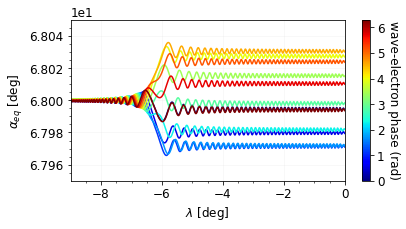

In [127]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 12})
###################################################################
fig, ax = plt.subplots(figsize=(6,85*inch_to_mm))
s=5

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for r in range(0,len(eta0)):
    ax.plot(np.rad2deg(lamda[r,:-1]),np.rad2deg(aeq[r,:-1]),c=cmap.to_rgba(eta0[r]))
ax.grid(alpha=.1)
ax.set_xlim(-9,0)
ax.set_xlabel(r'$\lambda$ [deg]')
ax.set_ylabel(r'$\alpha_{eq}$ [deg]')

ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.set_ylim(67.95,68.05)
ticks=np.arange(0,2*np.pi,1)
cbar=fig.colorbar(cmap, ticks=ticks)
cbar.set_label('wave-electron phase (rad)', rotation=270,labelpad=15)
# ax.axvline(x=-5,color="black", linestyle="--")
plt.tight_layout()
plt.savefig('aeq_aeq0_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()

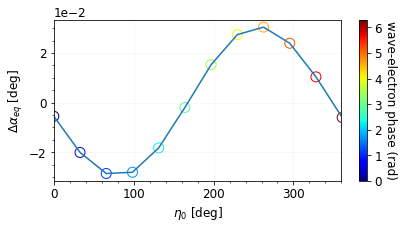

In [23]:
###################################################################
fig, ax = plt.subplots(figsize=(6,85*inch_to_mm))
s=5
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.plot(np.rad2deg(eta0),dalpha)
ax.scatter(np.rad2deg(eta0),dalpha,marker='o',facecolors='none', edgecolors=cmap.to_rgba(eta0[:]),s=100)
ax.grid(alpha=.1)
ax.set_xlim(0,360)
ax.set_xlabel(r'$\eta_0$ [deg]')
ax.set_ylabel(r'$\Delta\alpha_{eq}$ [deg]')

ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ticks=np.arange(0,2*np.pi,1)
cbar=fig.colorbar(cmap, ticks=ticks)
cbar.set_label('wave-electron phase (rad)', rotation=270,labelpad=15)
# ax.axvline(x=-5,color="black", linestyle="--")
plt.tight_layout()
plt.savefig('daeq_aeq0_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()


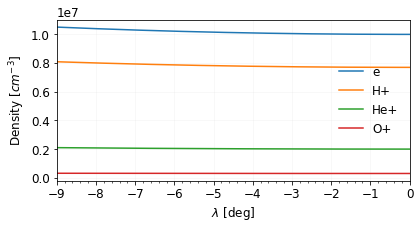

In [58]:

###################################################################
fig, ax = plt.subplots(figsize=(6,85*inch_to_mm))
s=5

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.plot(np.rad2deg(lamda[r,:-1]),ne_out[r,:-1],label='e')
ax.plot(np.rad2deg(lamda[r,:-1]),nH_out[r,:-1],label='H+')
ax.plot(np.rad2deg(lamda[r,:-1]),nHe_out[r,:-1],label='He+')
ax.plot(np.rad2deg(lamda[r,:-1]),nO_out[r,:-1],label='O+')
ax.grid(alpha=.1)
ax.set_xlim(-9,0)
ax.set_xlabel(r'$\lambda$ [deg]')
ax.set_ylabel(r'Density [$cm^{-3}$]')

# ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.legend(frameon=False)
# ax.set_yscale('log')
plt.tight_layout()
plt.savefig('densities_aeq0_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()

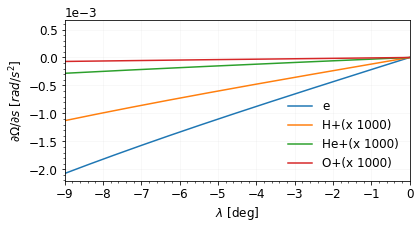

In [25]:

###################################################################
fig, ax = plt.subplots(figsize=(6,85*inch_to_mm))
s=5

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.plot(np.rad2deg(lamda[0,:-1]),dwceds_out[0,:-1],label='e')
ax.plot(np.rad2deg(lamda[0,:-1]),dwcHds_out[0,:-1]*1000,label='H+(x 1000)')
ax.plot(np.rad2deg(lamda[0,:-1]),dwcHeds_out[0,:-1]*1000,label='He+(x 1000)')
ax.plot(np.rad2deg(lamda[0,:-1]),dwcOds_out[0,:-1]*1000,label='O+(x 1000)')

# ax.set_yscale('symlog')
ax.grid(alpha=.1)
ax.set_xlim(-9,0)
ax.set_xlabel(r'$\lambda$ [deg]')
ax.set_ylabel(r'$\partial\Omega/\partial s$ [$rad/s^2$]')

ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.legend(frameon=False)
plt.tight_layout()
plt.savefig('dwcds_aeq0_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()

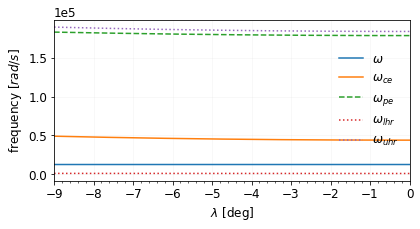

In [46]:
w_wave_array= np.full((np.shape(lamda)), w_wave)
###################################################################
fig, ax = plt.subplots(figsize=(6,85*inch_to_mm))
s=5

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.plot(np.rad2deg(lamda[0,:-1]),w_wave_array[0,:-1],label=r'$\omega$')
ax.plot(np.rad2deg(lamda[0,:-1]),wce_out[0,:-1],label=r'$\omega_{ce}$')
ax.plot(np.rad2deg(lamda[0,:-1]),wpe_out[0,:-1],label=r'$\omega_{pe}$',linestyle='dashed')
ax.plot(np.rad2deg(lamda[0,:-1]),wlhr_out[0,:-1],label=r'$\omega_{lhr}$',linestyle='dotted')
ax.plot(np.rad2deg(lamda[0,:-1]),wuhr_out[0,:-1],label=r'$\omega_{uhr}$',linestyle='dotted')

# ax.set_yscale('log')
ax.grid(alpha=.1)
ax.set_xlim(-9,0)
ax.set_xlabel(r'$\lambda$ [deg]')
ax.set_ylabel(r'frequency [$rad/s$]')

# ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.legend(frameon=False)
plt.tight_layout()
plt.savefig('freqs_aeq0_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()

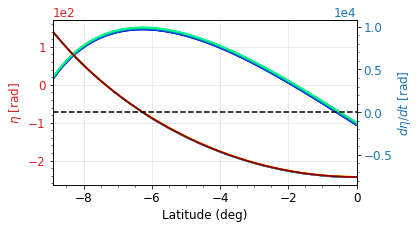

In [27]:
fig, ax1 = plt.subplots(figsize=(6,85*inch_to_mm))

color = 'tab:red'
ax1.set_xlabel('Latitude (deg)')
ax1.set_ylabel('$\eta$ [rad]', color=color)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax1.yaxis.set_minor_locator(tck.AutoMinorLocator())
for r in range(0,len(eta0)):
    ax1.plot(np.rad2deg(lamda[r,:-1]),eta[r,:-1],c=cmap2.to_rgba(eta0[r]))
    
ax1.tick_params(axis='y', labelcolor=color)


ax1.set_xlim(-8.9,0)
ax1.grid(alpha=.3)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
color = 'tab:blue'
ax2.set_ylabel('$d\eta/dt$ [rad]', color=color)  # we already handled the x-label with ax1
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# ax2.set_ylim(-0.45,0.2)
ax2.yaxis.set_minor_locator(tck.AutoMinorLocator())
for r in range(0,len(eta0)):
    ax2.plot(np.rad2deg(lamda[r,:-1]),deta_dt[r,:-1],c=cmap.to_rgba(eta0[r]))
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax2.axhline(y=0,color="black", linestyle="--")
plt.savefig('deta_aeq0_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()



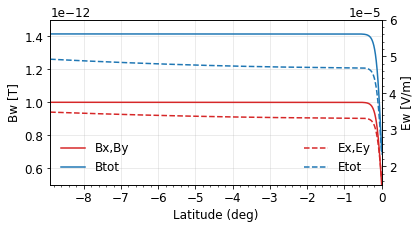

In [28]:
fig, ax1 = plt.subplots(figsize=(6,85*inch_to_mm))

ax1.set_xlabel('Latitude (deg)')
ax1.set_ylabel('Bw [T]')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax1.set_ylim(0.5*10**(-12),1.5*10**(-12))
ax1.plot(np.rad2deg(lamda[0,:-1]),Bxw_out[0,:-1],label='Bx,By',color='tab:red')
ax1.plot(np.rad2deg(lamda[0,:-1]),np.sqrt(Bxw_out[0,:-1]*Bxw_out[0,:-1]+Byw_out[0,:-1]*Byw_out[0,:-1]),label='Btot',color='tab:blue')

ax1.legend(frameon=False)
ax1.tick_params(axis='y')


ax1.set_xlim(-8.9,0)
ax1.grid(alpha=.3)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Ew [V/m]')  # we already handled the x-label with ax1
ax2.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax2.plot(np.rad2deg(lamda[0,:-1]),Exw_out[0,:-1],label='Ex,Ey',color='tab:red',linestyle='dashed')
ax2.plot(np.rad2deg(lamda[0,:-1]),np.sqrt(Exw_out[0,:-1]*Exw_out[0,:-1]+Eyw_out[0,:-1]*Eyw_out[0,:-1]),label='Etot',color='tab:blue',linestyle='dashed')

ax2.tick_params(axis='y')
ax2.set_ylim(1.5*10**(-5),6*10**(-5))
ax2.legend(frameon=False,loc=4)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('fields_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()

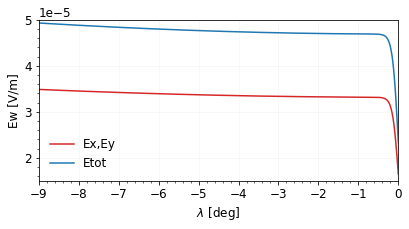

In [35]:
###################################################################
fig, ax = plt.subplots(figsize=(6,85*inch_to_mm))
s=5

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.plot(np.rad2deg(lamda[0,:-1]),Exw_out[0,:-1],label='Ex,Ey',color='tab:red')
ax.plot(np.rad2deg(lamda[0,:-1]),np.sqrt(Exw_out[0,:-1]*Exw_out[0,:-1]+Eyw_out[0,:-1]*Eyw_out[0,:-1]),label='Etot',color='tab:blue')

ax.grid(alpha=.1)
ax.set_xlim(-9,0)
ax.set_xlabel(r'$\lambda$ [deg]')
ax.set_ylabel('Ew [V/m]') 
ax.set_ylim(1.5*10**(-5),5*10**(-5))
ax.legend(frameon=False)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
# ax.legend(frameon=False)
plt.tight_layout()
plt.savefig('electric_aeq0_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()

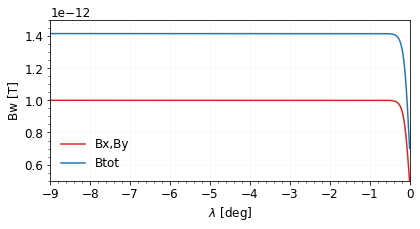

In [34]:

###################################################################
fig, ax = plt.subplots(figsize=(6,85*inch_to_mm))
s=5

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.plot(np.rad2deg(lamda[0,:-1]),Bxw_out[0,:-1],label='Bx,By',color='tab:red')
ax.plot(np.rad2deg(lamda[0,:-1]),np.sqrt(Bxw_out[0,:-1]*Bxw_out[0,:-1]+Byw_out[0,:-1]*Byw_out[0,:-1]),label='Btot',color='tab:blue')
# ax.set_yscale('log')
ax.grid(alpha=.1)
ax.set_xlim(-9,0)
ax.set_xlabel(r'$\lambda$ [deg]')
ax.set_ylabel('Bw [T]') 
ax.set_ylim(0.5*10**(-12),1.5*10**(-12))
ax.legend(frameon=False)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
# ax.legend(frameon=False)
plt.tight_layout()
plt.savefig('magnetic_aeq0_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()

In [33]:

###################################################################
fig, ax = plt.subplots(figsize=(6,85*inch_to_mm))
s=5

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.plot(np.rad2deg(lamda[0,:-1]),Bmag_out[0,:-1],color='tab:green')
# ax.set_yscale('log')
ax.grid(alpha=.1)
ax.set_xlim(-9,0)
ax.set_xlabel(r'$\lambda$ [deg]')
ax.set_ylabel('Magnetic field [T]') 
# ax.set_ylim(0.5*10**(-12),1.5*10**(-12))
# ax.legend(frameon=False)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
# ax.legend(frameon=False)
plt.tight_layout()
plt.savefig('magnetic_aeq0_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()

In [19]:

###################################################################
fig, ax = plt.subplots(figsize=(6,85*inch_to_mm))
s=5

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.plot(np.rad2deg(lamda[0,:-1]),np.abs(P_stix[0,:-1]),label='|P|')
ax.plot(np.rad2deg(lamda[0,:-1]),R_stix[0,:-1],label='R')
ax.plot(np.rad2deg(lamda[0,:-1]),np.abs(L_stix[0,:-1]),label='|L|')
ax.plot(np.rad2deg(lamda[0,:-1]),D_stix[0,:-1],label='D')
ax.plot(np.rad2deg(lamda[0,:-1]),S_stix[0,:-1],label='S')

ax.grid(alpha=.1)
ax.set_xlim(-9,0)
ax.set_xlabel(r'$\lambda$ [deg]')
ax.set_ylabel('Stix Parameters') 
ax.set_ylim(0,250)
ax.legend(frameon=False,loc=1)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
# ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
# ax.legend(frameon=False)
plt.tight_layout()
plt.savefig('stix_aeq0_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()

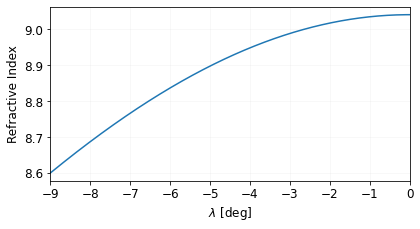

In [20]:
###################################################################
fig, ax = plt.subplots(figsize=(6,85*inch_to_mm))
s=5

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.plot(np.rad2deg(lamda[0,:-1]),(mu_out[0,:-1]))

ax.grid(alpha=.1)
ax.set_xlim(-9,0)
ax.set_xlabel(r'$\lambda$ [deg]')
ax.set_ylabel('Refractive Index') 
# ax.set_ylim(0,250)
# ax.legend(frameon=False,loc=1)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
# ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
# ax.legend(frameon=False)
plt.tight_layout()
plt.savefig('mu_aeq0_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()

/home/tourgaidis/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


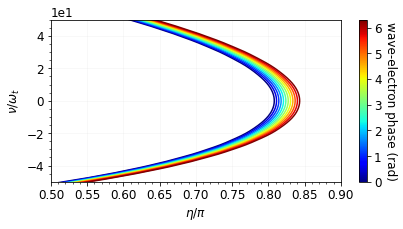

In [48]:
wtr=np.sqrt(wtrsq_out)
last=100
nplot=deta_dt/wtr

fig, ax = plt.subplots(figsize=(6,85*inch_to_mm))
s=5

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for r in range(0,len(eta0)):
    ax.plot(eta[r,:-last]/180,nplot[r,:-last],c=cmap.to_rgba(eta0[r]))
ax.grid(alpha=.1)
ax.set_xlim(0.5,0.9)
ax.set_xlabel(r'$\eta/\pi$')
ax.set_ylabel(r'$\nu/\omega_t$')

ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.set_ylim(-50,50)
ticks=np.arange(0,2*np.pi,1)
cbar=fig.colorbar(cmap, ticks=ticks)
cbar.set_label('wave-electron phase (rad)', rotation=270,labelpad=15)
# ax.axvline(x=-5,color="black", linestyle="--")
plt.tight_layout()
plt.savefig('nu_nonlinear_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()

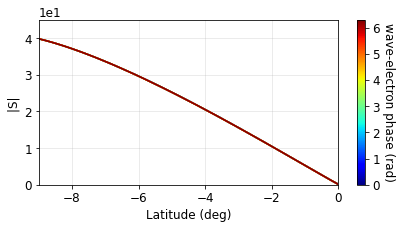

In [50]:
fig, ax = plt.subplots(figsize=(6,85*inch_to_mm))
s=5

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for r in range(0,len(eta0)):
    ax.plot(np.rad2deg(lamda[r,2:]),np.abs(S_out[r,2:]),c=cmap.to_rgba(eta0[r]))

ax.grid(alpha=.3)
ax.set_xlim(lamda0_deg,0)
ax.set_xlabel('Latitude (deg)')
ax.set_ylabel('|S| ')

ax.set_ylim(0,45)
ticks=np.arange(0,2*np.pi,1)
cbar=fig.colorbar(cmap, ticks=ticks)
cbar.set_label('wave-electron phase (rad)', rotation=270,labelpad=15)
# ax.axvline(x=-5,color="black", linestyle="--")
plt.tight_layout()
plt.savefig('S_nonlinear_%d_By_%d_nT.jpg' %(aeq0_deg,By_wave/10**(-12)),dpi=300)
plt.show()



In [52]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 12})

fig, axs = plt.subplots(4,1,figsize=(3,7))


fig.suptitle('$B_y^w$=%d pT' %(By_wave/10**(-12)))


plt.tight_layout()
for r in range(0,len(eta0)):
    axs[0].plot(np.rad2deg(lamda[r,:-1]),np.rad2deg(aeq[r,:-1]),c=cmap.to_rgba(eta0[r]))
axs[0].grid(alpha=.1)
axs[0].set_xlim(-9,0)
axs[0].set_xlabel(r'$\lambda$ [deg]')
axs[0].set_ylabel(r'$\alpha_{eq}$ [deg]',labelpad=10)
# axs[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[0].yaxis.set_minor_locator(tck.AutoMinorLocator())
axs[0].set_ylim(67.95,68.05)

axs[1].plot(np.rad2deg(eta0),dalpha)
axs[1].scatter(np.rad2deg(eta0),dalpha,marker='o',facecolors='none', edgecolors=cmap.to_rgba(eta0[:]),s=100)
axs[1].grid(alpha=.1)
axs[1].set_xlim(0,360)
axs[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

axs[1].set_xlabel(r'$\eta_0$ [deg]')
axs[1].set_ylabel(r'$\Delta\alpha_{eq}$ [deg]',labelpad=10)

for r in range(0,len(eta0)):
    axs[2].plot(np.rad2deg(lamda[r,:-1]),deta_dt[r,:-1],c=cmap.to_rgba(eta0[r]))
    
axs[2].grid(alpha=.1)
axs[2].set_xlim(-8.9,0)
axs[2].set_xlabel(r'$\lambda$ [deg]')
axs[2].set_ylabel(r'$d\eta/dt$ [rad]',labelpad=30)
axs[2].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[2].yaxis.set_minor_locator(tck.AutoMinorLocator())

for r in range(0,len(eta0)):
    axs[3].plot(eta[r,:-last]/180,nplot[r,:-last],c=cmap.to_rgba(eta0[r]))
axs[3].grid(alpha=.1)
axs[3].set_xlim(0.5,0.9)
axs[3].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[3].set_xlabel(r'$\eta/\pi$')
axs[3].set_ylabel(r'$\nu/\omega_t$',labelpad=18)
axs[3].set_ylim(-50,50)

plt.savefig('Multi_By_%d_nT.jpg' %(By_wave/10**(-12)),dpi=300, bbox_inches="tight")
plt.show()



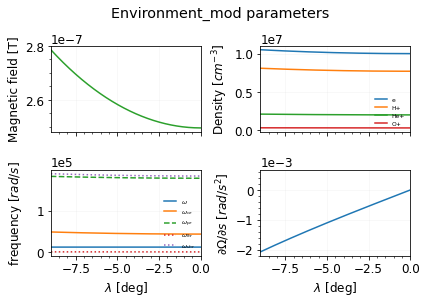

In [83]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 12})
###################################################################
fig, ax = plt.subplots(2,2)
fig.suptitle('Environment_mod parameters')
plt.tight_layout()
############
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0,0].plot(np.rad2deg(lamda[0,:-1]),Bmag_out[0,:-1],color='tab:green')
# ax.set_yscale('log')
ax[0,0].grid(alpha=.1)
ax[0,0].set_xlim(-9,0)
ax[0,0].tick_params(labelbottom = False)
ax[0,0].set_ylabel('Magnetic field [T]') 
# ax.set_ylim(0.5*10**(-12),1.5*10**(-12))
# ax.legend(frameon=False)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0,0].yaxis.set_minor_locator(tck.AutoMinorLocator())
ax[0,0].xaxis.set_minor_locator(tck.AutoMinorLocator())

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0,1].plot(np.rad2deg(lamda[r,:-1]),ne_out[r,:-1],label='e')
ax[0,1].plot(np.rad2deg(lamda[r,:-1]),nH_out[r,:-1],label='H+')
ax[0,1].plot(np.rad2deg(lamda[r,:-1]),nHe_out[r,:-1],label='He+')
ax[0,1].plot(np.rad2deg(lamda[r,:-1]),nO_out[r,:-1],label='O+')
ax[0,1].grid(alpha=.1)
ax[0,1].set_xlim(-9,0)
ax[0,1].tick_params(labelbottom = False)
ax[0,1].set_ylabel(r'Density [$cm^{-3}$]')
ax[0,1].legend(frameon=False,loc=4, prop={'size': 6})
# ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax[0,1].xaxis.set_minor_locator(tck.AutoMinorLocator())

###################


ax[1,0].plot(np.rad2deg(lamda[0,:-1]),w_wave_array[0,:-1],label=r'$\omega$')
ax[1,0].plot(np.rad2deg(lamda[0,:-1]),wce_out[0,:-1],label=r'$\omega_{ce}$')
ax[1,0].plot(np.rad2deg(lamda[0,:-1]),wpe_out[0,:-1],label=r'$\omega_{pe}$',linestyle='dashed')
ax[1,0].plot(np.rad2deg(lamda[0,:-1]),wlhr_out[0,:-1],label=r'$\omega_{lhr}$',linestyle='dotted')
ax[1,0].plot(np.rad2deg(lamda[0,:-1]),wuhr_out[0,:-1],label=r'$\omega_{uhr}$',linestyle='dotted')
ax[1,0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax[1,0].grid(alpha=.1)
ax[1,0].set_xlim(-9,0)
ax[1,0].set_xlabel(r'$\lambda$ [deg]')
ax[1,0].set_ylabel(r'frequency [$rad/s$]',labelpad=12)
ax[1,0].legend(frameon=False,loc=4, prop={'size': 6})
# ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax[1,0].xaxis.set_minor_locator(tck.AutoMinorLocator())


##########################################
ax[1,1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[1,1].plot(np.rad2deg(lamda[0,:-1]),dwceds_out[0,:-1],label='e')

# ax.set_yscale('symlog')
ax[1,1].grid(alpha=.1)
ax[1,1].set_xlim(-9,0)
ax[1,1].set_xlabel(r'$\lambda$ [deg]')
ax[1,1].set_ylabel(r'$\partial\Omega/\partial s$ [$rad/s^2$]')

ax[1,1].yaxis.set_minor_locator(tck.AutoMinorLocator())
ax[1,1].xaxis.set_minor_locator(tck.AutoMinorLocator())

for ax in axs.flat:
    ax.label_outer()
    
plt.savefig('EnvMod_By_%d_nT.jpg' %(By_wave/10**(-12)),dpi=300, bbox_inches="tight")
plt.show()

In [250]:
lat=np.deg2rad(-10)
L_shell=5
Bmag=env.Bmag_dipole(L_shell,lat)
Kpmax=1
day=0
mlt=2
Rsun=90

theta=np.deg2rad(88)

ne_eq=env.density_FL_denton(ne_0,lat)
# print(ne_eq/10**7)

#assuming 84%H+, 5.4%He+, 0.6%O+
nH_eq=0.77*ne_eq
nHe_eq=0.2*ne_eq
nO_eq=0.03*ne_eq

wce_=env.omega_cyclotron(Bmag,env.const.qe,env.const.me)
wcH=env.omega_cyclotron(Bmag,env.const.qi,env.const.mH)
wcHe=env.omega_cyclotron(Bmag,env.const.qi,env.const.mHe)
wcO=env.omega_cyclotron(Bmag,env.const.qi,env.const.mO)

wpe=env.omega_plasma(ne_eq,env.const.qe,env.const.me)
wpH=env.omega_plasma(nH_eq,env.const.qi,env.const.mH)
wpHe=env.omega_plasma(nHe_eq,env.const.qe,env.const.mHe)
wpO=env.omega_plasma(nO_eq,env.const.qi,env.const.mO)

wlhr=env.omega_lhr(wce_,wpe,wcH,wpH)

f_wave=2000
w_wave=2*np.pi*f_wave

S_tmp,D_tmp,P_tmp,R_tmp,L_tmp=wave.stix_parameters(w_wave, ne_eq, nH_eq, nHe_eq, nO_eq, Bmag)


mu_sq_plus_tmp,mu_sq_minus_tmp,ref_indtmp,kappatmp,kappa_partmp,kappa_pertmp=wave.refr_index_full(theta,w_wave,S_tmp,P_tmp,R_tmp,L_tmp)

K_11,K_12,K_13,K_21,K_22,K_23,K_31,K_32,K_33=wave.cold_dielectric_tensor(w_wave,wce_,wpe,wcH,wpH,wcHe,wpHe,wcO,wpO)


Ke,KH,KHe,KO=wave.warm_dielectric_tensor(w_wave,wce_,wpe,wcH,wpH,wcHe,wpHe,wcO,wpO,theta)

Te=1
Ti=1
ref_ind_warm,kappa_warm,kappa_par_warm,kappa_per_warm=wave.refr_index_warm(Ke,KH,KHe,KO,theta,Te,Ti,K_11,K_22,K_33,K_12,w_wave)
S_warm,D_warm,P_warm,R_warm,L_warm=wave.stix_parameters_warm(S_tmp,D_tmp,P_tmp,Te,Ti,ref_ind_warm,Ke,KH,KHe,KO)


theta_res=wave.res_angle(P_tmp,S_tmp)-0.00001

mu_sq_plus_res,mu_sq_minus_res,ref_indres,kappares,kappa_parres,kappa_perres=wave.refr_index_full(theta_res,w_wave,S_tmp,P_tmp,R_tmp,L_tmp)


#refractive index surface
thetas=np.arange(0,360,0.1)
thetas_rad=np.deg2rad(thetas)

mupar_cold=[]
muper_cold=[]
mupar_warm_e1_i0=[]
muper_warm_e1_i0=[]
mupar_warm_e0_i1=[]
muper_warm_e0_i1=[]
mupar_warm_e1_i1=[]
muper_warm_e1_i1=[]
mupar_warm_e4_i4=[]
muper_warm_e4_i4=[]
for i in range(0,len(thetas_rad)):
    
    mu_sq_plus_tmp,mu_sq_minus_tmp,ref_cold,kappatmp,kappa_partmp,kappa_pertmp=wave.refr_index_full(thetas_rad[i],w_wave,S_tmp,P_tmp,R_tmp,L_tmp)
    Ke,KH,KHe,KO=wave.warm_dielectric_tensor(w_wave,wce_,wpe,wcH,wpH,wcHe,wpHe,wcO,wpO,thetas_rad[i])
    ref_ind_warm10,kappa_warm,kappa_par_warm,kappa_per_warm=wave.refr_index_warm(Ke,KH,KHe,KO,thetas_rad[i],1,0,K_11,K_22,K_33,K_12,w_wave)
    ref_ind_warm01,kappa_warm,kappa_par_warm,kappa_per_warm=wave.refr_index_warm(Ke,KH,KHe,KO,thetas_rad[i],0,1,K_11,K_22,K_33,K_12,w_wave)
    ref_ind_warm11,kappa_warm,kappa_par_warm,kappa_per_warm=wave.refr_index_warm(Ke,KH,KHe,KO,thetas_rad[i],1,1,K_11,K_22,K_33,K_12,w_wave)
    ref_ind_warm44,kappa_warm,kappa_par_warm,kappa_per_warm=wave.refr_index_warm(Ke,KH,KHe,KO,thetas_rad[i],4,4,K_11,K_22,K_33,K_12,w_wave)
    
    
    ref_par_cold_tmp=ref_cold*np.cos(thetas_rad[i])
    ref_per_cold_tmp=ref_cold*np.sin(thetas_rad[i])
    ref_par_warm_tmp10=ref_ind_warm10*np.cos(thetas_rad[i])
    ref_per_warm_tmp10=ref_ind_warm10*np.sin(thetas_rad[i])
    ref_par_warm_tmp01=ref_ind_warm01*np.cos(thetas_rad[i])
    ref_per_warm_tmp01=ref_ind_warm01*np.sin(thetas_rad[i])
    ref_par_warm_tmp11=ref_ind_warm11*np.cos(thetas_rad[i])
    ref_per_warm_tmp11=ref_ind_warm11*np.sin(thetas_rad[i])
    ref_par_warm_tmp44=ref_ind_warm44*np.cos(thetas_rad[i])
    ref_per_warm_tmp44=ref_ind_warm44*np.sin(thetas_rad[i])
    
    mupar_cold.append(ref_par_cold_tmp)
    muper_cold.append(ref_per_cold_tmp)
    mupar_warm_e1_i0.append(ref_par_warm_tmp10)
    muper_warm_e1_i0.append(ref_per_warm_tmp10)
    mupar_warm_e0_i1.append(ref_par_warm_tmp01)
    muper_warm_e0_i1.append(ref_per_warm_tmp01)
    mupar_warm_e1_i1.append(ref_par_warm_tmp11)
    muper_warm_e1_i1.append(ref_per_warm_tmp11)
    mupar_warm_e4_i4.append(ref_par_warm_tmp44)
    muper_warm_e4_i4.append(ref_per_warm_tmp44)

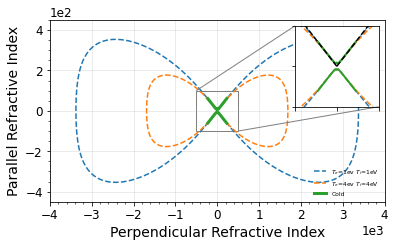

In [258]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
###########################################################
fig, ax = plt.subplots(figsize=(6,85*inch_to_mm))
s=5
# ax.set_title('Refractive index surface, f=2kHz, L=5,')
ax.set_xlabel("Perpendicular Refractive Index",fontsize=14)
ax.set_ylabel("Parallel Refractive Index",fontsize=14)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# ax.plot(muper_warm_e1_i0,mupar_warm_e1_i0,label=r'$T_e$=1ev $T_i$=0eV',linestyle='--')
# ax.plot(muper_warm_e0_i1,mupar_warm_e0_i1,label=r'$T_e$=0ev $T_i$=1eV',linestyle='--')
ax.plot(muper_warm_e1_i1,mupar_warm_e1_i1,label=r'$T_e$=1ev $T_i$=1eV',linestyle='--')
ax.plot(muper_warm_e4_i4,mupar_warm_e4_i4,label=r'$T_e$=4ev $T_i$=4eV',linestyle='--')
ax.plot(muper_cold,mupar_cold,color="tab:green",label='Cold',linewidth=3)

ax.legend(frameon=False,loc=4, prop={'size': 6})
ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.set_xlim(-4000,4000)
ax.set_ylim(-450,450)
ax.grid(alpha=.3)
scale=10
axins = zoomed_inset_axes(ax, 2, loc=1)
axins.plot(muper_warm_e1_i1,mupar_warm_e1_i1,label=r'$T_e$=1ev $T_i$=1eV',linestyle='--')
axins.plot(muper_warm_e4_i4,mupar_warm_e4_i4,label=r'$T_e$=4ev $T_i$=4eV',linestyle='--')
axins.plot(muper_cold,mupar_cold,color="tab:green",label='Cold',linewidth=2)
axins.plot([0, scale*ref_indres*np.sin(theta_res)], [0, scale*ref_indres*np.cos(theta_res)],color='black',linestyle='dashed')
# axins.plot([0, scale*ref_indres*np.sin(theta_res-np.pi)], [0, scale*ref_indres*np.cos(theta_res)],color='black',linestyle='dashed')

axins.set_xlim(-500, 500)
axins.set_ylim(-100, 100)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.savefig('Refr_surf_By_%d_nT.jpg' %(By_wave/10**(-12)),dpi=300, bbox_inches="tight")
plt.show()

In [281]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 12})
###################################################################
fig, ax = plt.subplots(2,2)
fig.suptitle('Environment_mod parameters')
plt.tight_layout()
############
ax[0,0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0,0].plot(np.rad2deg(lamda[0,:-1]),np.abs(P_stix[0,:-1]),label='|P|')
ax[0,0].plot(np.rad2deg(lamda[0,:-1]),R_stix[0,:-1],label='R')
ax[0,0].plot(np.rad2deg(lamda[0,:-1]),np.abs(L_stix[0,:-1]),label='|L|')
ax[0,0].plot(np.rad2deg(lamda[0,:-1]),D_stix[0,:-1],label='D')
ax[0,0].plot(np.rad2deg(lamda[0,:-1]),S_stix[0,:-1],label='S')

ax[0,0].grid(alpha=.1)
ax[0,0].set_xlim(-9,0)
ax[0,0].set_xlabel(r'$\lambda$ [deg]')
ax[0,0].set_ylabel('Stix Parameters') 
ax[0,0].set_ylim(0,250)
ax[0,0].legend(frameon=False,loc=1, prop={'size': 6})
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
# ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
# ax.legend(frameon=False)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0,1].set_xlabel(r'$\mu_\perp$')
ax[0,1].set_ylabel(r'$\mu_\parallel$')

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# ax.plot(muper_warm_e1_i0,mupar_warm_e1_i0,label=r'$T_e$=1ev $T_i$=0eV',linestyle='--')
# ax.plot(muper_warm_e0_i1,mupar_warm_e0_i1,label=r'$T_e$=0ev $T_i$=1eV',linestyle='--')
ax[0,1].plot(muper_warm_e1_i1,mupar_warm_e1_i1,label=r'$T_e$=1ev $T_i$=1eV',linestyle='--')
ax[0,1].plot(muper_warm_e4_i4,mupar_warm_e4_i4,label=r'$T_e$=4ev $T_i$=4eV',linestyle='--')
ax[0,1].plot(muper_cold,mupar_cold,color="tab:green",label='Cold',linewidth=3)
ax[0,1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0,1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax[0,1].legend(frameon=False,loc=2, prop={'size': 6})
ax[0,1].yaxis.get_ticklocs(minor=True)
ax[0,1].minorticks_on()
ax[0,1].set_xlim(-4000,4000)
ax[0,1].set_ylim(-450,450)
ax[0,1].grid(alpha=.1)
scale=10
axins = zoomed_inset_axes(ax[0,1], 2, loc=1)
axins.plot(muper_warm_e1_i1,mupar_warm_e1_i1,label=r'$T_e$=1ev $T_i$=1eV',linestyle='--')
axins.plot(muper_warm_e4_i4,mupar_warm_e4_i4,label=r'$T_e$=4ev $T_i$=4eV',linestyle='--')
axins.plot(muper_cold,mupar_cold,color="tab:green",label='Cold',linewidth=2)
axins.plot([0, scale*ref_indres*np.sin(theta_res)], [0, scale*ref_indres*np.cos(theta_res)],color='black',linestyle='dashed')
# axins.plot([0, scale*ref_indres*np.sin(theta_res-np.pi)], [0, scale*ref_indres*np.cos(theta_res)],color='black',linestyle='dashed')

axins.set_xlim(-500, 500)
axins.set_ylim(-100, 100)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax[0,1], axins, loc1=2, loc2=4, fc="none", ec="0.5")
###################


ax[1,0].plot(lamda_packet2,Bw_1pT,c='tab:blue',label='1pT')
ax[1,0].plot(lamda_packet2,Bw_10pT,c='tab:red',label='10pT')
ax[1,0].plot(lamda_packet2,Bw_100pT,c='tab:green',label='100pT')
ax[1,0].plot(lamda_packet2,Bw_1nT,c='tab:orange',label='1nT')
ax[1,0].grid(alpha=.1)
ax[1,0].set_xlim(-9,1)
ax[1,0].set_xlabel(r'$\lambda$ [deg]')
ax[1,0].set_ylabel(r'Bw [T]')

# ax[1,0].set_yscale('log')
ax[1,0].yaxis.set_minor_locator(tck.AutoMinorLocator())
ax[1,0].xaxis.set_minor_locator(tck.AutoMinorLocator())
ax[1,0].set_ylim(-0.5*10**(-9),1.1*10**(-9))
ax[1,0].legend(frameon=False,loc=0, prop={'size': 6})

# axins2 = zoomed_inset_axes(ax[1,0], 2, loc=1)
# axins2.plot(lamda_packet2,Bw_1pT,c='tab:blue',label='1pT')
# axins2.plot(lamda_packet2,Bw_10pT,c='tab:red',label='10pT')
# axins2.plot(lamda_packet2,Bw_100pT,c='tab:green',label='100pT')
# axins2.plot(lamda_packet2,Bw_1nT,c='tab:orange',label='1nT')

# axins2.set_xlim(-500, 500)
# axins2.set_ylim(-100, 100)
# plt.xticks(visible=False)
# plt.yticks(visible=False)
# mark_inset(ax[1,0], axins2, loc1=2, loc2=4, fc="none", ec="0.5")
##########################################
ax[1,1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[1,1].plot(np.rad2deg(lamda[0,:-1]),dwceds_out[0,:-1],label='e')


ax[1,1].grid(alpha=.1)
ax[1,1].set_xlim(-9,0)
ax[1,1].set_xlabel(r'$\lambda$ [deg]')
ax[1,1].set_ylabel(r'$\partial\Omega/\partial s$ [$rad/s^2$]')

ax[1,1].yaxis.set_minor_locator(tck.AutoMinorLocator())
ax[1,1].xaxis.set_minor_locator(tck.AutoMinorLocator())

for ax in axs.flat:
    ax.label_outer()
    
plt.savefig('WaveMod_By_%d_nT.jpg' %(By_wave/10**(-12)),dpi=300, bbox_inches="tight")
plt.show()

ValueError: Image size of 156284x508355611 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 37508x122005346 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 6 Axes>